<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Higher Analysis & Spaces**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

2.2.0


![analysis](https://upload.wikimedia.org/wikipedia/commons/c/c5/3d-function-9.svg)

## **Funktionalanalysis**

#### **Funktionalanalysis**

Functional Analysis: https://youtube.com/playlist?list=PLBh2i93oe2qsGKDOsuVVw-OCAfprrnGfr

Weitergehende analytische Eigenschaften, wie [Stetigkeit](https://de.wikipedia.org/wiki/Stetige_Funktion), [Differenzierbarkeit](https://de.wikipedia.org/wiki/Differenzierbarkeit) oder [Integrierbarkeit](https://de.wikipedia.org/wiki/Integralrechnung), erfordern auf der Definitionsmenge zumindest eine [topologische](https://de.wikipedia.org/wiki/Topologischer_Raum), [metrische](https://de.wikipedia.org/wiki/Metrischer_Raum) oder [maßtheoretische](https://de.wikipedia.org/wiki/Maßraum) Struktur.

**Analysis**

Die Begriffe der Norm (als Verallgemeinerung des Betrags), der Konvergenz, der Stetigkeit und der Grenzwerte lassen sich einfach von einer in mehrere Dimensionen verallgemeinern.

https://de.m.wikipedia.org/wiki/Analysis

* Gewöhnliche Differentialgleichungen, Eindimensionale Differential- & Integralrechnung

* Functional analysis is organized around adequate techniques to bring function spaces as topological vector spaces within reach of the ideas that would apply to normed spaces of finite dimension. 

* Die historischen Wurzeln der Funktionalanalysis liegen im Studium der **Fouriertransformation** und aahnlicher Transformationen sowie der Untersuchung von Differential- und Integralgleichungen. 

* Der Wortbestandteil ”funktional“ geht auf die **Variationsrechnung** zuru ̈ck.

* Grundlage der Funktionalanalysis sind Vektorräume über den reellen oder komplexen Zahlen. Der Grundbegriff ist hier der topologische Vektorraum, der dadurch gekennzeichnet ist, **dass die Vektorraumverknüpfungen stetig sind**, etwas konkreter werden auch lokalkonvexe topologische Vektorräume und Fréchet-Räume untersucht. 

* Wichtige Aussagen sind dabei der Satz von Hahn-Banach, der Satz von Baire und der Satz von Banach-Steinhaus. Insbesondere in der Lösungstheorie partieller Differentialgleichungen spielen diese eine wichtige Rolle, darüber hinaus in der Fredholm-Theorie.

* Der wichtigste Spezialfall **lokalkonvexer topologischer Vektorräume** sind **normierte Vektorräume**. Sind diese zusätzlich vollständig, dann heißen sie **Banachräume**. Noch spezieller betrachtet man **Hilberträume**, bei denen die Norm von einem Skalarprodukt erzeugt wird. Diese Räume sind von grundlegender Bedeutung für die mathematische Formulierung der Quantenmechanik. Ein wichtiger Untersuchungsgegenstand sind stetige lineare Operatoren auf Banach- oder Hilberträumen.



Folgende Themen sollen behandelt werden:

* Distributionen
* Unbeschränkte Operatoren, Spektralsatz 
* Banach-Räume, Hilbert-Räume (insbesondere Lp- und **Sobolev Räume**) und beschränkte lineare Operatoren darauf.
* Pseudodifferentialoperatoren
* Grundlegende Sätze der Funktionalanalysis (Hahn-Banach, Banach-Steinhaus, Satz vom abgeschlossenen Graphen...)
* Kompakte Operatoren und Fredholm Theorie
* Spektraltheorie kompakter Operatoren
* Grundzüge nicht beschränkter Operatoren
* Anwendungen auf Randwertprobleme elliptischer partieller Differentialgleichungen


Der große Reiz der Funktionalanalysis ist, dass die im Grundstudium erworbenen Konzepte der Analysis (Stetigkeit, Grenzwerte, Vollständigkeit) und Linearen Algebra (Vektorräume, lineare Abbildungen, Eigenwerte) konsequent zusammengeführt werden und gemeinsam eine Theorie liefern, die wiederrum in vielen Bereichen der Mathematik und Physik ein unabdingbares Werkzeug ist. Im Rahmen des Masterschwerpunktes Partielle Differentialgleichungen sollen in dieser Vorlesung insbesondere die Anwendung im Studium partieller Differentialgleichungen im Fokus liegen.


**In der Funktionalanalysis betrachtet man topologische Vektorräume, d. h. Vektorräume, auf denen man von Konvergenz sprechen und dementsprechend auch unendliche Summen bilden kann**. Good overview [here](https://matheplanet.com/default3.html?call=article.php?sid=1192&ref=https%3A%2F%2Fwww.google.de%2F)

**Das Ziel der Funktionalanalysis** ist es nicht zuletzt, die **<u>Methoden der mehrdimensionalen Analysis auf unendlichdimensionale Räume auszudehnen und dabei insbesondere Konzepte wie Konvergenz, Stetigkeit und Differenzierbarkeit zu untersuchen</u>**. 

Daher werden a priori **nur Vektorräume betrachtet, die zumindest eine topologische Struktur tragen, also die topologischen Vektorräume**. Zu ihnen zählen unter anderem alle normierten Vektorräume und insbesondere die Banach- und Hilberträume.

https://de.m.wikipedia.org/wiki/Nichtstandardanalysis

**Nichtstandardanalysis**

* There are also applications of nonstandard analysis to the theory of stochastic processes, particularly constructions of Brownian motion as random walks. 

https://de.m.wikipedia.org/wiki/Nichtstandardanalysis


https://en.wikipedia.org/wiki/Surreal_number

https://en.wikipedia.org/wiki/Hyperreal_number

https://en.wikipedia.org/wiki/Infinitesimal


**Numerische Mathematik**

https://de.m.wikipedia.org/wiki/Gleichung#Einteilung_nach_(Nicht)Linearität

siehe unter Differentialgleichungen

https://de.m.wikipedia.org/wiki/Liste_numerischer_Verfahren#Numerik_gewöhnlicher_Differentialgleichungen

Test functions for optimization (for numerik):

https://towardsdatascience.com/optimization-eye-pleasure-78-benchmark-test-functions-for-single-objective-optimization-92e7ed1d1f12

https://en.m.wikipedia.org/wiki/Test_functions_for_optimization


https://de.m.wikipedia.org/wiki/Approximation

Für viele mathematische Probleme, wie zum Beispiel die Optimierung oder das Lösen von partiellen Differentialgleichungen, existieren eine Vielzahl numerischer Verfahren und Algorithmen. Eine kommentierte Zusammenstellung von ausgewählten numerischen Verfahren findet man unter Liste numerischer Verfahren.



https://de.m.wikipedia.org/wiki/Liste_numerischer_Verfahren

https://de.m.wikipedia.org/wiki/Optimierung_(Mathematik)#Nichtlineare_Optimierung

https://de.m.wikipedia.org/wiki/Optimierungsproblem

https://de.m.wikipedia.org/wiki/Gleichung#Einteilung_nach_(Nicht)Linearität

* [numerische Mathematik](https://de.m.wikipedia.org/wiki/Numerische_Mathematik), auch Numerik, beschäftigt sich mit der Konstruktion und Analyse von Algorithmen für kontinuierliche mathematische Probleme.

  * jede Menge, welche die Mächtigkeit der reellen Zahlen hat, ist ein [Kontinuum](https://de.m.wikipedia.org/wiki/Kontinuum_(Mathematik))

* Hauptanwendung ist dabei die näherungsweise Berechnung von Lösungen durch Approximationsalgorithmen mit Hilfe von Computern

**Approximation**

* Von besonderem Interesse ist die **Näherung von Funktionen**, beispielsweise für Näherungslösungen nicht exakt lösbarer Differentialgleichungen. Die häufigste Form ist die Approximation mit Polynomen, da diese einfach ableitbar, integrierbar und berechenbar sind. 

* Hier beruht das am weitesten verbreitete Verfahren auf der **Taylorreihenentwicklung**. Von großer praktischer Bedeutung ist auch die **Fourieranalyse**, bei der periodische Funktionen in unendlichen Reihen von Sinus- und Kosinusfunktionen entwickelt werden.

https://de.m.wikipedia.org/wiki/Approximation

https://de.m.wikipedia.org/wiki/Gleitkommazahl

https://de.m.wikipedia.org/wiki/NP-Vollständigkeit

https://de.m.wikipedia.org/wiki/Landau-Symbole

**Interpolation (Approximation)**

* bei der [Interpolation](https://de.m.wikipedia.org/wiki/Interpolation_(Mathematik)) soll zu gegebenen diskreten Daten (z. B. Messwerten) eine stetige Funktion (= Interpolante oder Interpolierende) gefunden werden, die diese Daten abbildet. Man sagt dann, die Funktion interpoliert die Daten.

* Die Interpolation ist eine Art der Approximation: Die betrachtete Funktion wird durch die Interpolationsfunktion in den Stützstellen exakt wiedergegeben und in den restlichen Punkten immerhin näherungsweise

* Da Polynome mit zunehmendem Grad immer instabiler werden, d. h. stark zwischen den Interpolationspunkten schwingen, werden in der Praxis Polynome mit einem Grad größer als 5 kaum eingesetzt. Stattdessen **interpoliert man einen großen Datensatz stückweise**.

**Gaußprozess-Regression (Kriging)**

https://de.m.wikipedia.org/wiki/Kriging

https://de.m.wikipedia.org/wiki/Gauß-Prozess#Gaußprozess-Regression

https://medium.com/criteo-engineering/hyper-parameter-optimization-algorithms-2fe447525903

**Ausgleichungsrechnung (Curve Fitting)**

https://de.m.wikipedia.org/wiki/Ausgleichungsrechnung

#### **Spaces**

###### **Overview**

Ubersichr Räume: skalarprodukt etc: https://youtu.be/xshaxciJb24

cauchy sequence: https://youtu.be/3olS8tyoQEE

![Normed Vector Space](https://upload.wikimedia.org/wikipedia/en/7/74/Mathematical_Spaces.png)

Quelle: [Mathematical Spaces](https://en.m.wikipedia.org/wiki/Space_(mathematics))

**What constitutes a 'space'?**

* **A space is a [set](https://en.m.wikipedia.org/wiki/Set_(mathematics)) - (sometimes called a [universe - Grundmenge](https://en.m.wikipedia.org/wiki/Universe_(mathematics))) with some added structure.**

* A space consists of selected **mathematical objects that are treated as points**, and selected **relationships between these points**.

* The nature of the points can vary widely: for example, the **points can be elements of a set, functions on another space, or subspaces of another space.**

* While modern mathematics uses many types of spaces, such as Euclidean spaces, linear spaces, topological spaces, Hilbert spaces, or probability spaces, **it does not define the notion of "space" itself.** 

**[Taxonomy of Spaces](https://en.m.wikipedia.org/wiki/Space_(mathematics)#Taxonomy_of_spaces)**: While each type of space has its own definition, the general idea of "space" evades formalization.

* **It is the relationships that define the nature of the space**. More precisely, isomorphic spaces are considered identical, where an isomorphism between two spaces is a one-to-one correspondence between their points that preserves the relationships. For example, the relationships between the points of a three-dimensional Euclidean space are uniquely determined by Euclid's axioms, and all three-dimensional Euclidean spaces are considered identical.

* They are frequently described as different types of [manifolds](https://en.m.wikipedia.org/wiki/Manifold), which are **spaces that locally approximate to Euclidean space**, and where the properties are defined largely on local connectedness of points that lie on the manifold. 

**Important Spaces**: Vektorräume und topologische Räume, Metrische und uniforme Räume, Normierte Räume und Skalarprodukträume, Affine und projektive Räume, Differenzierbare und Riemannsche Mannigfaltigkeiten, Messräume, Maßräume und Wahrscheinlichkeitsräume

**Summary: From Norm to Norm Topology**

Eine [Normtopologie](https://de.m.wikipedia.org/wiki/Normtopologie) (siehe auch: [Norm: Normierte Raume](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normierte_Räume) ) ist eine Topologie auf einem normierten Vektorraum, die durch die Norm des Vektorraums induziert wurde.

1. Ist $(V,\|\cdot\|)$ ein normierter Vektorraum, so induziert die Norm des Raums durch Differenzenbildung zweier Vektoren $x, y \in V$ eine Metrik
$
d(x, y):=\|x-y\| .
$
auf $V$. Mit dieser Metrik wird der Vektorraum zu einem metrischen Raum $(V, d)$. 

2. Eine Metrik kann nun verwendet werden, um eine $\varepsilon$ -Umgebung um einen Vektor $x \in V$ durch
$
U_{\varepsilon}(x):=\{y \in V, d(x, y)<\varepsilon\}
$
zu definieren. Damit heißt dann eine Teilmenge $M \subset V$ offen, falls
$
\forall x \in M \exists \varepsilon>0: U_{\varepsilon}(x) \subset M
$
gilt. Über diese offenen Mengen induziert die Metrik nun auf $V$ eine Topologie
$
\mathcal{T}:=\{M \subset V, M \text { offen }\}
$.

3. Mit dieser Topologie wird der Vektorraum zu einem topologischen Vektorraum ($\mathcal {V}$ , $\mathcal {T}$) und diese letztendlich von der Norm induzierte Topologie heißt Normtopologie.

Topologischer Raum |  | dazugehörige Struktur
--- | --- | ---
[Euklidischer Raum](https://de.m.wikipedia.org/wiki/Euklidischer_Raum) | hat | Skalarprodukt
[Normierter Raum](https://de.m.wikipedia.org/wiki/Normierter_Raum) | hat | Norm
[Metrischer Raum](https://de.m.wikipedia.org/wiki/Metrischer_Raum) | hat | Metrik
[Uniformer Raum](https://de.m.wikipedia.org/wiki/Uniformer_Raum) | hat | Uniforme Struktur
[Topologischer Raum](https://de.m.wikipedia.org/wiki/Topologischer_Raum) | hat | Topologie

Quelle: [Einordnung in die Hierarchie mathematischer Strukturen](https://de.m.wikipedia.org/wiki/Metrischer_Raum#Einordnung_in_die_Hierarchie_mathematischer_Strukturen) sowie [Topologische Räume](https://de.m.wikipedia.org/wiki/Topologischer_Raum#Beispiele)

![xxx](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Beziehungen_zwischen_mathematischen_Räumen.svg/220px-Beziehungen_zwischen_mathematischen_Räumen.svg.png)

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Mathematical_implication_diagram-alt-large-print.svg/640px-Mathematical_implication_diagram-alt-large-print.svg.png)

Quelle: [Overview of types of abstract spaces](https://en.m.wikipedia.org/wiki/Space_(mathematics))

**Vektorraum**

Abstract Vector Spaces: https://youtu.be/TgKwz5Ikpc8

**More about Vector Spaces under 'Algebra'**

* There are many diverse mathematical objects that are called spaces. For example, [vector spaces](https://en.m.wikipedia.org/wiki/Vector_space) such as [function spaces](https://en.m.wikipedia.org/wiki/Function_space) may have infinite numbers of independent dimensions and a notion of distance very different from Euclidean space, and [topological spaces](https://en.m.wikipedia.org/wiki/Topological_space) replace the concept of distance with a more abstract idea of nearness.

* **Infinite-dimensional vector spaces arise naturally in mathematical analysis, as function spaces**, whose vectors are functions. These vector spaces are generally endowed with additional structure, which may be a topology, allowing the consideration of issues of proximity and continuity. 

* Among these topologies, those that are defined by a norm or inner product are more commonly used, as having a notion of distance between two vectors. This is particularly the case of **Banach spaces and Hilbert spaces**, which are fundamental in mathematical analysis.

**Konkrete form of vectors don't matter (matrices, vectors, functions, pie transforms etc). All what matters are the 8 axioms which define a vector space:**

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/vectorspace_axioms.png)

https://www.youtube.com/watch?v=TgKwz5Ikpc8&list=WL&index=33&t=638s

**Funktionenraum**

> **Vektorräume, deren Elemente selbst Funktionen sind, nennt man Funktionenräume.**

A function space is a set of functions between two fixed sets. Often, the domain and/or codomain will have additional structure which is inherited by the function space. For example, the set of functions from any set X into a vector space has a natural vector space structure given by pointwise addition and scalar multiplication. In other scenarios, the function space might inherit a topological or metric structure, hence the name function space.

* Ein [Funktionenraum](https://de.wikipedia.org/wiki/Funktionenraum) ist **eine Menge von Funktionen, die alle denselben Definitionsbereich besitzen**. Allerdings kann der Begriff Funktionenraum ähnlich wie der mathematische Begriff Raum nicht scharf abgegrenzt werden.

* Meist ist ein Funktionenraum mit einer **Vektoraddition und Skalarmultiplikation** versehen, so dass er einen Vektorraum bildet, dann spricht man von einem **linearen Funktionenraum**

* Viele wichtige lineare Funktionenräume sind unendlichdimensional. Diese bilden einen wichtigen Untersuchungsgegenstand der Funktionalanalysis. 

* Lineare Funktionenräume werden häufig mit einer Norm versehen, sodass ein normierter Raum oder – im Falle der Vollständigkeit – sogar ein Banachraum entsteht. In anderen Fällen werden lineare Funktionenräume durch Definition einer Topologie zu einem topologischen Vektorraum oder einem lokalkonvexen Raum.

* Funktionenräume sind im Bereich der linearen Algebra Vektorräume, deren Elemente als Funktionen aufgefasst werden. Hauptsächlich werden Funktionenräume allerdings im Bereich der Funktionalanalysis betrachtet. **Hier wird unter einem Funktionenraum ein Vektorraum mit einer topologischen Struktur verstanden, dessen Elemente als Funktionen aufgefasst werden.**



Meist ist ein Funktionenraum mit einer Vektoraddition und Skalarmultiplikation versehen, so dass er einen Vektorraum bildet, dann spricht man von einem linearen Funktionenraum

* L∞ is a **function space** (Funktionenraum). Its elements are the essentially bounded measurable functions. 

* More precisely, L∞ is defined based on an underlying measure space, (S, Σ, μ). Start with the set of all measurable functions from S to R which are essentially bounded, i.e. bounded up to a set of measure zero. Two such functions are identified if they are equal almost everywhere. Denote the resulting set by L∞(S, μ).

* **The sequence space (Folgenraum) is a special case of the [function space](https://en.m.wikipedia.org/wiki/Function_space) / [Funktionenraum](https://de.m.wikipedia.org/wiki/Funktionenraum): $\ell_{\infty}=L_{\infty}(\mathbb{N})$ where the natural numbers are equipped with the counting measure.** [source](https://en.m.wikipedia.org/wiki/L-infinity)


**In der linearen Algebra**: Sei $D$ eine nichtleere Menge und $V$ ein Vektorraum über einem Körper $K$, dann bezeichnet $V^{D}$ (auch $\mathrm{Abb}(D, V)$ oder $F(D, V)$ ) die Menge aller Funktionen von $D$ nach $V$. Die Menge $V^{D}$ wird für $f, g \in V^{D}$ und für Skalare $\lambda \in K$ durch die folgenden beiden Verknüpfungen zu einem Vektorraum:
Addition: $(f+g): D \rightarrow V, x \mapsto f(x)+g(x)$
Skalarmultiplikation $\lambda f: D \rightarrow V, x \mapsto \lambda \cdot f(x)$
Dieser Vektorraum $V^{D}$ und die Untervektorrăume von $V^{D}$ werden im Bereich der linearen Algebra als Funktionenraum bezeichnet.


**In der Funktionalanalysis:** 

* Sei $D$ eine nichtleere Menge, $V$ ein topologischer Vektorraum (oftmals ein Banachraum oder lokalkonvexer Vektorraum) und $V^{D}$ der Vektorraum aller Abbildungen von $D$ nach $V$. Ein linearer Funktionenraum im Bereich der Funktionalanalysis ist ein Untervektorraum von $V^{D},$ der mit einer von $V$ abgeleiteten topologischen Struktur versehen ist.

* **$C^{p}(D)$ der Raum der $p$ -fach stetig differenzierbaren Funktionen mit $p \in \mathbb{N} \cup\{0, \infty\}$ ist ein Funktionenraum**. **Falls $D$ kompakt ist**, ist der Raum bezüglich der üblichen Norm $\|f\|_{\mathcal{C}^{p}(D)}=\sup _{k \leq p} \sup _{x \in D}\left|f^{(k)}(x)\right|$ **ein Banachraum**. ${ }^{[5]}$ Siehe Differentiationsklasse.

* **$C_{0}^{\infty}, C_{c}^{\infty}$ oder $\mathcal{D}(D)$ der Raum der [Testfunktionen](https://de.wikipedia.org/wiki/Testfunktion) ist ein Funktionenraum**. Er enthält alle glatten Funktionen mit kompaktem Träger und ist mit der Topologie versehen, welche durch den Konvergenzbegriff induziert wird. Eine Folge $\left(\phi_{j}\right)_{j \in J}$ konvergiert in $\mathcal{D}(D)$ gegen $\phi,$ wenn es ein Kompaktum $K \subset D$ gibt mit $\operatorname{supp}\left(\phi_{j}\right) \subset K$ für alle $j,$ und
$\lim _{j \rightarrow \infty} \sup _{x \in K}\left|\partial_{x}^{\alpha}\left(\phi_{j}(x)-\phi(x)\right)\right|=0
$ für alle Multiindizes $\alpha \in \mathbb{N}^{n}$ gilt.

* **$L^{p}(D)$ der Raum der $p$ -fach Lebesgue-integrierbaren Funktionen (siehe $L^{p}$ ) ist ein Funktionenraum & ein zentraler Gegenstand der Funktionalanalysis**. Dieser Raum besteht nicht aus einzelnen Funktionen, sondern aus Äquivalenzklassen von Funktionen, welche sich nur auf einer Lebesgue-Nullmenge unterscheiden. Aus diesem Grund ist für $p \geq 1$ auch die $L^{p}$ -Norm
$ \|f\|_{L^{p}(D)}=\left(\int_{D}|f(x)|^{p} \mathrm{~d} x\right)^{1 / p}
$ positiv definit und damit wirklich eine Norm. Bezüglich dieser Norm ist der $L^{p}$ -Raum auf kompakten Mengen ebenfalls ein Banachraum. Der Spezialfall $L^{2}$ ist sogar ein Hilbertraum. Dieser Raum wird in der Quantenmechanik häufig benutzt. Es ist der Raum der Wellenfunktionen. Für $0<p<1$ kann man die $L^{p}$ -Räume analog definieren, jedoch sind diese keine normierten Räume.

* [Siehe hier mehr](https://de.wikipedia.org/wiki/Funktionenraum#Funktionalanalysis) Beispiele aus der Funktionalanalysis

**In der Topologie**: 

* In der Topologie versteht man unter einem Funktionenraum einen topologischen Raum, dessen Elemente Funktionen von einer Menge oder einem topologischen Raum $X$ in einen topologischen Raum $Y$ sind und dessen Topologie von der Topologie von $X$ und $Y$ und eventuellen Zusatzstrukturen, wie zum Beispiel einer Metrik oder einer uniformen Struktur, abgeleitet ist. Häufig wird die Kompakt-Offen-Topologie verwendet.

* Sind $M$ und $N$ topologische Räume, so schreibt man $\mathcal{C}(M, N)$ für die Menge der stetigen Funktionen $f: M \rightarrow N$.

* Ist auf $N$ eine Metrik $d$ gegeben, dann kann man sinnvoll von der Menge der beschränkten Funktionen sprechen (auch ohne Topologie auf $M$ ). Für diese Abbildungsmenge wird unter anderem die Notation $B(M, N)$ verwendet. Ist auch auf $M$ eine Topologie definiert, schreibt man $\mathcal{C}_{b}(M, N)$ für die Menge der beschränkten stetigen Funktionen. Auf diesen Räumen wird durch
$$
d_{\infty}:(f, g) \mapsto \sup _{x \in M} d(f(x), g(x))
$$
eine Metrik definiert. Alternativ ist auch die Metrik
$$
d_{\infty}^{\prime}:(f, g) \mapsto \min \left\{1, \sup _{x \in M} d(f(x), g(x))\right\}
$$
möglich. **Diese beiden Metriken <u>erzeugen aber dieselben offenen Mengen</u>, sodass sie äquivalent behandelt werden können.**

**Folgenraum**

* **Ein [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum) (Sequence Space) ist ein in der Mathematik betrachteter Vektorraum**, dessen Elemente Zahlenfolgen sind. 

* Viele in der Funktionalanalysis auftretende Vektorräume sind Folgenräume oder können durch solche repräsentiert werden. Zu den Beispielen zählen u. a. die wichtigen Räume wie ℓ∞ aller beschränkten Folgen oder c0 aller gegen 0 konvergenten Folgen.

* **Werden Normen bzw. Systeme von Normen oder Halbnormen auf Folgenräumen definiert, erhält man normierte Räume bzw. lokalkonvexe Räume.**

* A **sequence space** (Folgenraum) is a vector space whose elements are infinite sequences of real or complex numbers. 

* Equivalently, it is a **function space** (Funktionenraum) whose elements are functions from the natural numbers to the field K of real or complex numbers. 

* The set of all such functions is naturally identified with the set of all possible infinite sequences with elements in K, and **can be turned into a vector space** under the operations of pointwise addition of functions and pointwise scalar multiplication. All sequence spaces are linear subspaces of this space. Sequence spaces are typically equipped with a norm, or at least the structure of a topological vector space.

* The **most important sequence spaces in analysis are the ℓp spaces**, consisting of the p-power summable sequences, with the p-norm. These are special cases of Lp spaces for the counting measure on the set of natural numbers. 

* Other important classes of sequences like convergent sequences or null sequences (Nullfolgen) form sequence spaces, respectively denoted c and c0, with the sup norm. Any sequence space can also be equipped with the topology of pointwise convergence, under which it becomes a special kind of Fréchet space called FK-space.

* The vector space ℓ∞ is a **sequence space** (Folgenraum) whose elements are the bounded sequences. The vector space operations, addition and scalar multiplication, are applied coordinate by coordinate. 

* $\ell^{\infty},$ the (real or complex) vector space of bounded sequences with the **[supremum norm](https://de.m.wikipedia.org/wiki/Supremumsnorm)**, and $L^{\infty}=L^{\infty}(X, \Sigma, \mu)$, the vector space of essentially bounded measurable functions with the **[essential supremum norm](https://de.m.wikipedia.org/wiki/Wesentliches_Supremum)**, are two closely related Banach spaces. 

* In fact the former is a special case of the latter. As a Banach space they are the continuous dual of the Banach spaces $\ell_{1}$ of absolutely summable sequences, and $L^{1}=L^{1}(X, \Sigma, \mu)$ of absolutely integrable measurable functions (if the measure space fulfills the conditions of being localizable and therefore
semifinite). 

* Pointwise multiplication gives them the structure of a Banach algebra, and in fact they are the standard examples of abelian Von Neumann algebras.

###### **Inner Product Space**

**Inner Product**

**Das innere Produkt (Skalarprodukt / Produktpunkt called when applied to functions - the alternate name of inner product in linear algebra is 'dot product') stellt quasi eine Geometrie im Vektorraum her, wir können dadurch definieren, welche Vektoren orthogonal, und welche parallel zueinander sind.**

* **Das Skalarprodukt benötigt man**, 
  * um die Lange von Vektoren zu berechnen, 
  * den Winkel zwischen Vektoren zu berechnen (uber Cosinus von Alpha) und 
  * ob zwei Vektoren senkrecht zueinander stehen.

* Das **Dot Product / Scalar Product / [Skalarprodukt](https://de.wikipedia.org/wiki/Skalarprodukt)** (auch inneres Produkt oder Punktprodukt) ist eine [mathematische Verknüpfung](https://de.wikipedia.org/wiki/Verknüpfung_(Mathematik)), die zwei Vektoren eine Zahl (Skalar) zuordnet. 

* **Scalar vs Scalar Product**: A [scalar](https://en.wikipedia.org/wiki/Scalar_(mathematics)) is an element of a field which is used to define a vector space. A quantity described by multiple scalars, such as having both direction and magnitude, is called a vector. The [determinant](https://en.wikipedia.org/wiki/Determinant) is a scalar value that can be computed from the elements of a **square matrix** and encodes certain properties of the linear transformation described by the matrix. Geometrically, the determinant can be viewed as the volume scaling factor of the linear transformation described by the matrix.

* Geometrisch berechnet man das Skalarprodukt zweier Vektoren $\vec{a}$ und $\vec{b}$ nach der Formel:

> $
\vec{a} \cdot \vec{b}=|\vec{a}||\vec{b}| \cos \alpha(\vec{a}, \vec{b})
$

* Null, wenn sie senkrecht zueinander stehen, und maximal, wenn sie die gleiche Richtung haben.

* **A common special case of the inner product is the scalar product or dot product, is written with a centered dot a ⋅ b.**

* In [Inner product spaces](https://en.m.wikipedia.org/wiki/Inner_product_space) the inner product is the dot product, also known as the scalar product. (They generalize Euclidean spaces to vector spaces of any (possibly infinite) dimension.)

* Ist das Skalarprodukt von zwei Vektoren $
\vec{a} \cdot \vec{b}= 0$, dann folgt daraus, dass diese orthogonal zueinander stehen.

* Examples:

  * A simple example is the real numbers $\mathbb{R}$ with the standard multiplication as the inner product $\langle x, y\rangle:=x y$

* Metric -> measures distances
* Norm -> measures distances, lengths
* Inner product -> measures distances, lengths, angles

**Inner Product of Functions**

* **says how similar two functions are ** (how much they align with each other)

* i.e. if they are orthogonal, then zero. if they are very similar, then they have a large inner product

> $\langle f(x), g(x)\rangle=\int_{a}^{b} f(x) g(x) d x$

* You can also take samples from both functions and calculate the inner product between both. Up to infinity, you get at the integral like written above:

> $\langle f, g\rangle=g^{\top} {f}$ = $\langle f, g \rangle \Delta x=\sum_{k=1}^{n} f\left(x_{n}\right) g\left(x_{n}\right) \Delta x$

* this is the Riemann approximation of the continuuos integral above

* be aware: you need to transpose the vector g, in order to compute the inner product with f ?? also you need to take delta x to normalize, otherwise the sum with blow up.

* **Inner product of function are used a lot in Fourier Transform**

https://www.youtube.com/watch?v=g-eNeXlZKAQ&list=LL&index=7&t=11s

**Inner Product Space**

* Der **[Inner Product Space](https://en.m.wikipedia.org/wiki/Inner_product_space)** (Prähilbertraum bzw. Skalarprodukt) ist ein **Vektorraum**, auf dem ein **inneres Produkt definiert ist**. 

* An [inner product space](https://en.m.wikipedia.org/wiki/Inner_product_space) is a normed space, **where the norm of a vector is the square root of the inner product of the vector by itself**: $\sqrt{\vec{x} \cdot \vec{x}} = \sqrt{{x}^{2}}$

* [Inner product spaces](https://en.m.wikipedia.org/wiki/Inner_product_space) generalize **Euclidean spaces (in which the inner product is the dot product, also known as the scalar product**) to vector spaces of any (possibly infinite) dimension.

An **inner product space** is a vector space $V$ over the field $\mathbb{F}$ together with a map

$
\langle\cdot, \cdot\rangle: V \times V \rightarrow \mathbb{F}
$

called an inner product that satisfies the following conditions $(1),(2),$ and $(3)$ for all vectors $x, y, z \in V$ and all scalars $a \in \mathbb{F}:$ [see here](https://en.m.wikipedia.org/wiki/Inner_product_space)

* In linear algebra, **an inner product space is a vector space with an additional structure called an inner product**. This additional structure associates each pair of vectors in the space with a scalar quantity known as the inner product of the vectors. Geometric interpretation of the angle between two vectors defined using an inner product.

> **Inner products allow the rigorous introduction of intuitive geometrical notions such as the length of a vector or the angle between two vectors**. They also provide the means of defining orthogonality between vectors (**zero inner product**). 

* **Inner product spaces generalize Euclidean spaces** (in which the inner product is the **dot product**, also known as the scalar product) to vector spaces of any (possibly infinite) dimension, and are studied in functional analysis. 

> An inner product **naturally induces an associated norm**, (|x| and |y| are the norms of x and y, in the picture) thus an inner product space is also a normed vector space. A complete space with an inner product is called a Hilbert space. 

**Pre-Hilbert Space**

* **An (incomplete) space with an inner product is called a pre-Hilbert space**, since its completion with respect to the norm induced by the inner product is a Hilbert space. Inner product spaces over the field of complex numbers are sometimes referred to as unitary spaces.

###### **Normed Vector Space**

**Norm**

> **Eine Norm gibt die Größe eines Elements in einem Vektorraum an.**

Eine **[Norm](https://de.wikipedia.org/wiki/Norm_(Mathematik)) ist eine Abbildung (Funktion)** $\|\cdot\|: V \rightarrow \mathbb{R}_{0}^{+}$, welche einem Element von einem reellen oder komplexen Vektorraum eine **nicht-negative reelle Zahl** $\mathbb{R}^{\geq \ 0 }$ zuordnet und folgende Eigenschaften besitzt (für alle $x, y$ aus dem $\mathbb{K}$ Vektorraum und alle $\lambda$ aus $\mathbb{K}$):

1. **[Definitheit](https://de.m.wikipedia.org/wiki/Definitheit)**: 
  * It is **nonnegative**, that is for every vector x, one has ‖x‖ ≥ 0. 
  * It is **positive on nonzero vectors**, that is, ‖x‖ = 0 ⟺ x = 0.

2. **[Absolute Homogenität](https://de.m.wikipedia.org/wiki/Homogene_Funktion)**: For every vector x, and every **scalar α**, one has ‖ α x ‖ = | α | ‖ x ‖.

3. **[Subadditivität, Dreiecksungleichung](https://de.m.wikipedia.org/wiki/Additive_Funktion#Sub-_und_Superadditivität)**: for every vectors x and y, one has ‖ x+y ‖ ≤ ‖ x ‖ + ‖ y ‖.

A norm is the generalization to real vector spaces of the intuitive notion of "length" in the real world.

Satisfy the properties of a "**length function**" (or norm), which are that:

1. only the zero vector has zero length,

2. lhe length of the vector is positive homogeneous with respect to multiplication by a scalar (positive homogeneity), and

3. the length of the sum of two vectors is no larger than the sum of lengths of the vectors (triangle inequality).

Das [**Minkowski-Funktional**](https://de.wikipedia.org/wiki/Minkowski-Funktional), oft auch Eichfunktional genannt, ist eine Verallgemeinerung des Normbegriffes.

* Metric -> measures distances
* Norm -> measures distances, lengths
* Inner product -> measures distances, lengths, angles

**From Inner Products to Norms**

Eine Norm kann (muss aber nicht) von einem [Skalarprodukt](https://de.wikipedia.org/wiki/Skalarprodukt) abgeleitet werden (eine sogenannte ['Skalarproduktnorm'](https://de.m.wikipedia.org/wiki/Skalarproduktnorm)). In diesem Fall is **the norm of a vector the square root of the inner product of the vector by itself**. 

> An inner product **naturally induces an associated norm**, (|x| and |y| are the norms of x and y, in the picture) thus an inner product space is also a normed vector space. A complete space with an inner product is called a Hilbert space.

**Any normed vector space is a metric space** by defining d(x, y) = ‖ y - x ‖, see also metrics on vector spaces. (If such a space is complete, we call it a Banach space.) 

**Halbnorm**

* die [Halbnorm](https://de.wikipedia.org/wiki/Halbnorm) (oder unter einer Seminorm) ist ein Funktional, das sowohl absolut homogen als auch subadditiv ist.

* Mit dem Konzept der Halbnorm wird das Konzept der Norm verallgemeinert, **indem auf die Eigenschaft der positiven Definitheit verzichtet wird**. 

* Jede Halbnorm ist nichtnegativ, symmetrisch bezüglich Vorzeichenumkehr, sublinear und konvex. 

* Aus jeder Halbnorm kann durch Restklassenbildung eine zugehörige Norm abgeleitet werden. 

* Mit Hilfe von Familien von Halbnormen können auch lokalkonvexe Vektorräume definiert werden. Halbnormen werden insbesondere in der linearen Algebra und in der Funktionalanalysis studiert. Eng verwandt mit dem Konzept der Halbnorm ist das Konzept des Minkowski-Funktionals.

Sei $V$ ein Vektorraum über dem Kōrper $\mathbb{K} \in\{\mathbb{R}, \mathbb{C}\}$. Eine Halbnorm auf $V$ ist eine Abbildung $p: V \rightarrow \mathbb{R}_{0}^{+}$ mit den Eigenschaften **absolute Homogenität und Subadditivität**,  das heißt fur alle $\lambda \in \mathbb{K}$ und für alle $x, y \in V$ qelten $p(\lambda x)=|\lambda| p(x) \quad$ (absolute Homogenitãt) und $ p(x+y) \leq p(x)+p(y) \quad \text { (Subadditivität), }$ wobei | : | den Betrag des Skalars darstelit. Ein Vektorraum zusammen mit einer Halbnorm heißt halbnormierter Raum $(V, p)$

Beispiele: 

* Jede Norm ist eine Halbnorm, die zudem auch positiv definit ist.

* Die Nullfunktion $p\equiv 0$, die jedes Element des Vektorraums auf Null abbildet, ist eine Halbnorm.

![xxx](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Seminorm_qtl1.svg/440px-Seminorm_qtl1.svg.png)

*Die Funktion $p(x, y)=|x-y|$ ist eine Halbnorm im Raum $\mathbb{R}^{2}$*

****Beispiele fur Normen (auf <u>endlichdimensionalen</u> Vektorräumen)****

* **Zahlnorm**: Beispiel fur eine [Zahlnorm](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Zahlnormen) ist die [Betragsnorm](https://de.m.wikipedia.org/wiki/Betragsfunktion). Die Betragsnorm ist **induziert vom Standardskalarprodukt** (erfüllt die drei Normaxiome Definitheit, absolute Homogenität und Subadditivität) zweier reeller bzw. komplexen Zahlen. Die Betragsnorm ist. der Betrag einer reellen Zahl $z \in \mathbb{R}$:
  > $
\|z\|=|z|=\sqrt{z^{2}}=\left\{\begin{array}{cl}
z & \text { für } z \geq 0 \\
-z & \text { für } z<0 .
\end{array}\right.$

* **Matrixnorm**: Siehe [Norm -> Matrixnorm](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Matrixnormen) und [Matrixnorm](https://de.m.wikipedia.org/wiki/Matrixnorm)

* **Vektornormen (p-Normen)**
  * Die [$p$ -Normen](https://de.m.wikipedia.org/wiki/P-Norm) sind eine Klasse von [Vektornormen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Vektornormen), die für reelle Zahlen $p \geq 1$ definiert sind. Die $p$ -Norm eines reellen oder komplexen Vektors $x=\left(x_{1}, \ldots, x_{n}\right) \in \mathbb{K}^{n}$ mit $\mathbb{K}=\mathbb{R}$ oder $\mathbb{K}=\mathbb{C}$ ist für reelles
$1 \leq p<\infty$ definiert durch:

  > **$\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}$**

  * **Wichtige Spezialfälle** sind dabei die 
  * **Summennorm** (p=1, Lasso): $\|x\|_{1}=\sum_{i=1}^{n}\left|x_{i}\right|$
  * **Euklidische Norm** (p=2, Ridge): $\|x\|_{2}= \left(x_{1}^{2}+x_{2}^{2}+\cdots+x_{n}^{2}\right)^{1 / 2} = \sqrt{\sum_{i=1}^{n}\left|x_{i}\right|^{2}}$. 
  * **Maximumsnorm** als Grenzwert für $p \rightarrow \infty$ 
  * p-Normen **erfüllen die Minkowski-Ungleichung sowie die Hölder-Ungleichung**.
  * For all p ≥ 1, the p-norms erfüllen die drei Normaxiome Definitheit, absolute Homogenität und Subadditivität.

**Normed Vector Space**


**A [normed vector space](https://en.m.wikipedia.org/wiki/Normed_vector_space) or normed space is a vector space over the real or complex numbers, on which a norm is defined**. 

> Ist $V$ ein [Vektorraum](https://de.m.wikipedia.org/wiki/Vektorraum) über dem Körper $\mathbb{K}$ der reellen oder der komplexen Zahlen und $\|\cdot\|: V \rightarrow \mathbb{R}_{0}^{+}$ eine Norm auf $V,$ dann nennt man das Paar $(V,\|\cdot\|)$ einen **normierten Vektorraum**.

**Any normed vector space is a metric space** by defining d(x, y) = ‖ y - x ‖, see also metrics on vector spaces. (If such a space is complete, we call it a Banach space.)

**Be careful**: A [vector space](https://en.m.wikipedia.org/wiki/Vector_space) is an [algebraic structure](https://en.m.wikipedia.org/wiki/Outline_of_algebraic_structures), meanwhile a [normed vector space](https://en.m.wikipedia.org/wiki/Normed_vector_space) is a type of [abstract (topological) space](https://en.m.wikipedia.org/wiki/Space_(mathematics)#Taxonomy_of_spaces) (a normed vector space is a vector space over the real or complex numbers, on which a norm is defined). (See also [Topological Vector Space](https://en.m.wikipedia.org/wiki/Topological_vector_space)

**Banachraum**

* **$\mathbb{R}$<sup>n</sup> together with the p-norm is a [Banach space](https://de.wikipedia.org/wiki/Banachraum) = ein vollständiger normierter Vektorraum**. This Banach space is the Lp-space over Rn. 

* Ein **[Banachraum](https://en.m.wikipedia.org/wiki/Banach_space)** ist ein vollständiger normierter (Vektor-)Raum. Ein vollständiger normierter Vektorraum (complete normed vector space) heißt Banachraum. 

  * A Banach space is a vector space X over any scalar field K that is equipped with a norm ‖⋅‖ <sub>X</sub> and that is complete with respect to the distance function induced by the norm

  * Basic examples of Banach spaces include: the $L^{p}$ spaces and their special cases, the sequence spaces
$\ell^{p}$ that consist of scalar sequences indexed by $\mathrm{N} ;$ among them, the space $\ell^{1}$ of absolutely summable sequences and the space $\ell^{2}$ of square summable sequences; the space $c_{0}$ of sequences tending to zero and the space $\ell^{\infty}$ of bounded sequences; the space $C(K)$ of continuous scalar functions on a compact
Hausdorff space $K$, equipped with the max norm

* Viele **Folgenräume $\ell$** oder **Funktionenräume $L$** sind unendlichdimensionale Banachräume. Function Spaces $L$ are a type of infinite vector space. 

  * **Lp spaces are function spaces defined using a natural generalization of the p-norm for finite-dimensional vector spaces**. They are sometimes called Lebesgue spaces. Lp spaces form an important class of Banach spaces in functional analysis, and of topological vector spaces.

  * Infinite-dimensional **vector spaces arise naturally in mathematical analysis, as function spaces**, whose vectors are functions. These vector spaces are generally endowed with additional structure, which may be a topology, allowing the consideration of issues of proximity and continuity. Among these topologies, those that are defined by a norm or inner product are more commonly used, as having a notion of distance between two vectors. This is particularly the case of Banach spaces and Hilbert spaces, which are fundamental in mathematical analysis.

**Hilbertraum**

* Ein Banachraum, dessen Norm durch ein Skalarprodukt induziert ist, heißt **[Hilbertraum](https://de.wikipedia.org/wiki/Hilbertraum)**. (z.B. p2-Norm (Euklidische Norm). Lässt man die Bedingung der Vollständigkeit fallen, spricht man von einem Prähilbertraum.)

* Die Struktur eines Hilbertraums ist eindeutig festgelegt durch seine Hilbertraumdimension. Diese kann eine beliebige Kardinalzahl sein. Ist die Dimension endlich und betrachtet man als Körper die reellen Zahlen, so handelt es sich um einen euklidischen Raum.

* Hilberträume tragen durch ihr Skalarprodukt eine topologische Struktur. Dadurch sind hier im Gegensatz zu allgemeinen Vektorräumen Grenzwertprozesse möglich. 

* Hilbert space is the space of all possible quantum wave functions
* Could be infinite or finite dimensional space
Hilbert space dimension mean you a way of mathematically representing how much information is contained in the state of a system
* Classical mechanics: location is 3 coordinates, entire physical state: position + velocity, which has itself 3 components = 6 dimension (so-called phase space). Plus orientation in space is another 3 dimensions.
* Take a 2 dimensional vector space. We get the dot product between the two vectors and the (euclidean) norm (=length of a vector). Hilbert spaces is now the generalization of this concept from 2 dimensions to infinity of dimensions (infinite number of coordinates). With the condition that the sum of the squares (length / norm) of all coordinates has to be bounded in less than infinity. Ordered systems of numbers which satisfy these two properties are called Hilbert spaces.
* In order to study the solution of Schrodingers equation (so called wave function) you need to understand the Hilbert space and study it in its context. 

**L<sup>p</sup> Spaces**

* [L<sup>p</sup>-Raum](https://de.m.wikipedia.org/wiki/Lp-Raum) sind spezielle Räume, die aus allen p-fach integrierbaren Funktionen bestehen. Das $p$ in der Bezeichnung ist ein reeller Parameter: Für jede Zahl $0<p \leq \infty$ ist ein $L^{p}$ -Raum definiert. Die Konvergenz in diesen Räumen wird als Konvergenz im $p$ -ten Mittel bezeichnet.

* diese Räume werden über das Lebesgue-Integral definiert

* Im Fall Banachraum-wertiger Funktionen bezeichnet man sie auch als Bochner-Lebesgue-Räume. 

[**Konvergenz_im_p-ten_Mittel**](https://de.m.wikipedia.org/wiki/Konvergenz_im_p-ten_Mittel)

${\mathcal {L}}^{p}$ mit Halbnorm

${\mathcal {L}}^{p}$ mit Norm

Hilbertraum ${\mathcal {L}}^{2}$

* Der **normierte Vektorraum** $L^{p}$ ist [vollständig](https://de.m.wikipedia.org/wiki/Vollständiger_Raum) und damit ein [Banachraum](https://de.m.wikipedia.org/wiki/Banachraum), die Norm $\|\cdot\|_{L} p$ wird **$L^{p}$ Norm** genannt.

* Auch wenn man von sogenannten $L^{p}$ -Funktionen spricht, handelt es sich dabei um die gesamte Äquivalenzklasse einer klassischen Funktion. Allerdings liegen im Falle des Lebesgue-Maßes auf dem $\mathbb{R}^{n}$ zwei verschiedene stetige Funktionen nie in der gleichen Äquivalenzklasse, so dass der $L^{p}$
-Begriff eine natürliche Erweiterung des Begriffs stetiger Funktionen darstellt.

* The [**Lp spaces**](https://de.m.wikipedia.org/wiki/Lp-Raum) are [function spaces](https://en.m.wikipedia.org/wiki/Function_space) defined using a natural **generalization of the p-norm for finite-dimensional vector spaces**. They are sometimes called **Lebesgue spaces**.

* A normed vector space is automatically a metric space, by defining the metric in terms of the norm in the natural way. But a metric space may have no algebraic (vector) structure — i.e., it may not be a vector space — so the concept of a **metric space is a generalization of the concept of a normed vector space**.

* Lp spaces form an important class of [Banach spaces](https://en.m.wikipedia.org/wiki/Banach_space) in functional analysis, and of topological vector spaces.

* In statistics, measures of central tendency and statistical dispersion, such as the mean, median, and standard deviation, are defined in terms of Lp metrics, and measures of central tendency can be characterized as [solutions to variational problems](https://en.m.wikipedia.org/wiki/Central_tendency#Solutions_to_variational_problems)

* An Lp space may be defined as a space of measurable functions for which the p-th power of the absolute value is Lebesgue integrable, where functions which agree almost everywhere are identified. 

* More generally, let 1 ≤ p < ∞ and (S, Σ, μ) be a [measure space](https://en.m.wikipedia.org/wiki/Measure_space). Consider the set of all measurable functions from S to C or R whose absolute value raised to the p-th power has a finite integral, or equivalently, that

> $\|f\|_{p} \equiv\left(\int_{S}|f|^{p} \mathrm{d} \mu\right)^{1 / p}<\infty$

**F-Space**

* The **space Lp for 0 < p < 1 is an [F-space](https://en.m.wikipedia.org/wiki/F-space)**: it admits a complete translation-invariant metric with respect to which the vector space operations are continuous. It is also locally bounded, much like the case p ≥ 1.

* Some authors use the term [Fréchet space](https://en.m.wikipedia.org/wiki/Fr%C3%A9chet_space) rather than F-space, but usually the term "Fréchet space" is reserved for locally convex F-spaces. Some other authors use the term "F-space" as a synonym of "Fréchet space", by which they mean a locally convex complete metrizable TVSs. The metric may or may not necessarily be part of the structure on an F-space; many authors only require that such a space be metrizable in a manner that satisfies the above properties.

**Hardy-Räume**

Untersucht man statt der messbaren Funktionen nur die holomorphen beziehungsweise die harmonischen Funktionen auf Integrierbarkeit, so werden die entsprechenden $L^{p}$-Räume Hardy-Räume genannt.

https://de.m.wikipedia.org/wiki/Lp-Raum#Hardy-R%C3%A4ume

https://de.m.wikipedia.org/wiki/Hardy-Raum

**Sobolev-Raum**

* A Sobolev space is a vector space of functions equipped with a norm that is a combination of Lp-norms of the function together with its derivatives up to a given order. The derivatives are understood in a suitable weak sense to make the space complete, i.e. a Banach space. 

* **Intuitively, a Sobolev space is a space of functions**

  * **possessing sufficiently many derivatives** for some application domain, such as partial differential equations, 

  * and **equipped with a norm** that measures both the size and regularity of a function.

* Their importance comes from the fact that **weak solutions of some important partial differential equations exist in appropriate Sobolev spaces**, even when there are no strong solutions in spaces of continuous functions with the derivatives understood in the classical sense.

* Ein [Sobolev-Raum](https://de.wikipedia.org/wiki/Sobolev-Raum), ist ein **Funktionenraum** von schwach differenzierbaren Funktionen, der **zugleich ein Banachraum ist.** 

* Sobolevräume sind ein grundlegendes Werkzeug bei der Behandlung von Partial Differential Equatoons (rein und angewandt).

* Das Konzept wurde durch die systematische Theorie der Variationsrechnung zu Anfang des 20. Jahrhunderts wesentlich vorangetrieben. **Diese minimiert Funktionale über Funktionen.** Heute bilden Sobolev-Räume die Grundlage der Lösungstheorie partieller Differentialgleichungen.

* Partielle Differentialgleichungen betrachtet man meistens auf Sobolew-Räumen. In diesen Räumen werden Funktionen, die bis auf Nullmengen übereinstimmen, als gleich angesehen. Da der Rand eines Gebietes üblicherweise eine Nullmenge ist, ist der Begriff der Randbedingung problematisch. Lösungen für dieses Problem sind sobolewsche Einbettungssätze oder – allgemeiner – [**Spuroperatoren**](https://de.wikipedia.org/wiki/Sobolev-Raum#Spuroperator).

Der Sobolev-Raum ist der Raum derjenigen reellwertigen Funktionen $u \in L^{p}(\Omega),$ deren gemischte partielle schwache Ableitungen bis zur Ordnung $k$ im Lebesgue-Raum $L^{p}(\Omega)$ liegen.

https://www.wias-berlin.de/people/john/LEHRE/TH_NUM_PDE/th_num_pde_04.pdf

###### **Metric Space**

**Metric**

> **Eine Metrik definiert Abstände zwischen Elementen des Vektorraumes.**

Eine Metrik (auch Abstandsfunktion) ist eine Funktion, die je zwei Elementen des Raums einen nicht negativen reellen Wert zuordnet, der als Abstand der beiden Elemente voneinander aufgefasst werden kann. 

Sei M eine Menge. **<u>Eine Metrik ist eine Abbildung</u>** d: $M \times M \rightarrow \mathbb{R}$ auf $M \times M$ wenn folgende drei Axiome erfüllt sind:

1. Beide zusammen bilde Positive Definitheit (**positive definiteness**):
  * $d(x, y) \geq 0$ (**non-negativity**) sowie 
  * $d(x, y)=0$ if and only if $x=y$ (Gleichheit gilt genau dann, wenn $x=y$, **identity of indiscernibles**) für alle $x, y \in M$.  

2. $d(x, y)=d(y, x)$ (**symmetry**) Symmetrie
$d(x, y)=d(y, x) \forall x, y \in M$

4. $d(x, z) \leq d(x, y)+d(y, z)$ (**Dreiecksungleichung / subadditivity / triangle inequality**) $\forall x, y, z \in M$

**Metriken geben einem Raum eine globale und eine lokale mathematische Struktur**:
  * Die globale Struktur kommt in **geometrischen Eigenschaften wie der Kongruenz** von Figuren zum Ausdruck. 
  * Die lokale metrische Struktur, also die Definition kleiner Abstände, ermöglicht unter bestimmten zusätzlichen Voraussetzungen die Einführung von **Differentialoperationen**.


**Begriffsabgrenzungen**

* **Divergence** fullfills property of positive definiteness (1 + 2)

* **Distance** fullfills property of positive definiteness and symmetrie (1 + 2+ 3)

* **Metric** fullfills property of positive definiteness, symmetrie and triangle inequality (1 + 2 + 3 + 4). Häufig wird auch eine Metrik als [Distanzfunktion](https://de.m.wikipedia.org/wiki/Distanzfunktion) bezeichnet.

* **Metric Space**: Together with the set, a metric makes up a metric space.

* Metric -> measures distances
* Norm -> measures distances, lengths
* Inner product -> measures distances, lengths, angles

**Von Normen zu Metriken**

> **A norm induces a (distance) metric by the formula d (x,y) = ‖ y-x ‖.**

* Jede Norm auf einem Vektorraum induziert durch die Festlegung $d(x, y) \equiv\|x-y\|$ eine Metrik. Somit ist jeder normierte Vektorraum (und erst recht jeder Innenproduktraum, Banachraum oder Hilbertraum) ein metrischer Raum.

* **Aber Achtung**: nicht jede Metrik ist durch eine Norm induziert! Jede Norm induziert eine Metrik, aber nicht umgekehrt.

* Difference Metric to Norm: **Instead of distance between points, a norm gives us the length of a vector, as measured from the origin.** 

**Aus Normen erzeugte Metriken**

* **Eine Metrik, die aus einer $p$ -Norm abgeleitet ist, heißt auch [Minkowski metrik / distance](https://en.m.wikipedia.org/wiki/Minkowski_distance) (L<sup>p</sup> Distances)**. It is a metric in a normed vector space. p need not be an integer, but it cannot be less than 1, because otherwise the triangle inequality does not hold (which is possible, but then it's not a metric anymore). Wichtige Spezialfälle sind:
  * Manhattan-Metrik zu $p=1$, 
  * euklidische Metrik zu $p=2$
    * In physical space the Euclidean distance is in a way the most natural one, because in this case the length of a rigid body does not change with rotation.) 
    * Im euklidische Raum mit seiner durch den Satz des Pythagoras gegebenen euklidischen Metrik (zur euklidischen Norm für $p=2$ ) $d(x, y)=\sqrt{\left(x_{1}-y_{1}\right)^{2}+\cdots+\left(x_{n}-y_{n}\right)^{2}}$
  * Maximum-Metrik zu $p=\infty$ (Chebyshev distance)

* der eindimensionale Raum der reellen oder komplexen Zahlen mit dem absoluten Betrag als Norm (mit beliebigem $p$ ) und der dadurch gegebenen **Betragsmetrik** $d(x, y)=|x-y|$

* Als eine [**Fréchet-Metrik**](https://de.m.wikipedia.org/wiki/Fréchet-Metrik) wird gelegentlich eine Metrik $d(x, y)=\rho(x-y)$ bezeichnet, die von einer Funktion $\rho$ induziert wird, welche die meisten Eigenschaften einer Norm besitzt, aber nicht homogen ist. **Sie stellt eine Verbindung zwischen Metrik und Norm her.**


**Nicht aus Normen erzeugte Metriken**

* Auf jeder Menge lässt sich eine triviale Metrik, die sogenannte gleichmäßig diskrete Metrik (die sogar eine Ultrametrik ist) definieren: $d(x, y)=\left\{\begin{array}{ll}0 & \text { für } x=y \\ 1 & \text { für } x \neq y\end{array}\right.$

* Im Allgemeinen **nicht durch eine Norm induziert ist die riemannsche Metrik**, die aus einer differenzierbaren Mannigfaltigkeit eine [riemannsche Mannigfaltigkeit](https://en.m.wikipedia.org/wiki/Riemannian_manifold) macht. (zB  Die kürzesten Strecken zwischen unterschiedlichen Punkten (die sogenannten Geodäten) sind nicht zwingend Geradenstücke, sondern können gekrümmte Kurven sein. Die Winkelsumme von Dreiecken kann, im Gegensatz zur Ebene, auch größer (z. B. Kugel) oder kleiner (hyperbolische Räume) als 180° sein.

* Die [französische Eisenbahnmetrik](https://de.m.wikipedia.org/wiki/Französische_Eisenbahnmetrik). 

* Die [Hausdorff-Metrik](https://de.m.wikipedia.org/wiki/Hausdorff-Metrik) misst den **Abstand zwischen Teilmengen, nicht Elementen, eines metrischen Raums**; man könnte sie als Metrik zweiten Grades bezeichnen, denn sie greift auf eine Metrik ersten Grades zwischen den Elementen des metrischen Raums zurück.

* Der [Hamming-Abstand](https://de.m.wikipedia.org/wiki/Hamming-Abstand) ist eine Metrik auf dem Coderaum, die die Unterschiedlichkeit von (gleich langen) Zeichenketten angibt. Die [Levenshetin Distance](https://de.m.wikipedia.org/wiki/Levenshtein-Distanz) kann als Erweiterung des Hamming-Abstands angesehen werden. Die Levenshtein-Distanz kann als Sonderform der [Dynamic Time Warpening](https://de.m.wikipedia.org/wiki/Dynamic-Time-Warping) (DTW) betrachtet werden. Siehe auch [Lee distance](https://en.m.wikipedia.org/wiki/Lee_distance), [Jaro–Winkler distance](https://en.m.wikipedia.org/wiki/Jaro–Winkler_distance) & [Edit Distance](https://en.m.wikipedia.org/wiki/Edit_distance).

* Mehr Beispiele von nicht aus Normen erzeugten Metriken [hier](https://de.m.wikipedia.org/wiki/Metrischer_Raum#Nicht_durch_Normen_erzeugte_Metriken)


**Metric Space**

Unter einem [metrischen Raum](https://de.m.wikipedia.org/wiki/Metrischer_Raum) (metric space) versteht man in der Mathematik eine Menge, auf der eine Metrik definiert ist. 

> **Das Paar $(M, d)$ nennt man einen <u>[metrischen Raum](https://de.m.wikipedia.org/wiki/Metrischer_Raum) (metric space)</u>**. 

Beispiel fur einen metrischen Raum: 
* Die Menge der reellen Zahlen $\mathbb{R}$ mit der Abstandsmetrik $d(x, y):=|x-y|$ bilden einen metrischen Raum.

**Isometrie**

*  In einem metrischen Raum (aber nicht direkt in einem topologischen Raum) sind beschränkte Mengen und Cauchy-Folgen definiert. 

* **Isomorphismen zwischen metrischen Räumen heißen Isometrien**. Ein metrischer Raum heißt vollständig, falls alle Cauchy-Folgen konvergieren. Jeder nicht vollständige Raum ist isometrisch in seine Vervollständigung eingebettet. Jeder kompakte metrische Raum ist vollständig; die reelle Zahlengerade ist nicht kompakt aber vollständig; das offene Intervall ( 0 , 1 ) (0,1) ist nicht vollständig.

* Eine [Isometrie](https://de.m.wikipedia.org/wiki/Isometrie) ist eine Abbildung, die zwei metrische Räume aufeinander abbildet und dabei die Metrik – also die Abstände zwischen je zwei Punkten – erhält. ps: [Isometrische Isomorphie](https://de.m.wikipedia.org/wiki/Isometrische_Isomorphie) beschreibt in der Funktionalanalysis einen Zusammenhang zwischen zwei unterschiedlichen Räumen, die geometrisch identisch sind.

* Sind zwei metrische Räume $\left(M_{1}, d_{1}\right),\left(M_{2}, d_{2}\right)$ gegeben, und ist $f: M_{1} \rightarrow M_{2}$ eine Abbildung mit der Eigenschaft

> $d_{2}(f(x), f(y))=d_{1}(x, y)$ für alle $x, y \in M_{1}$

* dann heißt $f$ Isometrie von $M_{1}$ nach $M_{2}$. Eine solche Abbildung ist stets injektiv. 

* Ist $f$ sogar bijektiv, dann heißt $f$ **isometrischer Isomorphismus**, und die Räume $M_{1}$ und $M_{2}$ heißen is isometrische Einbettung von $M_{1}$ in $M_{2}$

https://de.m.wikipedia.org/wiki/Metrisierbarer_Raum

https://en.m.wikipedia.org/wiki/Cauchy_space

https://en.m.wikipedia.org/wiki/Continuous_function#Continuous_functions_between_metric_spaces

https://en.m.wikipedia.org/wiki/Distance#General_metric

**Vollständiger Raum**

* Ein vollständiger Raum ist in der Analysis ein metrischer Raum, in dem jede Cauchy-Folge von Elementen des Raums konvergiert. Zum Beispiel ist der Raum der rationalen Zahlen mit der Betragsmetrik nicht vollständig, weil etwa die Zahl $\sqrt{2}$ nicht rational ist, es jedoch Cauchy-Folgen rationaler Zahlen gibt, die bei Einbettung der rationalen Zahlen in die reellen Zahlen gegen $\sqrt{2}$ und somit gegen keine rationale Zahl konvergieren. Es ist aber stets möglich, die Löcher auszufüllen, also einen unvollständigen metrischen Raum zu vervollständigen. Im Fall der rationalen Zahlen erhält man dadurch den Raum der reellen Zahlen.

https://de.wikipedia.org/wiki/Vollständiger_Raum

###### **Topological Space**

**Topology**

Sei $X$ eine Menge und $T \subset (M)$ ein System von Teilmengen von M. Eine Topologie ist ein Mengensystem $T$ bestehend aus Teilmengen einer Grundmenge $X$, die offen oder offene Mengen genannt werden, und die die folgenden Axiome erfüllen:

1. **Die leere Menge und die Grundmenge X sind offen**: $\varnothing, M \in T$ (Die leere Menge und Menge selbst gehören zur Topologie)
2. **Der Durchschnitt endlich vieler offener Mengen ist offen**. (Es genügt zu fordern, dass der Durchschnitt von zwei offenen Mengen offen ist): $\Omega_{1}, \Omega_{2} \in T \Rightarrow \Omega_{1} \cap \Omega_{2} \in T$. D. h. wenn zwei Mengen zur Topologie gehören, dann auch deren Durchschnitt.
3. **Die Vereinigung beliebig vieler offener Mengen ist offen**: Ist $I$ eine beliebige Indexmenge und sind $\left(\Omega_{i}\right)_{i \in I}$ Elemente von $T$ ,
dann ist auch $\bigcup_{i \in \mathrm{I}} \Omega_{i} \in T$ (Das bedeutet nichts anderes als dass die Vereinigung von beliebig vielen offenen Mengen wieder offen ist.)

**From Metric to Topology**

* A metric on a space induces topological properties like open and closed sets, which lead to the study of more abstract topological spaces. 

* In einem metrischen Raum werden Abstände zwischen Punkten definiert. Jeder metrische Raum ist auch ein topologischer Raum.

* Der Begriff „topologischer Raum“ verallgemeinert den Begriff „metrischer Raum“: Jeder metrische Raum ist ein topologischer Raum mit der Topologie, die durch die Metrik induziert wird (siehe dazu [Umgebung](https://de.m.wikipedia.org/wiki/Umgebung_(Mathematik))). Jeder metrische Raum ist ein [Hausdorff-Raum](https://de.m.wikipedia.org/wiki/Hausdorff-Raum).


**Topological Space**

**Man nennt $T$ eine Topologie auf $X$, und das Paar ($X$,$T$) einen topologischen Raum.**

* a topological space ([Topologischer Raum](https://de.m.wikipedia.org/wiki/Topologischer_Raum)) may be defined as a set of points, along with a set of **neighbourhoods** for each point, satisfying a set of **axioms** relating points and neighbourhoods.

* The definition of a topological space **relies only upon set theory** and is the most general notion of a mathematical space that allows for the definition of concepts such as **[continuity](https://en.m.wikipedia.org/wiki/Continuous_function#Continuous_functions_between_topological_spaces), [connectedness](https://en.m.wikipedia.org/wiki/Connected_space), and [convergence](https://en.m.wikipedia.org/wiki/Limit_of_a_sequence)**.

* **Other spaces, such as manifolds and metric spaces, are specializations of topological spaces with extra structures or constraints.**

* Topological spaces are **studied in Point-Set Topology** (General Topology)

* ein topologischer Raum ist ein elementarer Gegenstand der Topologie

* Durch die Einführung einer topologischen Struktur auf einer Menge lassen sich intuitive Lagebeziehungen wie **„Nähe“ und „Streben gegen“** aus dem [Anschauungsraum (Euklidischer Raum)](https://de.m.wikipedia.org/wiki/Euklidischer_Raum) auf sehr viele und sehr allgemeine Strukturen übertragen und mit präziser Bedeutung versehen.

**Beispiele:**

* Das einfachste Beispiel eines topologischen Raumes ist die Menge der reellen Zahlen. Dabei ist die Topologie, also das System der offenen Teilmengen so erklärt, dass wir eine Menge $\Omega$ C $\mathbb{R}$ offen nennen, wenn sie sich als Vereinigung von offenen Intervallen darstellen lässt.

**Separation Axioms**: Topologische Räume können [klassifiziert werden nach Kolmogorov](https://en.m.wikipedia.org/wiki/History_of_the_separation_axioms).

**Topological Vector Space**

Ein **[topologischer Vektorraum](https://de.m.wikipedia.org/wiki/Topologischer_Vektorraum)** / [Topological Vector Space](https://en.m.wikipedia.org/wiki/Topological_vector_space) ist ein Vektorraum, auf dem neben seiner algebraischen auch noch eine damit verträgliche topologische Struktur definiert ist.

Sei $\mathbb{K} \in\{\mathbb{R}, \mathbb{C}\}$. Ein $\mathbb{K}$ -Vektorraum $E$, der zugleich topologischer Raum ist, heißt topologischer Vektorraum, wenn folgende Verträglichkeitsaxiome gelten:
* Die Vektoraddition $E \times E \rightarrow E$ ist stetig,
* Die Skalarmultiplikation $\mathbb{K} \times E \rightarrow E$ ist stetig.


**Lokalkonvexer Raum**

* genauer: lokalkonvexe topologische Vektorräume

* in der Funktionalanalysis untersuchte topologische Vektorräume mit zusätzlichen Eigenschaften. 

* Es handelt sich dabei **um topologische Vektorräume, in denen jeder Punkt über „beliebig kleine“ [konvexe](https://de.wikipedia.org/wiki/Konvexe_Menge) Umgebungen verfügt**. 

  * konvex heisst eine Teilmenge eines euklidischen Raums konvex, wenn für je zwei beliebige Punkte, die zur Menge gehören, auch stets deren Verbindungsstrecke ganz in der Menge liegt. Dies garantiert, dass die Menge an keiner Stelle eine (konkave) Einbuchtung hat.

  * Beispiele: Jeder Vektorraum, der $\mathbb {R}$  enthält, ist konvex, ebenso Halbebenen und Halbräume. Strecken und Geraden sind konvexe Mengen. Jede Dreiecksfläche ist konvex. Kreisscheiben und Kugeln sind konvex, sogar streng konvex. Die für die Theorie der normierten Räume wichtigste konvexe Menge ist die Einheitskugel.

* Alternativ können lokalkonvexe Räume auch als Vektorräume definiert werden, deren Topologie durch eine Familie von Halbnormen erzeugt wird.

* Ein lokalkonvexer Raum kann als eine **Verallgemeinerung eines normierten Vektorraumes** bzw. eines normierbaren Vektorraumes betrachtet werden, denn die Normkugeln um 0 sind konvexe Umgebungen des Nullpunktes.

Ein topologischer Vektorraum $V$ (über dem Körper $\mathbb {R}$ der reellen Zahlen oder dem Körper $\mathbb {C}$ der komplexen Zahlen) heißt lokalkonvex, wenn jede Nullumgebung U (d. h. Umgebung des Nullpunktes) eine offene Teilmenge T mit den folgenden drei Eigenschaften enthält:

1. **T ist konvex**.
2. **T ist absorbierend** 
  * Eine Teilmenge $T$ eines reellen oder komplexen Vektorraumes $V$ heißt dabei absorbierend, wenn es zu jedem Vektor $x$ in $V$ eine positive Zahl $r$ gibt, so dass $\alpha x$ für jede reelle bzw. komplexe Zahl $\alpha$ mit |$\alpha$| < r ein Element von $T$ ist.
  * Eine absorbierende Menge bezeichnet eine Teilmenge eines Vektorraumes, die anschaulich so mit Skalaren vergrößert werden kann, dass irgendwann jeder Punkt in ihr enthalten ist und dieser bei weiterer Vergrößerung die Menge auch nicht mehr verlässt.
  * Die Menge $T$ wird also durch $\alpha$ so vergrößert, bis sie jedes Element des Vektorraumes absorbiert.

3. **T ist ausgewogen**. 
  * Eine ausgewogene Menge bezeichnet in der Funktionalanalysis eine Teilmenge eines Vektorraumes, die sich dadurch auszeichnet, dass zu jedem Element der Menge auch das negative dieses Elementes in der Menge enthalten ist und die gesamte Verbindungsstrecke zwischen diesen beiden Elementen.
  * Eine Teilmenge $T$ eines reellen oder komplexen Vektorraumes $V$ heißt ausgewogen, wenn zu jedem Vektor $x$ in $T$ und jeder Zahl $r$ mit $|r| \leq 1$ der Vektor $r x$ ebenfalls in $T$ liegt. Im Fall eines reellen Vektorraums bedeutet dies, dass die Strecke von $-x$ nach $x$ in $T$ liegt; bei einem komplexen Vektorraum bedeutet es, dass $T$ die $_{n}$ Kreisscheibe" $\{r x|r \in \mathbb{C},| r \mid \leq 1\}$ enthält. Aufgrund dieser geometrischen Bedeutung werden solche Mengen manchmal auch kreisförmig genannt.

**Beispiele**

* Alle normierten Räume (insb. alle Banachräume) sind lokalkonvex, wobei die Familie $\mathcal{P}$ nur die (echte) Norm enthält.

* Alle topologischen Vektorräume mit der schwachen Topologie.

https://de.wikipedia.org/wiki/Lokalkonvexer_Raum

https://matheplanet.com/default3.html?call=article.php?sid=1159&ref=https%3A%2F%2Fwww.google.com%2F

https://en.m.wikipedia.org/wiki/Locally_convex_topological_vector_space

https://en.m.wikipedia.org/wiki/Geometric_measure_theory

**Frechet-Räume**

* [Fréchet-Spaces](https://de.m.wikipedia.org/wiki/Fréchet-Raum) sind Verallgemeinerungen des Banachraums und topologische Vektorraum mit speziellen Eigenschaften. Die Hauptvertreter von Fréchet-Räumen sind Vektorräume von glatten Funktionen. Diese Räume lassen sich zwar mit verschiedenen Normen ausstatten, **sind aber bezüglich keiner Norm vollständig**, also keine Banachräume. Man kann auf ihnen aber eine Topologie definieren, sodass viele Sätze, die in Banachräumen gelten, ihre Gültigkeit behalten.

* Es handelt sich um einen **topologischen Vektorraum** mit speziellen Eigenschaften, die ihn als **Verallgemeinerung des Banachraums** charakterisieren.

* Die Hauptvertreter von [Fréchet-Spaces](https://de.m.wikipedia.org/wiki/Fréchet-Raum) sind Vektorräume von [glatten Funktionen](https://de.wikipedia.org/wiki/Glatte_Funktion). 
  * Eine glatte Funktion ist eine mathematische Funktion, die unendlich oft differenzierbar (insbesondere stetig) ist.

* Diese Räume lassen sich zwar mit verschiedenen Normen ausstatten, **sind aber bezüglich keiner Norm vollständig**, also keine Banachräume. Man kann auf ihnen aber eine Topologie definieren, sodass viele Sätze, die in Banachräumen gelten, ihre Gültigkeit behalten.

**Uniform Spaces**

* **Uniforme Räume erlauben es zwar nicht Abstände einzuführen**, aber trotzdem Begriffe wie gleichmäßige Stetigkeit, Cauchy-Folgen, Vollständigkeit und Vervollständigung zu definieren. Jeder uniforme Raum ist auch ein topologischer Raum. 

* **Jeder topologische Vektorraum (egal ob metrisierbar oder nicht) ist auch ein uniformer Raum**. Allgemeiner ist jede kommutative topologische Gruppe ein uniformer Raum. Eine nichtkommutative topologische Gruppe trägt jedoch zwei uniforme Strukturen, eine links-invariante und eine rechts-invariante. Topologische Vektorräume sind in endlichen Dimensionen vollständig, in unendlichen Dimensionen im Allgemeinen aber nicht.

https://de.m.wikipedia.org/wiki/Uniformer_Raum

###### **Normen auf Vektorräumen**

**Normen auf endlichdimensionalen Vektorräumen**

**Spezialfall p1-Norm (Summennorm / Lasso)**

* Summennorm, Betragssummennorm oder 1-Norm ist in der Mathematik eine **Vektornorm**. Sie ist definiert als die Summe der Beträge der Vektorkomponenten und ist eine spezielle p-Norm für die Wahl von p=1.

* **Die Summennorm benutzt man zB wenn man nicht jeden Weg im Raum gehen kann**, also zB Taxis in Manhattan koennen sich nur in senkrechten und waagerechten Abschnitten bewegen (daher auch Manhattan-Metrik oder Taxi-Metrik, da sie den Abstand zweier Punkte wie die Fahrtstrecke auf einem gitterförmigen Stadtplan misst).

* Die Einheitssphäre der reellen Summennorm ist ein Kreuzpolytop mit minimalem Volumen über alle p-Normen. **Daher ergibt die Summennorm für einen gegebenen Vektor den größten Wert aller p-Normen**. (zB 3 + (-2) + 6 = 11 in Summennorm, aber = 7 in euklidischer Norm fur p=2)

* Die von der Summennorm abgeleitete Metrik ist die Manhattan-Metrik / Taxi Metrik (also die Distance zwischen zwei Punkten)

* Die Summennorm ist im Gegensatz zur euklidischen Norm (2-Norm) **nicht von einem Skalarprodukt induziert.**

* Die von der Summennorm [induzierte Matrixnorm](https://de.m.wikipedia.org/wiki/Natürliche_Matrixnorm) ist die [Spaltensummennorm](https://de.m.wikipedia.org/wiki/Spaltensummennorm).

* Techniques which use an L1 penalty, like LASSO, encourage solutions where many parameters are zero. 

* The Manhattan norm gives rise to the Manhattan distance, where the distance between any two points, or vectors, is the sum of the differences between corresponding coordinates.

* https://en.m.wikipedia.org/wiki/Taxicab_geometry

* https://en.m.wikipedia.org/wiki/Lasso_(statistics)

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Euclid_Octahedron_3.svg/240px-Euclid_Octahedron_3.svg.png)

*Kreuzpolytop: Der Einheitssphäre der Summennorm ist in drei Dimensionen ein Oktaeder*

**Beispiel (reeller Vektor):**

Die Summennorm des reellen Vektors $x=(3,-2,6) \in \mathbb{R}^{3}$ ist gegeben als

$\|x\|_{1}=|3|+|-2|+|6|=11$

https://de.m.wikipedia.org/wiki/Summennorm

**Spezialfall p2-Norm (Euklidische Norm / Ridge)**

* Die euklidische Norm, Standardnorm oder 2-Norm ist eine in der Mathematik häufig verwendete Vektornorm. 

* Im zwei- und dreidimensionalen euklidischen Raum **entspricht die euklidische Norm der anschaulichen Länge (oder dem Betrag) eines Vektors** und kann mit dem Satz des Pythagoras berechnet werden. 

* Die euklidische Norm ist eine **von einem Skalarprodukt induzierte Norm** (im Ggs zur p1-Norm). Siehe: https://de.m.wikipedia.org/wiki/Skalarproduktnorm (In einem endlichdimensionalen reellen oder komplexen Vektorraum mit dem Standardskalarprodukt entspricht die Skalarproduktnorm gerade der euklidischen Norm.)

* Techniques which use an L2 penalty, like ridge regression, encourage solutions where most parameter values are small.

* Exkurs: [Elastic Net](https://en.m.wikipedia.org/wiki/Elastic_net_regularization) regularization uses a penalty term that is a combination of the L1 norm and the L2 norm of the parameter vector.

* The length of a vector x = (x1, x2, ..., xn) in the n-dimensional real vector space Rn is usually given by the **Euclidean norm**:

> $\|x\|_{2}=\left(x_{1}^{2}+x_{2}^{2}+\cdots+x_{n}^{2}\right)^{1 / 2}$

Die Euclidean Norm besitzt als eine von einem Skalarprodukt [induzierte Norm](https://de.m.wikipedia.org/wiki/Skalarproduktnorm) **neben den [drei Normaxiomen](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Definition) eine Reihe weiterer Eigenschaften**:

* die Gültigkeit der [Cauchy-Schwarz-Ungleichung](https://de.m.wikipedia.org/wiki/Cauchy-Schwarzsche_Ungleichung)
* der [Parallelogrammgleichung](https://de.m.wikipedia.org/wiki/Parallelogrammgleichung)
* sowie eine Invarianz unter unitären Transformationen (Die euklidische Norm ändert sich also unter unitären Transformationen nicht. Für reelle Vektoren sind solche Transformationen beispielsweise Drehungen des Vektors um den Nullpunkt. Diese Eigenschaft wird zum Beispiel bei der numerischen Lösung linearer Ausgleichsprobleme über die **Methode der kleinsten Quadrate mittels QR-Zerlegungen genutzt**.)

Für orthogonale Vektoren erfüllt die euklidische Norm selbst eine allgemeinere Form des Satzes des Pythagoras.

* Von der euklidischen Norm werden Begriffe wie der euklidische Abstand und die euklidische Topologie abgeleitet. 

* Sie **kann auf unendlichdimensionale Vektorräume verallgemeinert werden**, beispielsweise auf **Folgenräume durch die ℓ2-Norm** und auf **Funktionenräume durch die [L2-Norm](https://de.m.wikipedia.org/wiki/Lp-Raum#Der_Hilbertraum_L2) (Hilbertraum L2)**.

* Sieht man eine Matrix mit reellen oder komplexen Einträgen als entsprechend langen Vektor an, so kann die euklidische Norm auch für Matrizen definiert werden und heißt dann [**Frobeniusnorm**](https://de.m.wikipedia.org/wiki/Frobeniusnorm). Die euklidische Norm kann auch auf unendlichdimensionale Vektorräume über den reellen oder komplexen Zahlen verallgemeinert werden und hat dann zum Teil eigene Namen.

https://de.m.wikipedia.org/wiki/Euklidische_Norm

See also: https://en.m.wikipedia.org/wiki/Non-Euclidean_geometry

**Spezialfall p∞-Norm (Maximumsnorm bzw. Unendlich-Norm)**

* Die Maximumsnorm, Maximumnorm oder Tschebyschew-Norm ist eine spezielle Norm für Funktionen beziehungsweise für Vektoren oder Matrizen. Sie ist ein Spezialfall der [Supremumsnorm](https://de.m.wikipedia.org/wiki/Supremumsnorm).

* Anschaulich gesprochen ist **der aus der Maximumsnorm abgeleitete Abstand immer dann relevant, wenn man sich in einem mehrdimensionalen Raum in alle Dimensionen gleichzeitig und unabhängig voneinander gleich schnell bewegen kann**. (zB Rochade beim Schach)

* Allgemeiner kann die Maximumsnorm benutzt werden, um zu bestimmen, wie schnell man sich in einem zwei- oder dreidimensionalen Raum bewegen kann, wenn angenommen wird, dass die Bewegungen in x-, y- (und z-)Richtung unabhängig, gleichzeitig und mit gleicher Geschwindigkeit erfolgen.


* Noch allgemeiner kann man ein System betrachten, dessen Zustand durch n unabhängige Parameter bestimmt wird. An allen Parametern können gleichzeitig und ohne gegenseitige Beeinflussung Änderungen vorgenommen werden. **Dann „misst“ die Maximumsnorm in Rn die Zeit, die man benötigt, um das System von einem Zustand in einen anderen zu überführen**. Voraussetzung hierfür ist allerdings, dass man die Parameter so normiert hat, dass gleiche Abstände zwischen den Werten auch gleichen Änderungszeiten entsprechen. Andernfalls müsste man eine gewichtete Version der Maximumsnorm verwenden, die die unterschiedlichen Änderungsgeschwindigkeiten der Parameter berücksichtigt.


Für einen Vektor $x=\left(x_{1}, \ldots, x_{n}\right) \in \mathbb{R}^{n}$ nennt man

> $\|x\|_{\max }:=\max \left(\left|x_{1}\right|, \ldots,\left|x_{n}\right|\right)$ 

die Maximumsnorm von x. 

* Die **Maximumsnorm kann auch als Grenzfall der $p$ -Normen** $\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}$ aufgefasst werden. Lässt man $p$ gegen unendlich laufen, so erhält man
aus der $p$ -Norm die Maximumsnorm.

* **Aus diesem Grund wird die Maximumsnorm für Vektoren auch als $\infty$ -Norm (Unendlich-Norm) bezeichnet.**

Für den Grenzwert p→ ∞ erhält man die ∞-Norm (Unendlich-Norm), die oft auch zu den p-Normen gezählt wird. Sie wird auch **Maximumsnorm oder Tschebyschow-Norm** genannt und ist definiert durch

> $\|x\|_{\infty}=\max _{i=1, \ldots, n}\left|x_{i}\right|$

Dass die Maximumsnorm tatsächlich als Grenzwert der $p$ -Normen für $p \rightarrow \infty$ entsteht, folgt für $x \neq 0$
aus

> $\lim _{p \rightarrow \infty}\|x\|_{p}=\lim _{p \rightarrow \infty}\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}=\|x\|_{\infty} \cdot \lim _{p \rightarrow \infty}\left(\sum_{i=1}^{n}\left(\frac{\left|x_{i}\right|}{\|x\|_{\infty}}\right)^{p}\right)^{1 / p}=\|x\|_{\infty} \cdot \lim _{p \rightarrow \infty} S^{1 / p}=\|x\|_{\infty}$

* For a real number p ≥ 1, the p-norm or Lp-norm of x is defined by

> $\|x\|_{p}=\left(\left|x_{1}\right|^{p}+\left|x_{2}\right|^{p}+\cdots+\left|x_{n}\right|^{p}\right)^{1 / p}$

* The absolute value bars are unnecessary when p is a rational number and, in reduced form, has an even numerator.

* The L∞-norm or maximum norm (or uniform norm) is the limit of the Lp-norms for p → ∞. It turns out that this limit is equivalent to the following definition:

> $\|x\|_{\infty}=\max \left\{\left|x_{1}\right|,\left|x_{2}\right|, \ldots,\left|x_{n}\right|\right\}$

https://de.m.wikipedia.org/wiki/Maximumsnorm

**Normen auf unendlichdimensionalen Vektorräumen**

**Supremumsnorm**

* Im Gegensatz zur Maximumsnorm wird die Supremumsnorm $\|f\|_{\text {sup }}:=\sup _{t \in X}|f(t)|$ nicht für stetige, sondern für beschränkte Funktionen $f$ definiert. 

* In diesem Fall ist es nicht notwendig, dass $X$ kompakt ist; $X$ kann eine beliebige Menge sein. 

* **Da stetige Funktionen auf kompakten Räumen beschränkt sind, ist die Maximumsnorm ein Spezialfall der Supremumsnorm**.

* Die Supremumsnorm (auch Unendlich-Norm genannt) ist in der Mathematik eine Norm auf dem Funktionenraum der beschränkten Funktionen. Im einfachsten Fall einer reell- oder komplexwertigen beschränkten Funktion ist die Supremumsnorm das Supremum der Beträge der Funktionswerte. Allgemeiner betrachtet man Funktionen, deren Zielmenge ein normierter Raum ist, und die Supremumsnorm ist dann das Supremum der Normen der Funktionswerte. 

* **Für stetige Funktionen auf einer kompakten Menge ist die Maximumsnorm ein wichtiger Spezialfall der Supremumsnorm.**

![alternativer Text](https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Graf_arctg.svg/260px-Graf_arctg.svg.png)

*Die Supremumsnorm der reellen Arkustangens-Funktion ist π/2. Auch wenn die Funktion diesen Wert betragsmäßig nirgendwo annimmt, so bildet er dennoch die kleinste obere Schranke.*

Supremumsnorm vs Maximumsnorm:

* So ist etwa die **Supremumsnorm** der linearen Funktion $f(x)=x$ in diesem Intervall gleich $1 .$ Die Funktion nimmt diesen Wert zwar innerhalb des Intervalls nicht an, kommt inm jedoch beliebig nahe. 

* Wählt man stattdessen das abgeschlossene Einheitsintervall $M=[0,1]$, dann wird der Wert 1 angenommen und die Supremumsnorm entspricht der **Maximumsnorm**.

https://de.m.wikipedia.org/wiki/Supremumsnorm

https://de.m.wikipedia.org/wiki/Wesentliches_Supremum

**Folgennormen im Folgenraum**

Siehe auch: Folgenraum https://de.m.wikipedia.org/wiki/Folgenraum

Die $\ell^{p}$ -Normen sind die Verallgemeinerung der $p$ -Normen auf Folgenräume, wobei lediglich die endliche Summe durch eine unendliche ersetzt wird. Die $\ell^{p}$ -Norm einer in $p$ -ter Potenz betragsweise summierbaren Folge ist für reelles $1 \leq p<\infty$ dann definiert als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{p}}=\left(\sum_{n=1}^{\infty}\left|a_{n}\right|^{p}\right)^{1 / p}$

Versehen mit diesen Normen werden die $\ell$ - Räume jeweils zu vollständigen normierten Räumen. ${ }^{[6]}$ Für den Grenzwert $p \rightarrow \infty$ ergibt sich der Raum der beschränkten Folgen $\ell^{\infty}$ mit der Supremumsnorm. 

$\ell^{1}-$ Norm (**Folgenraum**)

* Die $\ell^{1}$ -Norm ist die Verallgemeinerung der Summennorm auf den Folgenraum $\ell^{1}$ der **betragsweise summierbaren Folgen** $\left(a_{n}\right)_{n} \in \mathbb{K}^{N} .$ 

* Hierbei wird lediglich **die endliche Summe durch eine unendliche ersetzt** und die $\ell^{\text {t }}$ -Norm ist dann gegeben als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{1}}=\sum_{n=1}^{\infty}\left|a_{n}\right|$

$\ell^{2}-$ Norm (**Folgenraum**)

* Die $\ell^{2}-$ Norm ist die Verallgemeinerung der euklidischen Norm auf den [Folgenraum](https://de.m.wikipedia.org/wiki/Folgenraum) $\ell^{2}$ der quadratisch summierbaren Folgen $\left(a_{n}\right)_{n} \in \mathbb{K}^{\mathrm{N}} .$ Hierbei wird lediglich die endliche Summe durch eine unendliche ersetzt und die $\ell^{2}$ -Norm ist dann gegeben als

> $\left\|\left(a_{n}\right)\right\|_{\ell^{2}}=\left(\sum_{n=1}^{\infty}\left|a_{n}\right|^{2}\right)^{1 / 2}$

* Die ℓ-p -Räume sind ein Spezialfall der allgemeineren Lp-Räume, wenn man das Zählmaß auf dem Raum N betrachtet.

$\ell^{∞}$ -Norm (**Folgenraum**)

* The vector space ℓ∞ is a **sequence space** (Folgenraum) whose elements are the bounded sequences. The vector space operations, addition and scalar multiplication, are applied coordinate by coordinate.

* $\ell^{\infty},$ the (real or complex) vector space of bounded sequences with the **[supremum norm](https://de.m.wikipedia.org/wiki/Supremumsnorm)**, and $L^{\infty}=L^{\infty}(X, \Sigma, \mu)$, the vector space of essentially bounded measurable functions with the **[essential supremum norm](https://de.m.wikipedia.org/wiki/Wesentliches_Supremum)**, are two closely related Banach spaces. 

* In fact the former is a special case of the latter. As a Banach space they are the continuous dual of the Banach spaces $\ell_{1}$ of absolutely summable sequences, and $L^{1}=L^{1}(X, \Sigma, \mu)$ of absolutely integrable measurable functions (if the measure space fulfills the conditions of being localizable and therefore
semifinite). 

* Pointwise multiplication gives them the structure of a Banach algebra, and in fact they are the standard examples of abelian Von Neumann algebras.

**The sequence space (Folgenraum) is a special case of the function space (Funktionenraum): $\ell_{\infty}=L_{\infty}(\mathbb{N})$ where the natural numbers are equipped with the counting measure.**

**Funktionennormen im Funktionenraum**

Siehe auch L-p-Raum: https://de.m.wikipedia.org/wiki/Lp-Raum

Die $\mathcal{L}^{p}$ -Normen einer in $p$ -ter Potenz **Lebesgue-integrierbaren Funktion** mit $1<p<\infty$ sind in Analogie zu den $\ell^{p}$ -Normen definiert als

> $
\|f\|_{\mathcal{L}^{P}(\Omega)}=\left(\int_{\Omega}|f(x)|^{p} d x\right)^{1 / p}
$

**wobei die Summe durch ein Integral ersetzt wurde**. Ebenso wie bei der wesentlichen Supremumsnorm sind diese Narmen zunächst nur Halbnormen, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Maß Null II von der Nullfunktion unterscheiden, zu Null integriert werden. Daher betrachtet man wieder die Menge der Äauivalenzklassen unnn Funktionen $[f] \in L^{p}(\Omega)$, die fast überall gleich sind, und definiert auf diesen $L^{p}$ -Räumen die $L^{p}$ -Normen durch
$\|[f]\|_{L P(\Omega)}=\|f\|_{\mathcal{L}^{p}(\Omega)}$

$L^{1}$ -Norm (**Funktionenraum**)

* Weiter kann die Summennorm auf den Funktionenraum $L^{1}(\Omega)$ der auf einer Menge $\Omega$ betragsweise integrierbaren Funktionen verallgemeinert werden, was in zwei Schritten geschieht. Zunächst wird die $\mathcal{L}^{1}$ Norm einer **betragsweise Lebesgue-integrierbaren Funktion** $f: \Omega \rightarrow \mathbb{K}$ als

> $\|f\|_{\mathcal{L}^{1}(\Omega)}=\int_{\Omega}|f(x)| d x$

* definiert, wobei im Vergleich zur $\ell^{1}$ -Norm lediglich die Summe durch ein Integral ersetzt wurde. Dies ist zunächst nur eine Halbnorm, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Lebesgue-Maß Null von der Nullfunktion unterscheiden, zu Null integriert werden. 

* Daher betrachtet man die Menge der Äquivalenzklassen von Funktionen $[f] \in L^{1}(\Omega)$, die fast überall gleich sind, und erhält auf diesem $L^{1}$ -Raum die $L^{1}$ -Norm durch

> $\|[f]\|_{L^{1}(\Omega)}=\|f\|_{\mathcal{L}^{1}(\Omega)}$

$L^{2}-$ Norm (**Funktionenraum**)

* Weiter kann die euklidische Norm auf den [Funktionenraum](https://de.m.wikipedia.org/wiki/Funktionenraum) $L^{2}(\Omega)$ der auf einer Menge $\Omega$ quadratisch integrierbaren Funktionen verallgemeinert werden, was in zwei Schritten geschieht. Zunächst wird die $\mathcal{L}^{2}$ Norm einer quadratisch Lebesgue-integrierbaren Funktion $f: \Omega \rightarrow \mathbb{K}$ als

> $\|f\|_{\mathcal{L}^{2}(\Omega)}=\left(\int_{\Omega}|f(x)|^{2} d x\right)^{1 / 2}$

* definiert, wobei im Vergleich zur $\ell^{2}$ -Norm lediglich die Summe durch ein Integral ersetzt wurde. Dies ist zunächst nur eine Halbnorm, da nicht nur die Nullfunktion, sondern auch alle Funktionen, die sich nur an einer Menge mit Lebesgue-Maß Null von der Nullfunktion unterscheiden, zu Null integriert werden. Daher betrachtet man die Menge der Äquivalenzklassen von Funktionen $[f] \in L^{2}(\Omega),$ die fast überall gleich sind, und erhält auf diesem $L^{2}$ -Raum die $L^{2}$ -Norm durch

> $\|[f]\|_{L^{2}(\Omega)}=\|f\|_{\mathcal{L}^{2}(\Omega)}$

* Der Raum $L^{2}(\Omega)$ ist ein Hilbertraum mit dem Skalarprodukt zweier Funktionen

> $\langle f, g\rangle_{L_{2}(\Omega)}=\int_{\Omega} \overline{f(x)} \cdot g(x) d x$

* Er lässt sich von dem Lebesgue-Maß auch auf allgemeine Maße verallgemeinern.

$L^{∞}$ -Norm (**Funktionenraum**)

* L∞ is a **function space** (Funktionenraum). Its elements are the essentially bounded measurable functions. More precisely, L∞ is defined based on an underlying measure space, (S, Σ, μ). Start with the set of all measurable functions from S to R which are essentially bounded, i.e. bounded up to a set of measure zero. Two such functions are identified if they are equal almost everywhere. Denote the resulting set by L∞(S, μ).

**Aus Normen erzeugte Metriken**

**L1 - Manhattan Distance (Lasso)**

* The Manhattan norm gives rise to the [Manhattan distance](https://de.m.wikipedia.org/wiki/Manhattan-Metrik), where the distance between any two points, or vectors, is the sum of the differences between corresponding coordinates.

* **Die Manhattan-Metrik ist die von der Summennorm (1-Norm) eines Vektorraums erzeugte Metrik.**

* **Aber: Die Summennorm ist nicht von einem Skalarprodukt induziert.**

* Die Manhattan-Metrik (auch Manhattan-Distanz, Taxi- oder Cityblock-Metrik) ist eine Metrik, in der die Distanz d zwischen zwei Punkten a und b als die Summe der absoluten Differenzen ihrer Einzelkoordinaten definiert wird:

> $d(a, b)=\sum_{i}\left|a_{i}-b_{i}\right|$

**L2 - Euclidean Distance (Ridge)**
* The **euclidean distance** is the L2-norm of the difference, **a special case of the Minkowski distance with p=2**. It is the natural distance in a geometric interpretation.

> $d_{2}:(x, y) \mapsto\|x-y\|_{2}=\sqrt{d_{\mathrm{SSD}}}=\sqrt{\sum_{i=1}^{n}\left(x_{i}-y_{i}\right)^{2}}$

* Together with the [Euclidean distance](https://en.m.wikipedia.org/wiki/Euclidean_distance) the Euclidean space is a metric space (x element R, d). http://theanalysisofdata.com/probability/B_4.html

* (See also [Tikhonov Regularization (Ridge)](https://en.m.wikipedia.org/wiki/Tikhonov_regularization)

**L ∞ - Chebyshev Distance**

* [Chebyshev distance](https://en.m.wikipedia.org/wiki/Chebyshev_distance) (or Tchebychev distance), maximum metric, or L∞ metric is a metric defined on a vector space **where the distance between two vectors is the greatest of their differences** along any coordinate dimension.

* The maximum norm gives rise to the **Chebyshev distance** or chessboard distance, the minimal number of moves a chess king would take to travel from x to y. The Chebyshev distance is the L∞-norm of the difference, a special case of the Minkowski distance where p goes to infinity. It is also known as Chessboard distance.

> $d_{\infty}:(x, y) \mapsto\|x-y\|_{\infty}=\lim _{p \rightarrow \infty}\left(\sum_{i=1}^{n}\left|x_{i}-y_{i}\right|^{p}\right)^{\frac{1}{p}}=\max _{i}\left|x_{i}-y_{i}\right|$

###### **Units Vector, Circle & Sphere**

**Einheitsvektor (Unit Vector)**

* Ein Vektor der Einheitssphäre heißt [Einheitsvektor](https://de.wikipedia.org/wiki/Einheitsvektor) bzw. [Unit Vector](https://en.wikipedia.org/wiki/Unit_vector). 

* Zu jedem Vektor $x \neq 0$ erhält man durch Normierung $\frac{x}{\|x\|}$ den zugehörigen Einheitsvektor.

* Ein Einheitsvektor ist in der analytischen Geometrie ein Vektor der Länge Eins. **In der linearen Algebra und der Funktionalanalysis wird der Begriff der Länge auf allgemeine Vektorräume zum Begriff der Norm verallgemeinert**. 

* Ein Vektor in einem normierten Vektorraum, das heißt einem Vektorraum, auf dem eine Norm definiert ist, heißt Einheitsvektor oder normierter Vektor, **wenn seine Norm Eins beträgt** (fur euklidisch, Summennorm und Maximumsnorm??)

**Einheitskreis (Unit Circle)**

* Der [Einheitskreis](https://de.wikipedia.org/wiki/Einheitskreis) bzw. [unit circle](https://en.wikipedia.org/wiki/Unit_circle) ist der Kreis (**im zweidimensionalen reellen Vektorraum**), dessen Radius die Länge 1 hat (Skalar $r \in \mathbb{K}$ mit $r>0$ ) und dessen Mittelpunkt ($x_{0} \in V$) mit dem Koordinatenursprung eines kartesischen Koordinatensystems der Ebene übereinstimmt. 

* **Der Einheitskreis besteht aus den Punkten (x, y) der Ebene, für die $x^{2}+y^{2}$ = 1 gilt.** (bzw. $x_{1}^{2}$ + $x_{2}^{2}$ = 1)

* In der Einheitskugel wendet man dann Betrag + Wurzel (**euklidische Norm**), oder die Summe der Beträge (**Summennorm**) oder das Maximum aller Beträge (**Maximumsnorm**) an. 

* Zur Normalisierung (??) siehe p-Norm: $
\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}
$

**Einheitskugel (Unit Sphere) unter verschiedenen Normen**

![xx](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2c/Unit_disc_2-norm_qtl1.svg/240px-Unit_disc_2-norm_qtl1.svg.png)

*Einheitskugel (rot) und -sphäre (blau) für die euklidische Norm in zwei Dimensionen* ([Source](https://de.wikipedia.org/wiki/Einheitskugel))

* **Wählt man in der Definition $x_{0}=0$ und $r=1,$ so nennt man die entstehenden Mengen Einheitskugel bzw. Einheitssphäre.** Das bedeutet, die [Einheitskugel](https://de.wikipedia.org/wiki/Einheitskugel) ist die Kugel mit Radius eins um den Nullpunkt eines Vektorraums. 

* Die Begriffe $_{n}$ Kugel" bzw. Sphäre" sind dabei sehr allgemein zu sehen - beispielsweise kann eine Normkugel auch Ecken und Kanten besitzen - und **fallen nur im Spezialfall der euklidischen Vektornorm mit dem aus der Geometrie bekannten Kugelbegriff zusammen**. 

* **Wird eine andere Norm als die euklidische Norm zur Abstandsmessung benutzt, so ist die Form des Einheitskreises im kartesischen Koordinatensystem eine andere**. Die geometrische Gestalt der Einheitskugel hängt von der gewählten Norm ab und ist nur mit der euklidischen Norm tatsächlich kugelförmig. Einheitskugeln können alternativ im $\mathbb{R}^{n}$ bezüglich anderer Normen definiert werden.

  * Der Einheitskreis fur die **euklidische Norm** ist eine Kugel. Im Falle des euklidischen Raumes $\mathbb{R}^{n}$ definiert man die abgeschlossene Einheitskugel bezüglich der **euklidischen Norm** $\|x\|_{2}=\sqrt{x_{1}^{2}+x_{2}^{2}+\cdots+x_{n}^{2}}$ mittels $\overline{B_{R^{n}}}:=\left\{x \in \mathbb{R}^{n}:\|x\|_{2} \leq 1\right\}$. 

  * Der Einheitskreis fur die **Summennorm** ist ein Quadrat mit den Ecken (±1,0) und (0,±1). Die Einheitskugel der **Summennorm** (1-Norm) ist definiert $\|x\|_{1}=\left|x_{1}\right|+\left|x_{2}\right|+\cdots+\left|x_{n}\right|$. 

  * Der Einheitskreis fur die Maximumsnorm ist ein Quadrat mit den Ecken (±1,±1). Die Einheitskugel der  **Maximumsnorm** ist definiert $\|x\|_{\infty}=\max \left\{\left|x_{1}\right|,\left|x_{2}\right|, \ldots,\left|x_{n}\right|\right\} .$

  * Siehe p-Norm: $
\|x\|_{p}:=\left(\sum_{i=1}^{n}\left|x_{i}\right|^{p}\right)^{1 / p}
$

* Bei der Betrachtung von [Umgebungen](https://de.wikipedia.org/wiki/Umgebung_(Mathematik)) (in Topologie) wird die Einheitskugel auch als 1-Kugel oder 1-Ball bezeichnet.

**Normkugel bzw. Normsphäre**

* Für einen gegebenen Vektor $x_{0} \in V$ und einen Skalar $r \in \mathbb{K}$ mit $r>0$

> heißt die Menge $\left\{x \in V:\left\|x-x_{0}\right\|<r\right\}$ bzw. $\left\{x \in V:\left\|x-x_{0}\right\| \leq r\right\}$ [offene](https://de.wikipedia.org/wiki/Offene_Menge) bzw. [abgeschlossene](https://de.wikipedia.org/wiki/Abgeschlossene_Menge) **Normkugel** und 

> heißt die Menge $\left\{x \in V:\left\|x-x_{0}\right\|=r\right\}$ heißt **Normsphäre** um $x_{0}$ mit Radius $r .$ 

* Jede [Normkugel](https://de.m.wikipedia.org/wiki/Norm_(Mathematik)#Normkugeln) bzw. Normsphäre **entsteht aus der entsprechenden Einheitskugel bzw. Einheitssphäre** durch Skalierung mit dem Faktor $r$ und Translation um den Vektor $x_{0}$.

* **Norm = 1**: Diese [Einheitssphäre](https://de.wikipedia.org/wiki/Sphäre_(Mathematik)) (Oberflache der Kugel) ist der Rand der Einheitskugel, **im zweidimensionalen reellen Vektorraum mit der euklidischen Norm ist dies der [Einheitskreis](https://de.wikipedia.org/wiki/Einheitskreis)**. Die Einheitssphäre bildet somit den Rand der Einheitskugel.

* **Norm < 1**: Die Menge der Vektoren **mit Norm kleiner als eins wird Einheitskugel des normierten Raums genannt**. Sie ist eine konvexe und zentralsymmetrische Menge, im Allgemeinen aber kein Ellipsoid, beispielsweise kann sie auch ein konvexer Polyeder sein. Die Parallelogrammgleichung ist in normierten Räumen im Allgemeinen nicht erfüllt, sie gilt aber für Vektoren in euklidischen Räumen, was daraus folgt, dass das Quadrat der euklidischen Norm eines Vektors dem Skalarprodukt mit sich selbst entspricht.

#### **Operatoren**

##### **Operators**

Solving het equation: https://youtu.be/ToIXSwZ1pJU

**Operatoren sind Abbildungen zwischen Funktionenräumen (um sie von den Elementen von Funktionenräumen zu unterscheiden, die Funktionen heissen).** 

* Ahnlich wie bei Funktoren, als strukturerhaltende Abbildung zwischen zwei Kategorien, in denen selbst Funktionen existieren).

* Ein [Operator](https://de.wikipedia.org/wiki/Operator_(Mathematik)) ist eine mathematische Vorschrift, durch die man aus mathematischen Objekten neue Objekte bilden kann.

* Er kann eine standardisierte Funktion oder eine Vorschrift über Funktionen sein. 

* In der Funktionalanalysis hat man es mit Vektorräumen zu tun, deren Elemente selbst Funktionen sind. Diese Räume nennt man auch [Funktionenräume](https://de.wikipedia.org/wiki/Funktionenraum). Um die Elemente (=Funktionen) dieser Vektorräume besser von den Abbildungen zwischen solchen Vektorräumen zu unterscheiden, nennt man letztere auch Operatoren. 

* Daher: **Abbildungen zwischen solchen Vektorräumen von Funktionen / Funktionenräumen bezeichnet man auch als Operatoren.**

* Beispiele für Operatoren sind:

  * Operatoren für die Grundrechenarten: +, -, *, /

  * Funktionaloperatoren (im Sinne der Funktionalanalysis): $\frac{d}{d x} \int \nabla$ grad div rot

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/operator.png)

[Image Source](https://me-lrt.de/operator-linear-beschrankt)

**Unterschied Operator und Funktion**: 

* Was den mathematischen Formalismus angeht, gibt es keinen Unterschied zwischen einem Operator und einer Funktion (und einer Abbildung). 

* Allerdings gibt es einen 'philosophischen' Unterschied: Operatoren werden meistens für zwei Typen von Funktionen verwendet: a) Grundlegende Rechenoperationen. b) **Funktionen, deren Argumente ebenfalls Funktionen sind**. c) Funktionen in der Meta-Ebene. Mehr dazu steht im bereits verlinkten Wikipedia-Artikel.

**Types of Operators**

**Lineare & nicht-lineare Operatoren**

[Lineare Operatoren](https://de.wikipedia.org/wiki/Linearer_Operator): In Funktionalanalysis betrachtet man Eigenschaften von Abbildungen zwischen (unendlichdimensionalen) Banachräumen. **Lineare Abbildungen heißen [lineare Operatoren](https://de.wikipedia.org/wiki/Lineare_Abbildung)**, nichtlineare Abbildungen werden nichtlineare Operatoren genannt.

* Die Bedeutung linearer Operatoren besteht darin, dass sie die lineare Struktur des unterliegenden Raumes respektieren, d. h., sie sind Homomorphismen zwischen Vektorräumen [Source](https://de.wikipedia.org/wiki/Linearer_Operator)

* Der Begriff linearer Operator wurde in der Funktionalanalysis (einem Teilgebiet der Mathematik) eingeführt und ist **synonym zum Begriff der linearen Abbildung**. Eine lineare Abbildung ist eine **strukturerhaltende Abbildung zwischen Vektorräumen über einem gemeinsamen Körper**. 

* Werden Vektorräume über dem Körper der reellen oder komplexen Zahlen betrachtet und sind diese mit einer Topologie versehen (lokalkonvexe Räume, normierte Räume, Banachräume), so spricht man vorzugsweise von linearen Operatoren.

* **Anwendungen linearer Operatoren sind:**

  * Die Beschreibung von Koordinatentransformationen im dreidimensionalen Euklidischen Raum (**Spiegelung, Drehung, Streckung**) und der [Lorentztransformation](https://de.wikipedia.org/wiki/Lorentz-Transformation) in der vierdimensionalen Raumzeit durch Matrizen.

  * Die Entwicklung von Lösungstheorien für Differential- und Integralgleichungen, siehe Sobolew-Raum und Distribution.
  
  * Die Darstellung von Observablen in der Quantenmechanik und die Beschreibung der Dynamik eines quantenmechanischen Systems durch seinen Hamilton-Operator H in der Schrödingergleichung.

**Operatornorm**

* Eine [Operatornorm](https://de.wikipedia.org/wiki/Operatornorm) ist ein Objekt aus dem mathematischen Teilgebiet der Funktionalanalysis. Die Operatornorm verallgemeinert die Idee, einem Objekt eine Länge zuzuordnen, auf die Menge der linearen Operatoren. 

* Sind die zu betrachtenden Operatoren stetig, so ist die Operatornorm eine echte Norm, andernfalls kann die Operatornorm den Wert unendlich annehmen. Die Operatornorm einer linearen Abbildung zwischen endlichdimensionalen Vektorräumen ist nach Wahl einer Basis eine natürliche Matrixnorm.

* Die Operatornorm besitzt neben den für Normen charakteristischen drei Eigenschaften **Definitheit**, **absolute Homogenität** und **Dreiecksungleichung** noch weitere:

  * **Gültigkeit der fundamentalen Ungleichung**

  * **Submultiplikativität**

  * **Beschränktheit**: Die Operatornorm linearer Abbildungen zwischen endlichdimensionalen Vektorräumen ist stets endlich, da die Einheitskugel eine kompakte Menge ist. Somit ist im endlichdimensionalen Fall die Operatornorm immer eine echte Norm. Für unendlichdimensionale Vektorräume gilt dies nicht immer. Operatoren, deren Norm unendlich als Wert annimmt, werden unbeschränkt genannt. Auf Räumen mit solch unbeschränkten Operatoren ist die Operatornorm streng genommen keine echte Norm. Man kann zeigen, dass ein linearer Operator zwischen normierten Räumen genau dann eine endliche Operatornorm hat, wenn er beschränkt und damit stetig ist. Insbesondere wird dadurch der Raum der stetigen linearen Operatoren zu einem normierten Vektorraum.

  * **Vollständigkeit**

**Beschränkte und unbeschränkte lineare Operatoren**

[**Beschränkter Operator**](https://de.wikipedia.org/wiki/Beschränkter_Operator)

* Im Gegensatz zu endlichdimensionalen Räumen, wo lineare Operatoren stets beschränkt sind, tauchen bei unendlichdimensionalen Räumen auch unbeschränkte lineare Operatoren auf.

* Ein linearer Operator ist genau dann beschränkt, wenn er stetig ist, also eine der
folgenden äquivalenten Bedingungen erfülit:

  * falls $x_{n} \rightarrow x,$ so gilt $T x_{n} \rightarrow T x$ in der von der jeweiligen Norm induzierten
Metrik,

  * für alle $x_{0} \in X$ und alle $\epsilon>0$ gibt es ein $\delta>0$ mit
$
\left\|x-x_{0}\right\|<\delta \Rightarrow\left\|T x-T x_{0}\right\|<\epsilon
$

  * Urbilder offener Mengen sind offen.

* Beschränkte lineare Operatoren werden deshalb oft als **stetige lineare Operatoren** bezeichnet. Wenn die Linearität vorausgesetzt wird, spricht man häufig auch nur von stetigen Operatoren oder beschränkten Operatoren. **Ist der Bildraum der Skalarenkörper, sagt man Funktional statt Operator.**

**Unbeschränkte lineare Operatoren auf Hilberträumen**:

* lässt man oft auch Operatoren zu, deren Definitionsbereich (Domäne) lediglich ein Unterraum des betrachteten Raumes ist, so lässt man als Definitionsbereich auch einen Prähilbertraum als Teilraum eines Hilbertraums zu, präziser spricht man dann von dicht definierten unbeschränkten linearen Operatoren (s. u.). Der Operator wird als **partielle Abbildung** aufgefasst.

* **Differential- und Multiplikationsoperatoren sind i. A. unbeschränkt.** (Viele Anwendungsbeispiele werden durch unbeschränkte Operatoren beschrieben (z.B. Differentialoperatoren). Während beschränkte Operatoren auf dem ganzen Hilbertraum H definiert sind, werden unbeschränkte Operatoren immer auf einem Definitionsbereich D(T ) ⊂ H betrachtet.)

* Die Darstellung von Observablen der Quantenmechanik erfordert unbeschränkte lineare Operatoren, da die den Observablen zugeordneten Operatoren i. A. unbeschränkt sind.

* Der [Laplace-Operator](https://de.wikipedia.org/wiki/Laplace-Operator) (=linearen Differentialoperator) $\Delta \colon D(\Delta )\to L^{2}(\mathbb{R} ^{n})$ ist ein unbeschränkter Operator.

**Selbstadjungierte & symmetrische Operatoren**

* Sei $H$ ein Hilbertraum. Ein linearer Operator $T: D(T) \rightarrow H$ heißt symmetrisch bzw. selbstadjungiert, falls

> $\langle T y, x\rangle=\langle y, T x\rangle$

* Der [selbstadjungierte Operator](https://de.wikipedia.org/wiki/Selbstadjungierter_Operator) ist eine Verallgemeinerung der selbstadjungierten Matrix. Siehe auch [Adjungierter_Operator](https://de.m.wikipedia.org/wiki/Adjungierter_Operator)

* ein [symmetrischer Operator](https://de.wikipedia.org/wiki/Symmetrischer_Operator) ist ein **linearer Operator** und wird in der Funktionalanalysis im Kontext **unbeschränkter Operatoren** betrachtet

* ein **beschränkter symmetrischer Operator ist ein selbstadjungierter Operator**.

* **Unterschiede:**

  * Symmetrische Operatoren koennen auch nicht-reelle Eigenwerte haben (im Gegensatz zu den selbstadjungierten Operatoren)

  * Bei symmetrischen Operatoren wird nicht gefordert, dass der Operator $T$ dicht definiert sein muss (im Gegensatz zum selbstadjungierten Operator)

  * Ist $T$ dicht definiert (und damit der adjungierte Operator wohl definiert), so ist $T$ genau dann symmetrisch, wenn $T\subseteq T^{*}$ gilt.

  * Nur fur selbstadjungierten Operatoren kann eine Spektralzerlegung gezeigt werden 
  
  * Für beschränkte Operatoren fallen die Begriffe selbstadjungiert und symmetrisch zusammen (daher sind symmetrische, nicht selbstadjungierte Operatoren immer unbeschränkt)

**Spezielle Klassen von Operatoren sind etwa [kompakte Operatoren](https://de.wikipedia.org/wiki/Kompakter_Operator) oder [Fredholm-Operatoren](https://de.wikipedia.org/wiki/Fredholm-Operator).**

**Operatortopologie**

* [Operatortopologien](https://de.m.wikipedia.org/wiki/Operatortopologie) sindverschiedene Topologien auf dem Raum der stetigen, linearen Operatoren auf einem Hilbertraum. 

##### **Spektrum**

https://youtu.be/Mx75Kiqyaik

**Definition Spektrum**

Das Spektrum eines Operators $T$ ist die Menge aller Elemente $\lambda$ des Zahlenkörpers (meistens die komplexen Zahlen), für die die Differenz des Operators mit dem $\lambda$ -fachen der identischen Abbildung

> $T-\lambda$ id

nicht beschränkt-invertierbar ist, das heißt, dass es keine Inverse gibt oder diese nicht beschränkt sind.
Das Spektrum des Operators wird mit $\sigma(T)$ bezeichnet und die Elemente des Spektrums heißen Spektralwerte.

**Beispiel: Matrixen in der linearen Algebra**

In der linearen Algebra bilden die nxn-Matrizen mit komplexen Einträgen eine Algebra bezüglich der üblichen Addition und Skalarmultiplikation (komponentenweise) sowie der Matrizenmultiplikation. Die $(n \times n)$ -Matrizen können daher sowohl als Beispiel für eigentliche Operatoren in ihrer Eigenschaft als lineare Abbildungen des $\mathbb{C}^{n} \rightarrow \mathbb{C}^{n}$ angesehen werden, als auch als Beispiel einer Operatoralgebra, wobei es in diesem Kontext unerheblich ist, welche Operatornorm für die Matrizen gewählt wird. Da alle linearen Abbildungen eines endlichdimensionalen Raumes auf sich automatisch beschränkt sind, kann dieser Begriff in der Definition hier außer Acht gelassen werden.

* Eine Matrix $A$ ist invertierbar, wenn es eine Matrix $B$ gibt, so dass $A \cdot B=B \cdot A=I$ ([Einheitsmatrix](https://de.wikipedia.org/wiki/Einheitsmatrix)) ist. Dies ist genau dann der Fall, wenn die Determinante nicht verschwindet: det $A \neq 0$. 

  * Sei $
A=\left(\begin{array}{ll}
a & b \\
c & d
\end{array}\right)
$ ist eine $2 \times 2$ -Matrix.

  * Die Determinante $D(A)$ (bzw. $\operatorname{det}(A)$ oder $\operatorname{Det}(A)$ ) von $A$ ist gleich $a d-b c$ also:

  * $
\operatorname{Det}(A)=\left|\begin{array}{cc}
a & b \\
c & d
\end{array}\right|=a d-b c
$

* **Daher ist eine Zahl $z \in \mathbb{C}$ dann ein Spektralwert, wenn $\operatorname{det}(A-z I)=0$ gilt, also wenn die Determinante verschwindet, was bedeutet, dass keine Invertierbarkeit vorliegt.**

* Da dies aber gerade das charakteristische Polynom der Matrix $A$ in $z$ ist, ist $z$ genau dann ein Spektralwert, wenn $z$ ein Eigenwert der Matrix ist. 

* **In der linearen Algebra bezeichnet das Spektrum einer Matrix daher die Menge der Eigenwerte.**

**Beispiel: Funktionen**

Die stetigen Funktionen auf dem Intervall [0,1] mit Werten in den komplexen Zahlen ( C bilden (z. B. mit der Supremumsnorm als Norm, die hier aber nicht von
Belang ist) eine Banachalgebra, wobei die Summe zweier Funktionen und das
Produkt zweier Funktionen punktweise definiert wird:

$
(f+g)(x)=f(x)+g(x) \quad(f \cdot g)(x)=f(x) \cdot g(x)
$

Eine Funktion $f$ heißt dann in dieser Algebra invertierbar, wenn es eine andere Funktion $g$ gibt, so dass $f \cdot g(=g \cdot f)=1$ (Einsfunktion) ist, das heißt, wenn es
eine Funktion $g$ gibt, deren Werte gerade die Kehrwerte von $f$ sind. Man sieht nun schnell ein, dass **eine Funktion genau dann invertierbar ist, wenn sie nicht den
Funktionswert 0 besitzt** und die Inverse in diesem Fall punktweise die inversen
Funktionswerte (Kehrwerte) der ursprünglichen Funktion besitzt:

> $
f^{-1}(x)=(f(x))^{-1}=1 / f(x), \text { wenn } f(x) \neq 0 \text { überall. }
$

**Eine Zahl $z \in \mathbb{C}$ ist also ein Spektralwert, wenn die Funktion $f-z$ nicht invertierbar ist, also den Funktionswert 0 besitzt**. Dies ist natürlich genau dann der Fall, wenn $z$ ein Funktionswert von $f$ ist. **Das Spektrum einer Funktion ist daher
genau ihr Bild.**

**Die Spektraltheorie linearer Operatoren aus der Funktionalanalysis ist eine Verallgemeinerung der [Eigenwerttheorie](https://de.wikipedia.org/wiki/Eigenwertproblem) aus der linearen Algebra.**

* Das [Spektrum](https://de.wikipedia.org/wiki/Spektrum_(Operatortheorie)) eines linearen Operators ist ein Begriff aus der Funktionalanalysis, einem Teilgebiet der Mathematik. 

* In der endlichdimensionalen linearen Algebra betrachtet man Endomorphismen, die durch Matrizen dargestellt werden, und ihre Eigenwerte. Die Verallgemeinerung ins Unendlichdimensionale wird in der Funktionalanalysis betrachtet. 

* **Das Spektrum eines Operators kann man sich als Menge verallgemeinerter Eigenwerte vorstellen. Diese werden Spektralwerte genannt.**

Sei $A \in \mathcal{L}(\mathcal{H})$. Eine Zahl $\lambda \in \mathbb{C}$ heißt ein **Eigenwert** von $A$, wenn es einen Vektor $x$ $\in$ $\mathcal{H} \backslash\{0\}$ gibt mit

$
A x=\lambda x
$

Der Vektor $x$ heißt dann **Eigenvektor** von $A$ zum Eigenwert $\lambda$. 

Der Vektorraum $N(A-\lambda I)$ heißt der Eigenraum von A zum Eigenwert $\lambda$,

> $
P_{\{\lambda\}}:=P_{N(A-\lambda I)}
$

die zu $\lambda$ gehörende **Eigenprojektion**.

https://www.uni-math.gwdg.de/mkohlma/Documents/VL_WS16_17.pdf

**Zusammenhang der Spektraltheorie mit der Eigenwerttheorie**

* Die Spektraltheorie linearer Operatoren aus der Funktionalanalysis ist eine Verallgemeinerung der Eigenwerttheorie aus der linearen Algebra. 

* In der linearen Algebra werden Endomorphismen auf endlichdimensionalen Vektorräumen betrachtet. Die Zahlen $\lambda \in \mathbb{C},$ für die die Gleichung

> $
A x=\lambda x
$

Lösungen $x \neq 0,$ also ungleich dem Nullvektor, hat, werden Eigenwerte genannt, wobei $A$ eine Darstellungsmatrix des gewählten Endomorphismus ist. 

* Eigenwerte sind also Zahlen $\lambda,$ für die das Inverse $(A-\lambda I)^{-1}$ mit der Einheitsmatrix $I$ nicht existiert, das heißt, die Matrix $A-\lambda I$ nicht bijektiv ist. Das ist im Endlichdimensionalen damit gleichzusetzen, dass der Endomorphismus nicht injektiv und damit auch nicht surjektiv sind. 

* Betrachtet man jedoch unendlichdimensionale Räume, so ist es notwendig zu unterscheiden, ob der Operator $(A-\lambda I)$ invertierbar, nicht iniektiv und/oder nicht suriektiv ist. Im unendlichdimensionalen Fall folgt aus der Injektivität eines Endomorphismus nicht automatisch die Suriektivität, wie dies im endlichdimensionalen Fall ist. Im Folgenden wird der Begriff Spektrum in der Funktionalanalysis erlăutert.

##### **Operatoralgebren**

**Operatoralgebra (Banach-, C<sup>*</sup>- und W<sup>*</sup>-Algebren)**

* [Operatoralgebren](https://de.m.wikipedia.org/wiki/Operatoralgebra) sind  **Verallgemeinerungen der [Matrizenalgebren](http://www-hm.ma.tum.de/ws0607/ei1/folien/Folie_11_RechnenMitMatrizen.pdf)** der linearen Algebra

* Sind $E, F, G$ normierte Räume und $A: E \rightarrow F$ und $B: F \rightarrow G$ stetige, lineare Operatoren, so ist auch deren Komposition ein stetiger, linearer Operator $B \circ A: E \rightarrow G,$ und für die Operatornormen gilt $\|B \circ A\| \leq\|B\| \cdot\|A\| .$ 

* Daher wird der Raum $L(E)$ der stetigen, linearen Operatoren von $E$ in sich mit der Komposition als Multiplikation zu einer normierten Algebra, die bei vollständiaem $E$ sogar eine Banachalgebra ist.

* Diese Algebren und ihre Unteralgebren nennt man Operatoralgebren, wobei der Fall, dass $E$ ein Hilbertraum ist, besonders intensiv untersucht wird. 

**Banachalgebren als Operatoralgebren**

* Jede normierte Algebra $\mathcal{A}$ kann als Operatoralgebra dargestellt werden. 

* Die sogenannte linksreguläre Darstellung von $\mathcal{A},$ die jedem Element $A$ den Operator $\ell_{A} \in L(\mathcal{A})$ zuordnet, wobei $\ell_{A}(B):=A B$, ist ein isometrischer Homomorphismus, falls $\mathcal{A}$ ein Einselement besitzt. Ist kein Einselement vorhanden, so adjungiere man eines.

* Welche Homomorphismen von einer Banachalgebra in eine Operatoralgebra existieren, wird in der Darstellungstheorie untersucht. 

* Ein besonderes Interesse gilt dabei **Darstellungen auf Hilberträumen**, das heißt Homomorphismen in die Operatoralgebra über einem Hilbertraum, was zu den Begriffen **Von-Neumann-Algebra und C*-Algebra** führt.

* Operatoralgebren über Banachräumen, speziell über Hilberträumen, erlauben die Einführung zusätzlicher Topologien wie etwa die **starke oder schwache Operatortopologie**, wobei gerade letzterer wegen der Kompaktheit der Einheitskugel eine besondere Bedeutung zukommt.

**Banach-Algebren**

* [Banachalgebren](https://de.wikipedia.org/wiki/Banachalgebra), siehe auch [hier](https://mathepedia.de/Banachalgebra.html), sind mathematische **Objekte der Funktionalanalysis**, die einige wesentliche Eigenschaften mit bekannten Funktionenräumen (z. B. Mengen stetiger oder integrierbarer Funktionen) gemeinsam haben, und deren Verallgemeinerung sie daher sind.

* Eine Banachalgebra ist ein Vektorraum, in dem auch ein Produkt und eine Norm so definiert sind, dass gewisse Verträglichkeitsbedingungen erfüllt sind.

https://mathepedia.de/Banachalgebra.html

**C*-Algebren**

A C* algebra is an algebra (over $C$), 
* algebra: you have a vector space and you can multiply the vectors as well, and that multiplication is distributive over that vector addition. 

* It's an algebra with an involution * : A -> A (you can to where you started if you apply it twice), 

* because it's and involution, it's also an anti-homomorphism. If you have two elements a1 and a2 from A and then you take their star (a1,a2)* = a2*a1* (applied to the other direction)

* and has a norm ||.|| : A -> $\mathbb{R}$ satisfying several conditions

https://www.youtube.com/watch?v=NbgpY0hkFi0

* [C*-Algebren](https://de.wikipedia.org/wiki/C*-Algebra) sind eine Abstraktion der beschränkten linearen Operatoren auf einem Hilbertraum, sie spielen daher in der mathematischen Beschreibung der Quantenmechanik eine Rolle.

* C<sup>*</sup>-Algebren **sind spezielle Banachalgebren**, bei denen ein enger Zusammenhang zwischen algebraischen und topologischen Eigenschaften besteht; die Kategorie der lokalkompakten Räume erweist sich als äquivalent zur Kategorie der kommutativen C<sup>*</sup>-Algebren, daher wird die **Theorie der C<sup>*</sup>-Algebren auch als nichtkommutative Topologie** angesehen. 

* Sofern eine solche nichtkommutative Topologie von einer Metrik induziert wird, wird diese durch das relativ neue Forschungsfeld der nichtkommutativen Geometrie erfasst,

**W*-Algebren (Von-Neumann-Algebra)**

* [Von-Neumann-Algebra](https://de.m.wikipedia.org/wiki/Von-Neumann-Algebra) ist eine 
mathematische Struktur in der Funktionalanalysis

* Jede Von-Neumann-Algebra ist eine C*-Algebra und somit auch eine Banachalgebra.

* Von-Neumann-Algebren enthalten sehr viele Orthogonalprojektionen; jeder Operator ist in der Normtopologie Limes von Linearkombinationen von Orthogonalprojektionen. Dies ist ein wesentlicher Unterschied zu den C*-Algebren

**Spur**

https://de.wikipedia.org/wiki/Spur_(Mathematik)

##### **Integral- & Differentialoperator**

**Differential- & Nabla-Operator**

Der [**Nabla Operator**](https://de.wikipedia.org/wiki/Nabla-Operator) $\nabla$ ist ein Symbol, das in der Vektor- und Tensoranalysis benutzt wird, **um kontextabhängig einen der drei Differentialoperatoren Gradient, Divergenz oder Rotation zu notieren**. Es ist zur Bestimmung des Gradienten einer mehrdimensionalen Funktion. Mit einem der drei Differentialoperatoren [Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)) (Anwendung im [Gradientenverfahren](https://de.wikipedia.org/wiki/Gradientenverfahren) in der Numerik), [Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes) oder [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes) 

https://www.youtube.com/watch?v=YW-bUVIOpB0&t=51s

* **Differential**: Der [**Differentialoperator**](https://de.wikipedia.org/wiki/Differentialoperator) $\frac{\mathrm{d}}{\mathrm{d} x}$ zur Bildung von [Differentialen](https://de.wikipedia.org/wiki/Differential_(Mathematik)) (ist eine Funktion, die einer Funktion eine Funktion zuordnet und die Ableitung nach einer oder mehreren Variablen enthält.)

* [**Nabla Operator**](https://de.wikipedia.org/wiki/Nabla-Operator) $\nabla$ zur Bestimmung des Gradienten einer mehrdimensionalen Funktion. Mit einem der drei **Differentialoperatoren**.

* Der [**Differentialoperator**](https://de.wikipedia.org/wiki/Differentialoperator) $\frac{\mathrm{d}}{\mathrm{d} x}$ zur Bildung von [Differentialen](https://de.wikipedia.org/wiki/Differential_(Mathematik)) (ist eine Funktion, die einer Funktion eine Funktion zuordnet und die Ableitung nach einer oder mehreren Variablen enthält.)
  * [Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)): Gibt die Richtung und Stärke des steilsten Anstiegs eines Skalarfeldes an. Der Gradient eines Skalarfeldes ist ein Vektorfeld. $\operatorname{grad} \phi:=\vec{\nabla} \phi=\left(\begin{array}{c}\frac{\partial \phi}{\partial x} \\ \frac{\partial \phi}{\partial y} \\ \frac{\partial \phi}{\partial z}\end{array}\right)$
  * [Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, von Punkten wegzufließen. $\operatorname{div} \vec{F}:=\vec{\nabla} \cdot \vec{F}=\frac{\partial F_{x}}{\partial x}+\frac{\partial F_{y}}{\partial y}+\frac{\partial F_{z}}{\partial z}$
  * [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, um Punkte zu rotieren. $\operatorname{rot} \vec{F}:=\vec{\nabla} \times \vec{F}=\left(\begin{array}{c}\frac{\partial F_{z}}{\partial y}-\frac{\partial F_{y}}{\partial z} \\ \frac{\partial F_{x}}{\partial z}-\frac{\partial F_{z}}{\partial x} \\ \frac{\partial F_{y}}{\partial x}-\frac{\partial F_{x}}{\partial y}\end{array}\right)$

* **Diese drei Rechenoperationen sind in der Vektoranalysis von besonderer Bedeutung**, weil sie Felder produzieren, die sich bei räumlicher Drehung des ursprünglichen Feldes mitdrehen. Operativ formuliert: Bei Gradient, Rotation und Divergenz spielt es keine Rolle, ob sie vor oder nach einer Drehung angewendet werden. Diese Eigenschaft folgt aus den **koordinatenunabhängigen** Definitionen. 

https://www.youtube.com/watch?v=rB83DpBJQsE

**Pseudodifferentialoperatoren**

* Die [Pseudodifferentialoperatoren](https://de.wikipedia.org/wiki/Pseudodifferentialoperator) sind eine Verallgemeinerung von Differentialoperatoren. Sie ermöglichen, aufbauend auf dem Grundbegriff der Distribution und auf der Fouriertransformation, ein ganz neues Verständnis für die Lösung partieller Differen- tialgleichungen.

**Integraloperator**

https://de.wikipedia.org/wiki/Integraloperator

https://www.biancahoegel.de/mathe/operator/integraloperator.html

* **Integral**: Der [**Volterraoperator**](https://de.wikipedia.org/wiki/Integraloperator#Volterraoperator) $\int_{0}^{t}$ zur Bildung des [bestimmten Integrals](https://de.wikipedia.org/wiki/Integralrechnung) (ist ein Beispiel fur einen [Integraloperator](https://de.wikipedia.org/wiki/Integraloperator). Operatoren wie diese, die einer Funktion eine Zahl zuordnen, nennt man [Funktional](https://de.wikipedia.org/wiki/Funktional).

  * Die Fourier-Transformation ${\mathcal {F}}$ ist z.B. ein **linearer Operator** (siehe unten). 
  
* Ein [linearer Integraloperator](https://de.wikipedia.org/wiki/Integraloperator) ist ein mathematisches Objekt aus der Funktionalanalysis. Dieses Objekt ist ein linearer Operator, der mit einer bestimmten Integralschreibweise mit einem Integralkern dargestellt werden kann.

##### ****Integraltransformationen****

Einige Integraloperatoren nennt man traditionell eher [Integraltransformationen](https://de.wikipedia.org/wiki/Integraloperator#Integraltransformationen). Sie spielen zum Beispiel in der Signalverarbeitung eine wesentliche Rolle und dienen der besseren Handhabe und Analyse des Informationsgehaltes eines Signals x.

  * [Fourier-Transformation](https://de.m.wikipedia.org/wiki/Fourier-Transformation)

  * [Laplace-Transformation](https://de.m.wikipedia.org/wiki/Laplace-Transformation)

Exkurs: siehe [Liste von Transformationen in der Mathematik](https://de.wikipedia.org/wiki/Liste_von_Transformationen_in_der_Mathematik)

**Integraltransformationen**

**Uncertainty Principle**

https://www.youtube.com/watch?v=MBnnXbOM5S4

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_01.PNG)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_02.png)

* short signal correlate with a wide range of frequencies, and only wide signals correlate with a short range of frequencies (denser probability)

* Fourier transform gives a way to view any signal not only in terms of intensity at each point in time, but instead in terms of strengths of various frequencies within it.

* Fourier transform: follow the center of mass of the wound-up graph within frequency F, the position of that center of mass encodes the strengths of that frequency in the original signal

* the distance between that center of mass and origin captures the strengths of that frequency and the angle of that center of mass (the horizontal / sine-values at y-axes / imaginary numbers) corresponds to the phase of the given frequency.

https://blogs.arubanetworks.com/industries/frequency-cycle-wavelength-amplitude-and-phase/

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_04.png)

* this graph above says that the dominant frequency of this signal is at 5 beats per second.

* equally importantly (the graph below) the fact that it's a little spread out around that five is an indication that pure sine waves near 5 beats per second also correlate pretty well with the signal - that is key for the uncertainty principle !!

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_03.png)

* So what happens of we change the length of the signal? The Fourier transform gets sharper / more confident with a sharp drop-off in the magnitude as the frequency shifts away from the 5 beats per second. 

* a signal concentrated in time must have a spread out Fourier transform meaning it correlates with a wide range of frequencies

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_05.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_06.png)

* For a long period of time, the area under the 5 beats per second is smaller and sharper, because it is more sure about the result of 5 beats per second given many examples.

* If on the other hand the signal was localized to a short period of time, the frequency plot corresponds to a much broader peak around the five beats per second

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_07.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_08.png)

**Fourier Transform**

Fourier transform: thinking of a wave function in time to a wave function over space. Tells us how much various pure frequencies corresponds with the wave in time. 

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_09.png)

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/fourier_10.png)

> **Fourier** $\quad X(\omega)=\int_{-\infty}^{\infty} x(t) e^{-i \omega t} d t$

- Transform signal intensity (y) on time (x) via a circle to detect the center of mass and display in a new coordinate system to show intensity (y) on frequencies (x) with center of mass. 
- Circle: complex plane, where center of mass has real (y = cosine) and imaginary part (x = sine)
- $e^-2 * \pi * f * t$ (Euler!)
    - Minus sign is for clockwise rotation
    - Rotate at a rate of one circle per second
    - 2 $pie$ describes the full length of its circumsphere
    - t is time past
    - f is frequency, if it’s 1/10, then the vector makes one full turn every 10 seconds.
- Technically: compute the integral 
- Frequency function is a complex function!
https://www.youtube.com/watch?v=spUNpyF58BY 
- Cosine: reals, sine: complex, but ignored in Fourier (?)  (with area under curve)
https://www.youtube.com/watch?v=3gjJDuCAEQQ&t=267s 
https://de.wikipedia.org/wiki/Frequenzspektrum#Frequenzspektrum_eines_Zeitsignals


In some texts, for a function $f$ on the input range [0,1] , its Fourier series is presented like this:

> $
f(t)=\frac{a_{0}}{2}+\sum_{n=1}^{\infty}\left(a_{n} \cos (n \cdot 2 \pi t)+b_{n} \sin (n \cdot 2 \pi t)\right)
$

where

> $
\begin{aligned}
a_{n} &=2 \int_{0}^{1} f(t) \cos (n \cdot 2 \pi t) d t \\
b_{n} &=2 \int_{0}^{1} f(t) \sin (n \cdot 2 \pi t) d t
\end{aligned}
$

sin ist hier der Integralkern? [siehe hier](https://de.wikipedia.org/wiki/Integraloperator#Integraltransformationen)

[**Fourier-Transformation**](https://de.m.wikipedia.org/wiki/Fourier-Transformation)
* is a coordinate transform to make something similar
* used for representing data and image compression
* approximate solutions for partial differential equations
* Fourier used it in heat equation
* Fourier transform is a coordinate transform to diagonalize the laplacian operator in heat equation. 

> The laplacian operator has eigenvalues and eigenfunctions like linear operators, **and the eigenfunctions are sines & cosines with a particular frequency** determined by the boundary conditions and the geometry of this object (i.e. a hot plate), and **corresponding eigenvalues are the spatial frequencies**

> **Just like x and y axis form basis for vector spaces, sine and cosine form an orthogonal basis for the function space** (of possible functions)

* Make heat equation simpler by transforming it into an eigenvector eigenvalue coordinate system 
* SVD (singular value decomposition) is like a data driven extension of FFT
* **approximate a function by a sum of sines and cosines of increasing high frequencies**. Like in heat equation: Sine gives you position, and it's first derivative (steigung der funktion sinus) its cosine and the second derivative is -sin. 

* **scales down exponentially (very important!)** ([Video Source](https://www.youtube.com/watch?v=ToIXSwZ1pJU)

![pp](https://raw.githubusercontent.com/deltorobarba/repo/master/heatequation.png)

* **Fast Fourier Transform** is a newer, but very important approach

* Fourier transform laid foundation for function spaces, like Hilbert space (pivotal for understanding quantum mechanics)


https://www.youtube.com/watch?v=spUNpyF58BY

* Fourier series are linear, means a + b = sum of both

* high frequencies decay faster than low frequencies, leaving them longer stay

* Infinite sum of rational numbers is an irrational number (like heading towards pie / 4), the infinite sum of wavy continuous functions can equal a discontinuous flat function (like a step function)

**Complexity of decomposition as a sum of many rotations entirely captured in this expression:**

> $c_{n}=\int_{0}^{1} e^{-2 \pi i n t} f(t) d t$

**It treats the path like a complex function, and for a certain range of values for n, it computes the integral to find each coefficient c_n You do that via numerical integration.**

After computing the values (number fo coefficients) each one determines the initial angle and mangnitude for the little vectors and then you set them all rotating, adding them all tip to tail. The path drawn out by the final tip is some approximation of the original path. As the number of vectors used approaches infinity, it gets more and more accurate. 

> **$c_{n}=\int_{0}^{1} \operatorname{step}(t) e^{-n \cdot 2 \pi i t} d t=\int_{0}^{0.5} 1 \cdot e^{-n \cdot 2 \pi i t} d t+\int_{0.5}^{1}-1 \cdot e^{-n \cdot 2 \pi i t} d t$**

**Challenge 1**: Show that $c_{n}=\frac{2}{n \pi i}$ for odd $n$ and 0 otherwise

**Challenge 2**: Using $\sin (x)=\left(e^{i x}-e^{-i x}\right) / 2 i$, show that

$
\operatorname{step}(t)=\sum_{n=-\infty}^{\infty} c_{n} e^{n \cdot 2 \pi i t}=\sum_{n=1,3,5, \ldots} \frac{4}{n \pi} \sin (n \cdot 2 \pi t)
$

**Challenge 3**: How can you turn this drawing into an expansion with cosines? (Hint: Draw the sine waves over [0.25, 0.75])

https://www.youtube.com/watch?v=r6sGWTCMz2k

https://www.youtube.com/watch?v=jNC0jxb0OxE&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC

**Laplace Transform**

https://www.youtube.com/watch?v=n2y7n6jw5d0

Difference Fourier (left) & Laplace (right):

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_04.png)

Fourier (right - here it is including the negative numbers side) and Laplace (left):

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_05.png)

If Alpha is swept through the plane, we get the entire Laplace transform plot

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_06.png)

Using a third dimension for the magnitudes, it looks like following. This is a Laplace Transform of the original function e<sup>-t</sup>sin*t

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_07.png)

Here the original function on left and the Fourier transform as blue slice for a given alpha within the Laplace transform:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_08.png)

Alpha equals the zero = the exponential in the Laplace function is just 1, and line yields the Fourier transform of the original function:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_09.png)

Here you can see how the Fourier transform is a slice of the Laplace Transform:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_10.png)

If we add all alpha beyond zero, we get the other slices. At the Fourier transform visualization on the right side with the blue slicer within the Laplace visualization. We see how the original function on the left side approaches a sinusoidal curve. Please consider only half of the Fourier slice to see just one large peak instead of two, as used above in Fourier transforms. 

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_11.png)



..and reaching a sinusoidal function with the Fourier visualization with infinite spikes (know as [**the poles**](https://de.wikipedia.org/wiki/Polstelle)) of the frequency on the right side:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_12.png)

Visualization of Laplace transform of above function on 2D (without z as third dimension to show height of peaks):

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_13.png)

**Components of Laplace Transform**::

Sinosoidal component:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_01.png)

Exponential component:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_02.png)

Combination of both:

![cc](https://raw.githubusercontent.com/deltorobarba/repo/master/laplace_03.png)

* shows which sinosoidal AND exponential frequencies are in a signal

* a generalized Fourier transform! Fourier transform is just a slice of the Laplace transform

* Fourier: input complex, output real. Laplace: Input complex, output complex (??)

**Fourier** $\quad X(\omega)=\int_{-\infty}^{\infty} x(t) e^{-i \omega t} d t$

**Laplace** $\quad X(s)=\int_{0}^{\infty} x(t) e^{-s t} d t$ 

with s = ${\alpha + i \omega}$

* Use Cases of Laplace transform: PDE to ODE, ODE to algebraic equation, control theory

* Following functions cannot be applied Fourier transform: e^lambda t or Heaviside function (because they don’t decay to zero (on y) on both sides to infinity (x)

Laplace intro:

https://www.youtube.com/watch?v=n2y7n6jw5d0&t=848s

https://youtu.be/ZGPtPkTft8g?t=356

https://www.youtube.com/watch?v=7UvtU75NXTg&list=LL&index=1&t=419s

https://www.youtube.com/watch?v=n2y7n6jw5d0

**Wavelets**

https://math.stackexchange.com/questions/279980/difference-between-fourier-transform-and-wavelets

#### **Funktionale**

##### **Functionals**

* **Ein [Funktional](https://de.m.wikipedia.org/wiki/Funktional) bzw. [functional](https://en.m.wikipedia.org/wiki/Functional_(mathematics)) J[y] bildet eine <u>Funktion</u> y(x) auf eine <u>Zahl</u> ab.**

> Sei $V$ ein $\mathbb{K}$ -Vektorraum mit $\mathbb{K} \in\{\mathbb{R}, \mathbb{C}\} .$ Ein Funktional $T$ ist eine Abbildung $T: V \rightarrow \mathbb{K} .$

* eine Funktion, deren Definitionsmenge (Urbilder) als Teilmenge in einem Vektorraum V enthalten ist, während ihre Zielmenge in dem zugehörigen Skalarkörper liegt (zB von einer Fläche R<sup>2</sup> in eine Linie R)

* Exkurs Funktionalanalyse: Hier ist der untersuchte Vektorraum V zumeist ein Funktionenraum, also ein Vektorraum, dessen Elemente reell- oder komplexwertige Funktionen sind, wobei diesen durch Funktionale Skalare zugeordnet werden. 

* Als bedeutendes Beispiel eines solchen Funktionals kann etwa das [Lebesgue-Integral](https://de.m.wikipedia.org/wiki/Lebesgue-Integral) gelten.

> Lebesgue definite integral is a functional, but a [definite Bochner integral](https://math.stackexchange.com/questions/924427/are-all-definite-integrals-considered-functionals) is not a functional, but a linear operator.

**Unterschied zwischen Funktion und Funktional**

**Function:**
$\mathbb{R} \rightarrow f(x) \rightarrow \mathbb{R}$

**Functional:**
$f(x) \rightarrow J[f(x)] \rightarrow \mathbb{R}$

* Eine Funktion bildet Elemente eines Körpers auf andere ab, zum Beispiel. $f: \mathbb{R}^{3} \rightarrow \mathbb{R}^{2}$

* Ein Funktional hingegen ist ein Operator, der Elemente eines Vektorraumes $V$ auf den [Skalarkörper](https://de.wikipedia.org/wiki/Skalar_(Mathematik))
$K$ abbildet, über dem $V$ modelliert ist. Diese Elemente können zum Beispiel selber Funktionen sein
(wenn der Vektorraum ein Funktionenraum ist)

**Example of [Linear functional](https://de.m.wikipedia.org/wiki/Funktional#Lineare_Funktionale)**

* In den meisten Bereichen der Funktionalanalysis, etwa in der Theorie der topologischen Vektorräume, wird der Begriff Funktional (ohne weiteren Zusatz) als Synonym für lineare Funktionale benutzt. 

* Ein solches Funktional ist also definitionsgemäß eine Linearform, also **eine lineare Abbildung des Vektorraumes $V$ in seinen Skalarkörper $K$.**

* Die Menge all dieser Funktionale ist wiederum in natürlicher Form ein Vektorraum uber dem gleichen Körper $\mathbb{K}$, indem man für zwei Funktionale $f$ und $g$ über $V$ die Addition und Skalarmultiplikation punktweise definiert, $d .$ h.

> $
(f+g)(x):=f(x)+g(x) \quad(\lambda f)(x):=\lambda(f(x)), x \in V
$

* Der Vektorraum der linearen Funktionale auf dem Vektorraum $V$ wird der algebraische **Dualraum** genannt und oft mit $V^{*}$ bezeichnet.

**Funktionaldeterminante**

* Die [Funktionaldeterminante](https://de.wikipedia.org/wiki/Funktionaldeterminante) oder Jacobi-Determinante ist eine mathematische Größe, die in der mehrdimensionalen Integralrechnung, also der **Berechnung von Oberflächen- und Volumenintegralen**, eine Rolle spielt. Insbesondere findet sie in der Flächenformel und dem aus dieser hervorgehenden Transformationssatz Verwendung.

* Für eine differenzierbare Funktion $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ ist die Funktionaldeterminante definiert als
die Determinante der Jacobi-Matrix von $f,$ also als
det $D f(x)$
mit
$
D f(x)=\left(\frac{\partial f_{i}}{\partial x_{j}}(x)\right)_{i, j=1, \ldots, n}
$

* Für die Transformation von Volumenelementen, einen wichtigen Anwendungsfall in der Physik, reicht diese Definition aus. Die Flächenformel der Maß- und Integrationstheorie beschreibt dagegen auch, wie sich Integrale über Funktionen, die Räume unterschiedlicher Dimension ineinander abbilden, transformieren. 

* Beispiel: Bei der Integration über geometrische Objekte ist es oft unpraktisch, über kartesische Koordinaten zu integrieren. So lässt sich in der Physik das Integral über ein radialsymmetrisches Potentialfeld, dessen Wert nur von einem Radius $r$ abhängt, wesentlich leichter in Kugelkoordinaten berechnen.
Um dies zu tun, wendet man eine Koordinatentransformation $\Phi$  an.

**Linearform**

Stetige lineare Funktionale ([Linearform](https://de.m.wikipedia.org/wiki/Linearform)): 

* **In einem topologischen Vektorraum sind im Allgemeinen nicht alle linearen Funktionale steti**g. 

* Die stetigen linearen Funktionale innerhalb des algebraischen Dualraums, also die auf $V$ gegebenen stetigen [Linearformen](https://de.m.wikipedia.org/wiki/Linearform), bilden einen linearen Unterraum von $V^{*}$. **Dies ist der topologische Dualraum von $V$, der in der Funktionalanalysis einer der Hauptgegenstände ist.** 

* Er wird meist mit der Bezeichnung $V'$ gekennzeichnet, von einigen Autoren jedoch auch mit derselben Bezeichnung wie der algebraische Dualraum, also ebenfalls mit $V^{*}$.

* Im Kontext der Funktionalanalysis, das heißt im Falle eines topologischen 
$\mathbb {R}$ - oder $\mathbb {C}$-Vektorraums, sind die betrachteten Linearformen meistens [stetige lineare Funktionale](https://de.m.wikipedia.org/wiki/Funktional#Stetige_lineare_Funktionale).

* Es sei $K$ ein Körper und $V$ ein $K$ -Vektorraum. Eine Abbildung $f: V \rightarrow K$ heißt Linearform, wenn für alle Vektoren $x, y \in V$ und Skalare $\alpha \in K$ gilt:

1. $f(x+y)=f(x)+f(y)$ (**Additivität**);

2. $f(\alpha x)=\alpha f(x)$ (**Homogenität**).

* 'Linear form' is a more modern and abstract concept of 'functional': In modern linear algebra, functional refers to a linear mapping from a vector space $V$ into its field of scalars, i.e., it refers to an element of the dual space $V^{*}$. 

* Die Linearform ist ein Begriff aus dem mathematischen Teilgebiet der linearen Algebra. Man bezeichnet damit eine lineare Abbildung von einem Vektorraum in den zugrundeliegenden Körper.

* **Übergang zu Dualraum**: Die Menge aller Linearformen (= stetigen, linearen Abbildungen) über einem gegebenen Vektorraum $V$ bildet dessen Dualraum $V^{*}$ und damit selbst wieder in natürlicher Weise einen $K$ -Vektorraum.

**[One-form](https://en.m.wikipedia.org/wiki/One-form) (Pfaffsche Form)**

* In linear algebra, a one-form on a vector space is the same as a linear functional (linear form) on the space. 

* The usage of one-form in this context usually distinguishes the one-forms from higher-degree multilinear functionals on the space. For details, see [linear functional / linear form](https://en.m.wikipedia.org/wiki/Linear_form).

**Example of [Non-linear functional](https://de.m.wikipedia.org/wiki/Funktional#Nichtlineare_Funktionale)**

* Nichtlineare Funktionale traten historisch erstmals in der **Variationsrechnung** auf. 

* Ihr Studium unterscheidet sich grundlegend von dem der oben beschriebenen linearen Funktionale. In der Variationsrechnung setzt man es sich beispielsweise zum Ziel, die Extremalpunkte solcher Funktionalpunkte zu bestimmen. 

* Zu diesem Zweck benötigt man eine Verallgemeinerung des Ableitungsbegriffs der mehrdimensionalen Analysis, d. h. eine Definition des Differentials des Funktionals. In der Variationsrechnung und in den Anwendungen ist dieses Differential unter dem Namen Variationsableitung bekannt, mathematisch präzisiert wird der Begriff z. B. durch die Fréchet-Ableitung und die Gateaux-Ableitung.

[**Functional derivative**](https://en.m.wikipedia.org/wiki/Functional_derivative)

* Functional derivatives are used in Lagrangian mechanics. They are derivatives of functionals: i.e. they carry information on how a functional changes when the input function changes by a small amount.

[**Functional integration**](https://en.m.wikipedia.org/wiki/Functional_integration)

* Richard Feynman used functional integrals as the central idea in his sum over the histories formulation of quantum mechanics. This usage implies an integral taken over some function space.

##### **Dualraum**

**Der topologische Dualraum**

Falls der zugrundeliegende Vektorraum 
$V$ ein topologischer Vektorraum ist, kann man zusätzlich zum algebraischen auch den topologischen Dualraum betrachten. Dieser ist die Menge aller stetigen linearen Funktionale und wird in der Regel mit 
$V\,'$ bezeichnet. Die Unterscheidung zwischen algebraischem und topologischem Dualraum ist nur dann wichtig, wenn 
$V$ ein unendlichdimensionaler Raum ist, da alle linearen Operatoren, die auf einem endlichdimensionalen topologischen Vektorraum definiert sind, auch stetig sind. 

Somit sind der algebraische und der topologische Dualraum identisch. Wenn im Zusammenhang mit topologischen Vektorräumen von einem Dualraum die Rede ist, ist meistens der topologische Dualraum gemeint. Das Studium dieser Dualräume ist eines der Hauptgebiete der Funktionalanalysis.

https://de.wikipedia.org/wiki/Dualraum#Der_topologische_Dualraum

Beim Studium normierter Räume ist die Untersuchung des Dualraumes wichtig. Der Dualraum besteht aus allen **stetigen linearen** Funktionen vom **normierten** Raum in seinen Skalarkörper, also in die reellen oder komplexen Zahlen. Der Bidual, also der Dualraum des Dualraums, muss nicht isomorph zum ursprünglichen Raum sein, aber es gibt stets einen natürlichen Monomorphismus von einem Raum in seinen Bidual. Ist dieser spezielle Monomorphismus auch surjektiv, dann spricht man von einem reflexiven Banachraum.



Dualraum: https://youtu.be/2vvjrBbcTZU

* In den meisten Bereichen der Funktionalanalysis, etwa in der Theorie der [topologischen
Vektorräume](https://de.m.wikipedia.org/wiki/Topologischer_Vektorraum), wird der Begriff Funktional (ohne weiteren Zusatz) als Synonym für lineare Funktionale
benutzt. 

* Ein solches Funktional ist also definitionsgemäß eine [Linearform](https://de.m.wikipedia.org/wiki/Linearform), also eine lineare
Abbildung des Vektorraumes $V$ in seinen Skalarkörper $\mathbb{K}$. 

* Die Menge all dieser Funktionale ist
wiederum in natürlicher Form ein Vektorraum über dem gleichen Körper $\mathbb{K}$, indem man für zwei
Funktionale $f$ und $g$ über $V$ die Addition und Skalarmultiplikation punktweise definiert, d. h.


> $
(f+g)(x):=f(x)+g(x) \quad(\lambda f)(x):=\lambda(f(x)), x \in V
$

Der Vektorraum der linearen Funktionale auf dem Vektorraum $V$ wird der algebraische Dualraum genannt und oft mit $V^{*}$ bezeichnet.

**Beispiele von Dualräumen**

Für den Vektorraum $V=\mathbb{R}^{n}$ **ist der Dualraum kanonisch isomorph zum Vektorraum selbst**, $\mathrm{d} .$ h. $V \cong V$ Der kanonische Isomorphismus $I: \mathbb{R}^{n} \rightarrow\left(\mathbb{R}^{n}\right)^{*}$ wird dabei über das [Standardskalarprodukt](https://de.m.wikipedia.org/wiki/Standardskalarprodukt) vermittelt:

$
(I(x))(y):=\langle x, y\rangle=\sum_{i=1}^{n} x_{i} \cdot y_{i}
$

Für den Vektorraum $V=\mathbb{C}^{n}$ gilt ähnliches wie im ersten Fall, allerdings ist die kanonische Abbildung $I: \mathbb{C}^{n} \rightarrow\left(\mathbb{C}^{n}\right)^{*}$ in diesem Fall semilinear:

$
(I(x))(y):=\langle x, y\rangle=\sum_{i=1}^{n} \overline{x_{i}} \cdot y_{i}
$

Der Dualraum ist in diesem Fall also gleich groB, hat aber bezüglich der kanonischen Abbildung eine
andere Skalarmultiplikation. Im Sinne der linearen Algebra sagt man auch: Der Dualraum ist kanonisch
isomorph zum komplex konjugierten Vektorraum.

*Beispiele topologischer Dualräume*

* Für endlichdimensionale Vektorräume gibt es eine natürliche Topologie ([Normtopologie](https://de.m.wikipedia.org/wiki/Normtopologie)), die aus der euklidischen Norm hervorgeht (genauer gesagt: aus einer beliebigen euklidischen Norm, wenn man eine Basis wählt). Dies ist gerade die Topologie, die der normalen Standard-Analysis zugrunde liegt, und in dieser ist jedes lineare Funktional stetig. Das heißt, der algebraische Dualraum ist gleich dem topologischen Dualraum.

* Im unendlichdimensionalen Fall ist der topologische Dualraum (fast) immer ein echter Teilraum des algebraischen Dualraumes.

* In **normierten Vektorräumen ist ein Funktional $f$ genau dann stetig, wenn es beschränkt ist**, das heißt $\sup _{\|x\| \leq 1}|f(x)|<\infty$. Der topologische Dualraum ist dann automatisch ein Banachraum mit der oben angegebenen Supremumsnorm.

* In Hilberträumen ist der topologische Dualraum kanonisch mit dem Ursprungsraum identifizierbar (Darstellungssatz von Fréchet-Riesz). Die Identifikation erfolgt wie im endlichdimensionalen Fall über das Skalarprodukt: $(I(y)):=\langle\cdot, y\rangle$

* Der topologische Dualraum des Raumes der unendlich oft stetig differenzierbaren Funktionen mit kompaktem Träger auf der reellen Achse (die so genannten Testfunktionen) mit einer bestimmten (hier nicht näher erklärten) Topologie wird als Raum der [Distributionen](https://de.m.wikipedia.org/wiki/Distribution_(Mathematik)) bezeichnet. In diesem Raum liegt auch das weiter oben genannte Beispiel des Dirac-Delta-Funktionals.

##### **Distributionen**

https://www.youtube.com/watch?v=1Vm9p4CvyV4

https://en.wikipedia.org/wiki/Generalized_function

https://en.wikipedia.org/wiki/Distribution_(mathematics)

https://mathepedia.de/Distributionen.html

* Eine Distribution bezeichnet eine **besondere Art eines Funktionals** (=eine Funktion, die anderen Funktionen eine Zahl zuordnet) im Bereich der partiellen Differentialgleichungen

* Es gibt partielle Differentialgleichungen, die hinreichend oft differenzierbare oder gar keine klassischen Lösungen haben, aber Lösungen im distributionellen Sinn. 

* Daher können Distributionen als eine **Verallgemeinerung von Funktionen** angesehen werden. (z.B. kann man jede Distribution differenzieren.)

* Problem: Losungen mit 'Knicken' in Differentialgleichungen. Begriff einer Ableitung ist zu stark, man muss also die Losungen verallgemeinern.

* zB Ableitung der [Heaviside Funktion](https://de.wikipedia.org/wiki/Heaviside-Funktion) - 

  * Nutzung der Delta Funktion. Delta Funktion ist Null ausserhalb der kritischen Stelle Null.
  * Aber: delta ist keine Funktion im ublichen Sinn. Delta ist Null fast uberall (bez. des Lebesgue Masses)
  * Das heisst jegliches Integral ist Null.

* Losung: Delta wird als 'Distribution' definiert (oder auch: 'verallgemeinerte Funktion'). Funktionen fasst man jetzt als eine Dichte auf (zB Massedichte auf einem eindimensionalen Stab). Delta-Funktion ist dann eine singulare Dichte (Punktmasse).

https://www.youtube.com/watch?v=c5WYrQK_7ls

* Testfunktionen: Miss die Dichte aus mit einem 'virtuellen Messgerat' unterhalb einer Funktion. Sollten stetig und lokalisiert sein. 



Sei $\Omega \subset \mathbb{R}^{n}$ eine offene, nichtleere Menge. Eine Distribution $T$ ist ein stetiges und lineares Funktional auf dem Raum der [Testfunktionen](https://de.m.wikipedia.org/wiki/Testfunktion) $\mathcal{D}(\Omega)$.

In anderen Worten eine Abbildung $T: \mathcal{D}(\Omega) \rightarrow \mathbb{C}$ bzw. $\mathbb{R},$ so dass für alle $\phi_{1}, \phi_{2} \in \mathcal{D}(\Omega)$ und $\lambda \in \mathbb{C}$ gilt $T\left(\phi_{1}+\lambda \phi_{2}\right)=T\left(\phi_{1}\right)+\lambda T\left(\phi_{2}\right)$ und $T\left(\phi_{n}\right) \rightarrow T(\phi)$ wann immer $\phi_{n} \rightarrow \phi$ in $\mathcal{D}(\Omega)$

**Temperierte Distribution**

* Eine [temperierte Distribution](https://de.m.wikipedia.org/wiki/Temperierte_Distribution) ist ein Spezialfall einer Distribution

* Laurent Schwartz führte 1947 den Raum der temperierten Distributionen ein, um die Fourier-Transformation in seine Distributionentheorie integrieren zu können.

**Delta-Distribution** ([Dirac-Funktion](https://de.m.wikipedia.org/wiki/Delta-Distribution))
* ist eine spezielle irreguläre Distribution mit kompaktem Träger. Sie hat in der Mathematik und Physik grundlegende Bedeutung. Ihr übliches Formelsymbol ist δ (kleines Delta).

https://de.m.wikipedia.org/wiki/Distribution_(Mathematik)

**Algebras of generalized functions**

* become accepted as definitive, for many purposes, was the theory of distributions, developed by Laurent Schwartz. It can be called a principled theory, based on duality theory for topological vector spaces.

* This theory was very successful and is still widely used, but suffers from the main drawback that **it allows only linear operations.** In other words, **distributions cannot be multiplied** (except for very special cases): unlike most classical function spaces, they are not an algebra. For example it is not meaningful to square the Dirac delta function. Work of Schwartz from around 1954 showed that was an intrinsic difficulty.

* Another solution of the multiplication problem is dictated by the [path integral formulation](https://en.wikipedia.org/wiki/Path_integral_formulation) of quantum mechanics. Since this is required to be equivalent to the Schrödinger theory of quantum mechanics which is invariant under coordinate transformations, this property must be shared by path integrals. This fixes all products of generalized functions as shown by H. Kleinert and A. Chervyakov. The result is equivalent to what can be derived from [dimensional regularization](https://en.wikipedia.org/wiki/Dimensional_regularization).

* **The problem of multiplication of distributions, a limitation of the Schwartz distribution theory, becomes serious for non-linear problems.**



https://en.wikipedia.org/wiki/Generalized_function#Algebras_of_generalized_functions

**Test Function**

* Als Testfunktionen bezeichnet man gewisse Typen von Funktionen, die in der Distributionentheorie eine wesentliche Rolle spielen. Üblicherweise **fasst man Testfunktionen eines bestimmten Typs zu einem Vektorraum** zusammen. 

* **Die zugehörigen Distributionen sind dann lineare Funktionale auf diesen Vektorräumen**. Ihr Name rührt daher, dass man die Distributionen (im Sinne linearer Abbildungen) auf die Testfunktionen anwendet und dadurch testet

* Es gibt verschiedene Arten von Testfunktionen. In der mathematischen Literatur werden häufig der Raum der glatten Funktionen mit kompaktem Träger oder der Schwartz-Raum als Testfunktionenraum bezeichnet.

formulier problem in variationell (sobolove räume), und dann Eigenschaften von Testfunktionen ausnutzen

https://www.youtube.com/watch?v=beu28z_q3po

https://en.wikipedia.org/wiki/Bump_function

https://de.m.wikipedia.org/wiki/Testfunktion

https://en.m.wikipedia.org/wiki/Test_functions_for_optimization

**Schwarz-Raum**

https://de.m.wikipedia.org/wiki/Schwartz-Raum

## **Differentialgleichungen**

#### **Differentialgleichungen**

https://de.wikipedia.org/wiki/Differentiationsklasse

**Differential Equations**

* **easier to describe change than absolute amounts** 

  * Like for population growth: how they increase is more interesting than what particular value they have at a certain point in time
  * Veränderungen sind leichter zu beschreiben als absolute Beträge (wie für die Bevölkerung: wie sie zunehmen als welchen bestimmten Wert sie zu einem bestimmten Zeitpunkt haben)

* Newton physics: most often described in terms of force, and force determines acceleration, which is a statement about change

* **Ordinary Differential Equations**: one input, often time t. 

> $\ddot{\theta}(t)=-\mu \dot{\theta}(t)-\frac{g}{L} \sin (\theta(t))$

* **Partial Differential Equations**: multiple inputs, a whole continuum of values changing with time, like temperature at every point in a solid body, or velocity of a fluid at every point in space

> $\frac{\partial T}{\partial t}(x, y, t)=\frac{\partial^{2} T}{\partial x^{2}}(x, y, t)+\frac{\partial^{2} T}{\partial y^{2}}(x, y, t)$


Differentil Equations: https://youtube.com/playlist?list=PLZHQObOWTQDNPOjrT6KVlfJuKtYTftqH6

* Eine Differentialgleichung ist eine mathematische **Gleichung für eine gesuchte Funktion** von einer oder mehreren Variablen, **in der auch Ableitungen dieser Funktion vorkommen**. Differentialgleichungen sind also Gleichungen, in denen 
  * **Ableitungen** einer 
  * **unbekannten Funktion** auftauchen.

* Differentialgleichungen werden überall dort verwendet, wo die Änderung einer Größe von der gleichen Größe selbst abhängt. Diese Funktion nutzt man zur Modellierung physikalischer Vorgänge wie Wachstum, Bewegung oder Kräfte. Beispiele:

  * Die Funktion f beschreibt den Ort, dann beschreibt die f´ die Änderung des Ortes und das ist nichts anderes, als die Geschwindigkeit. 

  * Die Funktion f beschreibt die Größe eine Bevölkerung, dann beschreibt f´deren Änderung und das ist nichts anderes als das Bevölkerungswachstum

  * Allgemein beschreibt die Funktion f eine Größe und f´die Änderungsrate dieser Größe.

* Die **Lösung einer Differentialgleichung** kann im Allgemeinen nicht durch die Gleichung selbst eindeutig bestimmt werden, sondern **benötigt zusätzlich noch weitere Anfangs- oder Randwerte zu exakten Bestimmung**. 

* Daher ist es nicht möglich, eine allgemein gültige Lösungsmethodik anzugeben. Nur für gewöhnliche, integrable Differentialgleichungen existiert ein allgemeines Lösungsverfahren.
Folgende Lösungsverfahren sind möglich:

  * Für gewöhnliche Differentialgleichungen benutzt man die **Umkehrung des Differenzierens**, in dem man die Stammfunktion aufsucht und so die Differentialgleichung integriert. **Die Lösungsfunktion ist dann einfach die Stammfunktion der Differentialgleichung**. Beispiel: f´(x) = 4, dann ist die Stammfunktion F(x) = 4x + C und somit die Lösung der Differentialgleichung.

  * Partielle Differentialgleichungen werden in erster Linie durch Trennung der Variablen und spätere Integration gelöst. Zum Beispiel durch (n-fache) Integration fur f(x) = x<sup>2</sup> bestimmt man das unbestimmte Integral $y=\int f(x) \mathrm{d} x+C$ (Siehe [hier](https://www.lern-online.net/mathematik/analysis/differentialrechnung/differentialgleichung/differentialgleichung-1-ordnung-loesen/) und [hier](https://www.youtube.com/watch?v=wUwxsEbEwHA)).

  * **Aber Achtung: ein mathematisches Modell (stetig, differenzierbar) kann die Realität oft nur unzureichend widerspiegeln. Beispiel ist die Zinseszinsrechnung. Oder bei Computern: Ein kontinuierlicher Vorgang wird diskret modelliert, z. B. bei der Simulation von Bewegungen am Computer, da der Computer nur in diskreten Schritten rechnen kann.** ([Source](https://www.spektrum.de/spektrum/projekt2/gaes3.htm))

* **Beispiel: Bewegungsgleichung**

  * **Gegeben** sind die Beschleunigung = zweifache Ableitung

  * **Gesucht** (unbekannte Funktion): Gesucht ist eine Gleichung x(t), die den Ort angibt, an dem sich der fallende Stein zu einer bestimmten Zeit befindet.

  * **Lösung**: Integration, und zwar zweifach - Umkehrung der zweifachen Differentiation (hierbei in Gestalt einer Differentialgleichung zweiter Ordnung)
  
  * Hierbei kann man aus einer gegebenen Beschleunigung auf die Ortsfunktion eines Körpers zurückzuschließen, also wo befindet sich ein fallendes Objekt zum Zeitpunkt t? Man kennt nur Masse und Beschleunigung. Die mathematische Schwierigkeit dieses Problems rührt daher, dass Ort, Geschwindigkeit und Beschleunigung Vektoren sind, die im Allgemeinen nicht in die gleiche Richtung zeigen, und dass die Kraft von der Zeit t und vom Ort ${\vec {s}}$ abhängen kann.

* Siehe auch [weitere Beispiele einfacher Differentialgleichungen aus der Natur](https://www.spektrum.de/spektrum/projekt2/gaes3.htm):

  * Radioaktiver Zerfall

  * Zinsrechnung

* Bei Differentialgleichungen bekommt man dann als Loesung auch eine Funktion und keine Zahl: **Die Lösung einer Differentialgleichung ist immer eine Funktion (oder im Falle eines Systems von Differentialgleichungen mehrere Funktionen). Es ist jedoch nicht jede Differentialgleichung lösbar.** [Source](https://mathepedia.de/Gewoehnliche_Differentialgleichungen.html)

* In den Differentialgleichungen werden Funktionen nicht mit f(x), sondern mit y(x) bezeichnet

* Da viele Modelle mehrdimensional sind, sind bei der Formulierung häufig die partiellen Ableitungen sehr wichtig, mit denen sich **partielle Differentialgleichungen** formulieren lassen. Mathematisch kompakt werden diese mittels **Differentialoperatoren** beschrieben und analysiert.

https://www.lernort-mint.de/mathematik/ableitung/differentialgleichungen-verwendung/

https://www.th-nuernberg.de/fileadmin/fakultaeten/amp/Stry/kapitel10.pdf

https://avhschule.de/differentialgleichungen/

https://de.wikipedia.org/wiki/Differentialrechnung

**Ableitungen**

Die Ableitung ist zunächst nur für einen Punkt $\left(x_{0} \mid f\left(x_{0}\right)\right)$ auf dem Graphen einer Funktion $f(x)$ bzw. für eine Stelle $x_{0}$ definiert. Sie ist gegeben durch:

> $\lim _{x \rightarrow x_{0}} \frac{f(x)-f\left(x_{0}\right)}{x-x_{0}}$ oder alternativ $\lim _{h \rightarrow 0} \frac{f\left(x_{0}+h\right)-f\left(x_{0}\right)}{h}$

Anschaulich erhält man durch den [Differenzenquotienten](https://de.serlo.org/mathe/1669/differenzenquotient) die Steigung der Sekante an den Funktionsgraphen von dem Punkt x
0
 und einem anderen Punkt. Die Idee bei beiden Defintionen ist, dass man die Tangente durch Sekanten annähert, indem man den x-Wert des zweiten Punktes immer näher an x
0
 wählt. 

![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/ableitung.png)

*Drittes Bild mit A = B: Die Steigung dieser Tangente ist gleich der Ableitung an der Stelle x0*



Jede differenzierbare Funktion ist stetig, die Umkehrung gilt jedoch nicht.

**Alternative Notationen**

$f^{\prime}(x)=\frac{\mathrm{d} f}{\mathrm{~d} x}(x)=\frac{\mathrm{d} f(x)}{\mathrm{d} x}=\frac{\mathrm{d}}{\mathrm{d} x} f(x)$

https://de.serlo.org/mathe/1795/ableitung

**Differentenquotient vs Differentalquotient**

> Der **Differentenquotient** $\lim _{h \rightarrow 0} \frac{f\left(x_{0}+h\right)-f\left(x_{0}\right)}{h}$ gibt die Steigung durch 2 Punkte an. Mit lim fur h gegen Null im Differentenquotienten ergibt es den **Differentialquotient** f<sup>'</sup> (x<sub>0</sub>) (erste Ableitung, das ist die Steigung an einer Stelle).

> Notation mit dem [Differentialoperator](https://www.youtube.com/watch?v=LjeFmpkoUxQ&list=PLLTAHuUj-zHhJSdV8hqWaydgOWjF-fYK0&index=3): $\frac{\mathrm{d}}{\mathrm{~d} x}$ sieht folgendermassen aus: $f^{\prime}\left(x\right)$ = $\frac{\mathrm{d}}{\mathrm{~d} x}\left(f(x)\right)$

**Mehrfache Ableitungen**

* Erste Ableitung gibt die Steigung einer Funktion
* Zweite Ableitung: Wann ist die Steigung konstant?
* Zum Beispiel ist die erste Ableitung des Orts x(t) nach der Zeit t die Momentangeschwindigkeit, die zweite Ableitung die Beschleunigung.

**Von der Ableitung zur Ableitungsfunktion (Die Ableitung als Funktion mit dem Differenzenquotient)**

Von der Ableitung an einem bestimmten Punkt ist es nur ein kleiner Schritt zur Ableitung auf dem ganzen Definitionsbereich. Denn alle "normalen" Funktionen (die in der Schule behandelt werden) besitzen für alle $x \in D$ den gleichen Differenzenquotienten in Abhängigkeit von $x$. In dem Fall kann man die Ableitungen mit Hilfe der Ableitungsregeln bestimmen.

Beispiel mit $f(x)=x^{2}$

Wir berechnen die Ableitung der Funktkon $f(x)=x^{2}$ und benutzen die Definition $\lim _{x \rightarrow x_{0}} \frac{f(x)-f\left(x_{0}\right)}{x-x_{0}} .$ Mit Hilfe der [dritten binomischen Formel](https://de.wikipedia.org/wiki/Binomische_Formeln) bekommen wir für die Ableitung $\lim _{x \rightarrow x_{0}} \frac{x^{2}-x_{0}^{2}}{x-x_{0}}=\lim _{x \rightarrow x_{0}} \frac{\left(x+x_{0}\right)\left(x-x_{0}\right)}{x-x_{0}}=\lim _{x \rightarrow x_{0}}\left(x+x_{0}\right)=2 x_{0} .$ Das
heißt, dass egal an welchem Punkt $x_{0}$ wir die Ableitung ausrechnen, wir bekommen immer $2 x_{0}$

* **Eine Ableitungsfunktion (kurz: Ableitung) ist eine Funktion, die jeder Stelle x0 den Wert ihres Differentialquotienten zuordnet.**

* Die Ableitungsfunktion zu einer gegebenen Funktion f ist – vereinfacht ausgedrückt – die Tangentensteigungsfunktion. Das bedeutet: An jeder Stelle x hat die Steigung der Tangente an den Graphen von f einen bestimmten Wert, welcher der Ableitung der Funktion entspricht. Nun kannst du quasi mit einem Lineal den Graphen von f "abfahren". Das Lineal soll dabei immer tangential an den Graphen anliegen. Wenn du dann die Steigung des Lineals Punkt für Punkt in ein Diagramm überträgst, erhältst du ein Bild der Ableitungsfunktion. Dabei musst du die Funktionsgleichung selbst nicht kennen, sondern nur den Graphen.

**Definition: Differenzierbarkeit**

Eine Funktion $f: U \rightarrow \mathbb{R},$ die ein **offenes Intervall** $U$ in die reellen Zahlen abbildet, heißt differenzierbar an der Stelle $x_{0} \in U$, falls der Grenzwert

> $
\lim _{x \rightarrow x_{0}} \frac{f(x)-f\left(x_{0}\right)}{x-x_{0}}=\lim _{h \rightarrow 0} \frac{f\left(x_{0}+h\right)-f\left(x_{0}\right)}{h} \quad\left(\text { mit } h=x-x_{0}\right)
$

existiert. Dieser Grenzwert heißt Differentialquotient oder Ableitung von $f$ nach $x$ an der Stelle $x_{0}$ und wird notiert als

> $f^{\prime}\left(x_{0}\right)$ oder $\left.\frac{\mathrm{d} f(x)}{\mathrm{d} x}\right|_{x=x_{0}}$ oder $\frac{\mathrm{d} f}{\mathrm{~d} x}\left(x_{0}\right)$ oder $\frac{\mathrm{d}}{\mathrm{d} x} f\left(x_{0}\right)$

**Eine weitere Definition ist**: Es gibt eine an der Stelle $x_{0}$ stetige Funktion $r$ mit $r\left(x_{0}\right)=0$ und eine Konstante $L$, sodass für alle $x$ gilt

> $
f(x)=f\left(x_{0}\right)+L\left(x-x_{0}\right)+r(x)\left(x-x_{0}\right)
$

Die Bedingungen $r\left(x_{0}\right)=0$ und dass $r$ an der Stelle $x_{0}$ stetig ist, bedeuten gerade, dass das " Restglied" $r(x)$ für $x$ gegen $x_{0}$ gegen 0 konvergiert.

**Partielle Ableitung**

Die ersten partiellen Ableitungen lassen sich in einem Vektor anordnen, dem Gradienten von
$f:$

> $
\operatorname{grad} f=\nabla f:=\left(\frac{\partial f}{\partial x_{1}}, \ldots, \frac{\partial f}{\partial x_{n}}\right)^{T}
$

Hierbei ist $\nabla$ der Nabla-Operator.

https://de.wikipedia.org/wiki/Partielle_Ableitung

Die [**Jacobi-Matrix**](https://de.wikipedia.org/wiki/Jacobi-Matrix) (auch Funktionalmatrix, Ableitungsmatrix oder Jacobische genannt) einer differenzierbaren Funktion $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}$ ist die $m \times n$ -Matrix **sämtlicher erster
partieller Ableitungen**. Im Falle der totalen Differenzierbarkeit bildet sie die Matrix-Darstellung der als lineare Abbildung aufgefassten ersten Ableitung der Funktion $f$ bezüglich der Standardbasen des $\mathbb{R}^{n}$ und des $\mathbb{R}^{m}$

Für $a\in U$ die Jacobi-Matrix ist im Punkt a definiert durch:

> $J_{f}(a):=\left(\frac{\partial f_{i}}{\partial x_{j}}(a)\right)_{i=1, \ldots, m ; j=1, \ldots, n}=\left(\begin{array}{cccc}
\frac{\partial f_{1}}{\partial x_{1}}(a) & \frac{\partial f_{1}}{\partial x_{2}}(a) & \cdots & \frac{\partial f_{1}}{\partial x_{n}}(a) \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_{m}}{\partial x_{1}}(a) & \frac{\partial f_{m}}{\partial x_{2}}(a) & \cdots & \frac{\partial f_{m}}{\partial x_{n}}(a)
\end{array}\right)$

Die **zweiten partiellen Ableitungen** lassen sich in einer Matrix anordnen, der [Hesse-Matrix](https://de.wikipedia.org/wiki/Hesse-Matrix)

> $
\mathrm{H}_{f}=\left(\frac{\partial^{2} f}{\partial x_{i} \partial x_{j}}\right)=\left(\begin{array}{ccc}
\frac{\partial^{2} f}{\partial x_{1} \partial x_{1}} & \cdots & \frac{\partial^{2} f}{\partial x_{1} \partial x_{n}} \\
\vdots & \ddots & \vdots \\
\frac{\partial^{2} f}{\partial x_{n} \partial x_{1}} & \cdots & \frac{\partial^{2} f}{\partial x_{n} \partial x_{n}}
\end{array}\right)
$

**Schwache Ableitung & schwache Lösung**

* Eine [schwache Ableitung](https://de.wikipedia.org/wiki/Schwache_Ableitung) bzw. [weak derivative](https://en.wikipedia.org/wiki/Weak_derivative) ist in der Funktionalanalysis, einem Teilgebiet der Mathematik, eine Erweiterung des Begriffs der gewöhnlichen (klassischen) Ableitung. 

* Er ermöglicht es, Funktionen eine Ableitung zuzuordnen, die nicht (stark bzw. im klassischen Sinne) differenzierbar sind.

* Schwache Ableitungen spielen eine große Rolle in der Theorie der partiellen Differentialgleichungen. **Räume schwach differenzierbarer Funktionen sind die Sobolev-Räume**. 

* Ein noch allgemeinerer Begriff der Ableitung ist die Distributionenableitung.

* In mathematics, a weak derivative is a generalization of the concept of the derivative of a function (strong derivative) **for functions not assumed differentiable, but only integrable**, i.e., to lie in the $L^{p}$ space $L^{1}([a, b])$. See distributions for a more general definition.

**This concept gives rise to the definition of [weak solutions](https://en.wikipedia.org/wiki/Weak_solution) in Sobolev spaces, which are useful for problems of differential equations and in functional analysis.**

Betrachtet man eine auf einem offenen Intervall $I=] a, b[$ differenzierbare Funktion $f$ und
eine Testfunktion $\varphi$ (das heißt, $\varphi$ ist beliebig oft differenzierbar und besitzt einen kompakten Träger), dann gilt

>$
\int_{I} f^{\prime}(t) \varphi(t) \mathrm{d} t=-\int_{I} f(t) \varphi^{\prime}(t) \mathrm{d} t
$

Hierbei wurde die partielle Integration verwendet, wobei die Randterme wegfallen $(\varphi(a)=$ $0, \varphi(b)=0)$
Ist $f$ eine $L^{2}$ -Funktion, dann kann, selbst wenn $f$ nicht differenzierbar ist (genauer: keinen differenzierbaren Vertreter in der Äquivalenzklasse besitzt), eine Funktion $g \in L^{2}(a, b)$ existieren, die die Gleichung

> $
\int_{I} g(t) \varphi(t) \mathrm{d} t=-\int_{I} f(t) \varphi^{\prime}(t) \mathrm{d} t
$

für jede Testfunktion $\varphi$ erfüllt. Eine solche Funktion $g$ heißt schwache Ableitung von $f$. Man schreibt wie bei der starken Ableitung $f^{\prime}:=g$.

* Ferner **stimmen bei jeder stark differenzierbaren Funktion starke und schwache Ableitung überein**, so dass man von einer Verallgemeinerung des Ableitungsbegriffs sprechen kann. 

* Im Gegensatz zur starken Ableitung ist die **schwache Ableitung aber nicht punktweise, sondern nur für die ganze Funktion definiert.**

* Es ist zu beachten, dass sich die schwache Differenzierbarkeit immer auf die gesamte Funktion bezieht und nicht (wie die gewöhnliche Ableitung) punktweise definiert ist. **Punktweise muss eine Ableitung nicht einmal existieren**. Es lässt sich allerdings zeigen, dass hinreichend oft vorhandene, schwache Differenzierbarkeit auch wieder Differenzierbarkeit im üblichen Sinne (starke oder gewöhnliche Differenzierbarkeit) nach sich zieht. 

* **D.h. es gibt Einbettungen eines Sobolew-Raums mit $n$ schwachen Ableitungen in Räume $k$ -fach differenzierbarer Funktionen $C^{k}$ mit $n>k \geq 0$.**

* Man kann statt $f, f^{\prime} \in L^{2}$ auch allgemeiner $f, f^{\prime} \in L^{p}$ für $1 \leq p \leq \infty$ fordern. **Die Teilmenge der Funktionen aus $L^{p}$ in der $n \geq 1$ schwache Ableitungen existieren ist ein sogenannter Sobolew-Raum.**



**Examples**: 

The **absolute value function** u : [−1, 1] → [0, 1], u(t) = |t|, which is not differentiable at t = 0, has a weak derivative v known as the [**sign function**](https://de.wikipedia.org/wiki/Vorzeichenfunktion) given by

![gg](https://mathepedia.de/img/Abs_x.png)

*Signumfunktion als schwache Ableitung der Betragsfunktions*

The **characteristic function** of the rational numbers $1_{\mathbb{Q}}$  is nowhere differentiable yet has a weak derivative.

The **Cantor function** c does not have a weak derivative, despite being differentiable almost everywhere. 

**Schwache Lösung**

* Avoiding the language of distributions, one starts with a differential equation and rewrites it in such a way that **no derivatives of the solution of the equation show up** (the new form is called the weak formulation, and the solutions to it are called weak solutions). 

* The weak formulation allows one to **find solutions to a differential equation which are not differentiable**.

* Weak solutions are important because a great many differential equations encountered in modelling real-world phenomena do not admit of sufficiently smooth solutions, and the only way of solving such equations is using the weak formulation. 

* Even in situations where an equation does have differentiable solutions, it is often convenient to first prove the existence of weak solutions and only later show that those solutions are in fact smooth enough.

The general idea which follows from this example is that, when solving a differential equation in $u,$ **one can rewrite it using a test function $\varphi,$ such that whatever derivatives in $u$ show up in the equation, they are "transferred" via integration by parts to $\varphi$,** resulting in an equation without derivatives of $u$. This new equation generalizes the original equation to include solutions which are not necessarily differentiable.


https://de.wikipedia.org/wiki/Schwache_Lösung

https://en.wikipedia.org/wiki/Weak_solution

#### **Gewöhnliche Differentialgleichungen** 

* Eine gewöhnliche Differentialgleichung ist eine Differentialgleichung, bei der zu einer gesuchten Funktion **nur Ableitungen nach genau einer Variablen** auftreten.

* Viele physikalische, chemische und biologische Vorgänge in der Natur lassen sich mit solchen Gleichungen mathematisch beschreiben, z. B. der radioaktive Zerfall, Bewegungsvorgänge von Körpern, viele Arten von Schwingungsvorgängen oder das Wachstumsverhalten von Tier-Populationen. In naturwissenschaftlichen Modellen werden gewöhnliche Differentialgleichungen daher häufig eingesetzt, um solche Vorgänge zu analysieren, zu simulieren oder um Vorhersagen abgeben zu können.

* **In vielen Fällen kann die Differentialgleichung nicht analytisch gelöst werden**. Man ist daher auf numerische Verfahren angewiesen. 

* Gewöhnliche Differentialgleichungen beliebiger Ordnung **lassen sich immer auf ein System von gewöhnlichen Differentialgleichungen erster Ordnung zurückführen**. 

https://de.wikipedia.org/wiki/Gewöhnliche_Differentialgleichung

Eine (gewöhnliche) Differentialgleichung erster Ordnung hat die Form 

> $y^{\prime}=f(x, y)$ (explizite Form) 

> $F\left(x, y, y^{\prime}\right)=0$ (implizite Form)

(Achtung: y steht hierbei fur eine ganze Funktion, nicht nur einen y-Wert!)

Der einfachste Typ einer solchen Differentialgleichung hat die Gestalt:

> $
y^{\prime}=f(x)
$

hängt also nur von $x$ und nicht von $y$ ab. Diese Differentialgleichung kann durch Integrieren gelöst werden. Die allgemeine Lösung ergibt sich dann mit $y=\int f(x) \mathrm{d} x+C$. [Source](https://mathepedia.de/DGL_Erster_Ordnung.html)

Ist die Differentialgleichung nach der **höchsten Ableitung aufgelöst**, so nennt man die gewöhnliche Differentialgleichung **explizit**, d. h., es gilt:

> $y^{(n)}(x)=f\left(x, y(x), y^{\prime}(x), \ldots, y^{(n-1)}(x)\right)$ bzw.

> $y^{(n)}=f\left(x, y, y^{\prime}, \ldots, y^{(n-1)}\right)$

Funktionsgraphen werden in der Regel durch eine Gleichung y=f(x) beschrieben und sind deswegen explizit dargestellte Kurven

In den Anwendungen sind explizite gewöhnliche Differentialgleichungen mathematisch einfacher zu verarbeiten. Die höchste vorkommende Ableitungsordnung n wird Ordnung der Differentialgleichung genannt. ([Source](https://de.m.wikipedia.org/wiki/Gewöhnliche_Differentialgleichung))

Eine **explizite** gewöhnliche Differentialgleichung 1. Ordnung hat die Gestalt: 

> $y^{\prime}(x)=f(x, y(x))$

**Implizite gewöhnliche Differentialgleichung**

Eine gewöhnliche Differentialgleichung für die gesuchte Funktion $y(x)$ heisst **implizit**, wenn sie in der Form ist:

> $F\left(x, y(x), y^{\prime}(x), \ldots, y^{(n)}(x)\right)=0$

* Die implizite Differentiation (auch implizite Ableitung) ist eine Möglichkeit, **eine Funktion, die nicht explizit durch einen Term, sondern nur implizit durch eine Gleichung gegeben ist** (auch implizite Kurve), mit Hilfe der mehrdimensionalen Differentialrechnung abzuleiten. 
* Sie kann oft auch benutzt werden, um die Ableitung von Funktionen, die zwar explizit gegeben sind, **in dieser Form aber schwierig abzuleiten sind**, zu bestimmen.
* Eine implizite Kurve ist in der Mathematik eine Kurve in der euklidischen Ebene, die durch eine Gleichung der Form F(x, y) = 0
* Eine implizite Kurve ist also die Gesamtheit der Nullstellen einer Funktion von zwei Variablen. 
* Implizit bedeutet, dass die Gleichung der Kurve nicht nach x oder y aufgelöst ist.
* Siehe auch: [Implizite_Kurve](https://de.wikipedia.org/wiki/Implizite_Kurve) und [Implizite Differentiation](https://de.wikipedia.org/wiki/Implizite_Differentiation)

**Explizite gewöhnliche Differentialgleichung**

Funktionsgraphen werden in der Regel durch eine Gleichung y=f(x) beschrieben und sind deswegen explizit dargestellte Kurven


Ist die Differentialgleichung nach der **höchsten Ableitung aufgelöst**, so nennt man die gewöhnliche Differentialgleichung **explizit**, d. h., es gilt:

> $y^{(n)}(x)=f\left(x, y(x), y^{\prime}(x), \ldots, y^{(n-1)}(x)\right)$ bzw.

> $y^{(n)}=f\left(x, y, y^{\prime}, \ldots, y^{(n-1)}\right)$


In den Anwendungen sind explizite gewöhnliche Differentialgleichungen mathematisch einfacher zu verarbeiten. Die höchste vorkommende Ableitungsordnung n wird Ordnung der Differentialgleichung genannt. 

Eine **explizite** gewöhnliche Differentialgleichung 1. Ordnung hat die Gestalt: 

> $y^{\prime}(x)=f(x, y(x))$

Extrempunkte: erste Ableitung ist Null.

**Implizit vs explizit**

* Eine Funktion kann in Form 𝑦=𝑓(𝑥) dargestellt werden. Das bedeutet, dass diese Funktion nach der Variablen 𝑦 aufgelöst ist. Man spricht in diesem Fall von einer expliziten Darstellung.

* Da bei dieser Darstellungsform jedem 𝑥-Wert nur ein 𝑦-Wert zugeordnet wird, können einfache und häufig notwendige Kurven wie Ellipsen oder Kreislinien nicht geschlossen dargestellt werden (zu jedem 𝑥-Wert existieren mehrere 𝑦-Werte), d.h. es wird zur Darstellung mehr als eine Funktion benötigt. Damit für die Darstellung von Ellipsen oder Kreisen nicht mehrere Funktionen aufgestellt werden müssen, kann man diese auch in impliziter Form angeben.

* Implizite Darstellung: Bei der impliziten Darstellungsform ist die Funktion nicht nach einer der beiden Variablen aufgelöst. Die Funktion wird als Menge aller Nullstellen von 𝐹 angegeben und hat die Form:

> $𝐹 (𝑥,𝑦)=0$

* Mit Hilfe der impliziten Darstellung können auch Ellipsen und Kreise dargelegt werden. Anwendungsbeispiele: Um einen Kreis abzubilden, bedarf es bei der expliziten Darstellung zwei Funktionen. 

https://www.ingenieurkurse.de/hoehere-mathematik-analysis-gewoehnliche-differentialgleichungen/darstellungsarten-ebener-kurven/implizite-und-explizite-darstellung.html

#### **Partielle Differentialgleichung**


https://en.m.wikipedia.org/wiki/Elliptic_partial_differential_equation

https://en.m.wikipedia.org/wiki/Partial_differential_equation

https://en.m.wikipedia.org/wiki/Elliptic_operator



* Partielle Differenzen werden angegeben mit $\partial$

* Erlauterung in [Youtube](https://www.youtube.com/watch?v=ly4S0oi3Yz8)

* Ω als Teilmenge von $R$<sup>n</sup> ist als Gebiet offen und zusammenhängend

* Offene Mengen sind wichtig fur die Bildung einer Ableitung (weil man ja keinen rand mochte, sondern an jedem Punkt der Menge differenzieren, einen Differenzenquotienten bilden). Man braucht genügend Punkte in der Umgebung - man kann eine Kugel um jeden Punkt legen, der komplett in der Menge Ω liegt (siehe auch Definition von offen in einem metrischen Raum). Offenheitsbedingungen verwenden, um Grenzwerte zu definieren, u.a. von diesen Differenzenquotienten

* Zusammenhängend: wählen wir 2 Punkte aus der Menge, finden wir immer einen direkten Weg zwischen ihnen (man kann eine stetige Abbildung vom Intervall Punkt 1 zu Punkt 2 bilden (muss keine Gerade sein).

**Eine partielle Differentialgleichung in Ω ist eine Bedingung in der Form:**

> $F\left(x, u, \left(\partial^{\alpha} u\right)_{1 \leqslant|\alpha| \leq m}\right)=0$

> $(x \in \Omega, u: \Omega \rightarrow \mathbb{R}, \quad \alpha \quad$ Multindex $)$

**Eine klassische Losung der partiellen Differentialgleichung (PDE) ist:**

> $u: \Omega \rightarrow \mathbb{R} \quad, \quad u \in C^{m}(\Omega)$ mit

> $\forall_{x \in \Omega} \quad F\left(x, u(x), \quad\left(\partial^{\alpha} u(x)\right)_{1 \leq |\alpha| \leq m}\right)$

**Partielle Differentialgleichungen werden in erster Linie durch Trennung der Variablen und spätere Integration gelöst.**

Die Zahl m heisst die Ordnung der PDE, wenn sie minimal gewahlt ist.

https://www.youtube.com/watch?v=vBxifpKoVwc&t=25s

**Lineare PDE auf Ω (Gebiet)**

Sobolevräume sind ein grundlegendes Werkzeug bei der Behandlung von PDG (rein und angewandt).

See also **Variational Formulations** - wichtig fur partielle Differentialgleichungen

https://de.wikipedia.org/wiki/Partielle_Differentialgleichung

**Euler-Gleichungen**

* Euler-Gleichungen (Strömungsmechanik)

* bildet dann ein System von **nichtlinearen partiellen** Differentialgleichungen **erster Ordnung**

* Wird die Viskosität vernachlässigt ($\eta =\lambda =0$), so erhält man die Euler-Gleichungen (hier für den kompressiblen Fall)

> $\rho \frac{\partial \vec{v}}{\partial t}+\rho(\vec{v} \cdot \nabla) \vec{v}=-\nabla p+\vec{f}$

https://de.wikipedia.org/wiki/Euler-Gleichungen_(Strömungsmechanik)

**Navier-Stokes-Gleichungen**

* Die Gleichungen sind eine **Erweiterung der Euler-Gleichungen** der Strömungsmechanik **um Viskosität beschreibende Terme** (Die Navier-Stokes-Gleichungen beinhalten die Euler-Gleichungen als den Sonderfall, in dem die innere Reibung (Viskosität) und die Wärmeleitung des Fluids vernachlässigt werden.)

* bildet dann ein System von **nichtlinearen partiellen** Differentialgleichungen **zweiter Ordnung**

* Die Navier-Stokes-Gleichungen bilden das Verhalten von Wasser, Luft und Ölen ab und werden daher in diskretisierter Form bei der Entwicklung von Fahrzeugen wie Autos und Flugzeugen angewendet. 

* Dies geschieht in Näherungsform, da keine exakten analytischen Lösungen für diese komplizierten Anwendungsfälle bekannt sind.

> $\rho \overrightarrow{\vec{v}}=\rho\left(\frac{\partial \vec{v}}{\partial t}+(\vec{v} \cdot \nabla) \vec{v}\right)=-\nabla p+\mu \Delta \vec{v}+(\lambda+\mu) \nabla(\nabla \cdot \vec{v})+\vec{f}$

https://de.wikipedia.org/wiki/Navier-Stokes-Gleichungen

**Black–Scholes-Model**

https://de.wikipedia.org/wiki/Black-Scholes-Modell

#### **Stochastische Differentialgleichungen**

Eine [stochastischen Differentialgleichung](https://de.wikipedia.org/wiki/Stochastische_Differentialgleichung) ist eine Verallgemeinerung des Begriffs der gewöhnlichen Differentialgleichung auf stochastische Prozesse. Stochastische Differentialgleichungen werden in zahlreichen Anwendungen eingesetzt, **um zeitabhängige Vorgänge zu modellieren**, die neben deterministischen Einflüssen zusätzlich **stochastischen Störfaktoren (Rauschen)** ausgesetzt sind.

#### **Anfangs- & Randwertproblem**

Beispielsweise werden alle schwingenden Pendel durch eine Differentialgleichung beschrieben (siehe: Pendelgleichung), und der generelle Bewegungsablauf folgt immer dem gleichen Prinzip. Der konkrete Bewegungsablauf ist jedoch durch die Rand- oder Anfangsbedingung(en) (wann wurde das Pendel angestoßen, und wie weit) bestimmt. Die Lösbarkeit von Anfangswertproblemen bei gewöhnlichen Differentialgleichungen 1. Ordnung wird durch den Satz von Picard-Lindelöf beschrieben.

https://mathepedia.de/Gewoehnliche_Differentialgleichungen.html

**Randwertproblem (Boundary value)**

* [Randwertprobleme](https://de.m.wikipedia.org/wiki/Randwertproblem) nennt man eine **wichtige Klasse von Problemstellungen**, bei denen zu einer vorgegebenen [Differentialgleichung](https://de.m.wikipedia.org/wiki/Differentialgleichung) Lösungen gesucht werden, die auf dem **Rand des Definitionsbereiches** vorgegebene Funktionswerte (Randbedingungen) annehmen sollen. 

* Im Falle einer gewöhnlichen Differentialgleichung ist der Definitionsbereich der Funktion ein abgeschlossenes Intervall.

* Siehe auch: https://de.wikipedia.org/wiki/Dirichlet-Randbedingung

* Beim **Dirichlet-Problem** werden Funktionswerte auf dem Rand vorgegeben. Anstatt Funktionswerten werden beim **Neumann-Problem** Ableitungswerte vorgeschrieben. Die **schiefe Randbedingung** stellt eine Kombination der beiden vorangehenden Probleme dar. Hierbei soll die gesuchte Funktion auf dem Rand gleich ihrer Normalenableitung auf dem Rand sein.

* Werden hier statt zwei Werten nur an einem Randpunkt des Intervalles – meistens a – Werte für u und zusätzlich für Ableitungen von u vorgegeben, so spricht man von einem Anfangswertproblem und nennt die vorgegebenen Werte seine Anfangsbedingungen.

* Partielle Differentialgleichungen betrachtet man meistens auf Sobolew-Räumen. In diesen Räumen werden Funktionen, die bis auf Nullmengen übereinstimmen, als gleich angesehen. Da der Rand eines Gebietes üblicherweise eine Nullmenge ist, ist der Begriff der Randbedingung problematisch. Lösungen für dieses Problem sind sobolewsche Einbettungssätze oder – allgemeiner – Spuroperatoren.

* Randwertaufgaben haben nicht immer eine Lösung (siehe Beispiel unten), im Falle ihrer Existenz ist die Lösung nicht in allen Fällen eindeutig. Die Berechnung einer Näherungslösung für eine Randwertaufgabe mit Mitteln der numerischen Mathematik ist oft aufwendig und läuft meist auf die Lösung sehr großer Gleichungssysteme hinaus.

**Anfangswertprobleme (Cauchy-Problem)**

* Das Gegenstück zum Randwertproblem ist das [Anfangswertproblem](https://mathepedia.de/Anfangswertprobleme.html) auch [hier](https://de.wikipedia.org/wiki/Anfangswertproblem), bei dem die Lösung für einen beliebigen Punkt im Definitionsbereich vorgegeben wird.

* Als Anfangswertproblem bezeichnet eine **wichtige Klasse von Differentialgleichungen**. Die Lösung eines Anfangswertproblems ist die Lösung der Differentialgleichung unter zusätzlicher Berücksichtigung eines vorgegebenen Anfangswertes.

* Die Lösungsmenge einer gewöhnlichen Differentialgleichung ist im allgemeinen eine Funktionenschar. Sucht man eine spezielle Lösung (Funktion) so reicht die Vorgabe der Differentialgleichung nicht aus.

* Sind neben der Differentialgleichung $F\left(x, y, y^{\prime}, \ldots, y^{(n)}\right.$) außerdem noch Anfangsbedingungen der Form $
y\left(x_{0}\right)=c_{0}, y^{\prime}\left(x_{0}\right)=c_{1}, \ldots, y^{(n)}\left(x_{0}\right)=c_{n}$ gegeben, so spricht man von einem Anfangswertproblem.

* Beispiel: Allgemeine Lösung der Differentialgleichung $y^{\prime}=y$ ist $y=C \mathrm{e}^{x}$. Mit der Anfangsbedingung $y(0)=2$ erhalten wir die Gleichung $2=C \cdot 1$ und finden $y=2 \cdot \mathrm{e}^{x}$ als Lösung des Anfangswertproblems.

* Verallgemeinert man das Cauchy-Problem auf mehrere Veränderliche, etwa n Veränderliche $x_{1},\dotsc ,x_{n}$, so erhält man partielle Differentialgleichungen. 

Ein Anfangswertproblem **erster Ordnung** ist ein Gleichungssystem, das aus einer gewöhnlichen Differentialgleichung erster Ordnung

> $
y^{\prime}(t)=f(t, y(t))
$

und einer zusätzlichen Anfangsbedingung

> $
y\left(t_{0}\right)=y_{0}
$

besteht, mit
- dem Anfangswert $y_{0}$ und
- einem Zeitpunkt $t_{0} \in \mathbb{R}$.

Eine konkrete Funktion $y$ ist eine Lösung des Anfangswertproblems. wenn sie beide Gleichungen erfüllt. Gesucht ist also eine Funktion $y$, die die **Bedingungen der Differentialgleichung und des Anfangswertes** erfüllt.

Ist die Funktion $f$ stetig, so ist dies nach dem Hauptsatz der Integralrechnung genau
dann der Fall, wenn

> $
y(t)=y_{0}+\int_{t_{0}}^{t} f(s, y(s)) d s
$

für alle $t$ im Definitionsintervall gilt.

**Charakteristische Gleichung & Methode der Charakteristiken**

https://de.wikipedia.org/wiki/Charakteristische_Gleichung

**Methode der Charakteristiken**

* Die Methode der Charakteristiken ist eine Methode zur Lösung partieller
Differentialgleichungen (PDGL/PDE), die typischerweise erster Ordnung und
quasilinear sind, also Gleichungen vom Typ

> $
P(x, t, u) \frac{\partial u}{\partial t}+Q(x, t, u) \frac{\partial u}{\partial x}=R(x, t, u)
$

* für eine Funktion $u(x, t)$ mit der Anfangsbedingung $u(x, 0)=f(x)$. (Dabei heißt eine Gleichung quasilinear, falls sie in der höchsten Ableitung linear ist).

* Die grundlegende Idee besteht darin, **die PDE durch eine geeignete Koordinatentransformation auf ein System gewöhnlicher Differentialgleichungen auf bestimmten Hyperflächen, sogenannten Charakteristiken, zurückzuführen.**

* Die PDE kann dann als Anfangswertproblem in dem neuen System mit Anfangswerten auf den die Charakteristik schneidenden Hyperflächen gelöst werden. Störungen breiten sich längs der Charakteristiken aus.

* Charakteristiken spielen eine Rolle in der qualitativen Diskussion der Lösung bestimmter PDE und in der Frage, wann Anfangswertprobleme für diese PDE korrekt gestellt sind.


https://en.wikipedia.org/wiki/Method_of_characteristics

**Kurvenschar (Funktionsschar)**

* Die Lösungsmenge einer gewöhnlichen Differentialgleichung ist im allgemeinen eine Funktionenschar.

* Eine [Kurvenschar](https://de.wikipedia.org/wiki/Kurvenschar), auch [Funktionenschar](https://mathepedia.de/Kurvenscharen.html), Funktionsschar oder Parameterfunktion, ist eine Menge verschiedener Kurven, deren **Abbildungsvorschriften sich in mindestens einem Parameter unterscheiden**. Sonderfälle sind das Büschel, eine einparametrige Schar, und das Bündel, eine Schar mit einem allen Funktionen gemeinsamen Punkt.

![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Kurvenschar_parabel.svg/360px-Kurvenschar_parabel.svg.png)

*Parabelschar $f_{a}(x)=a x^{2}$. Bündel in (0,0) und Büschel in $a$*


## **Variationsrechnung**

#### **Gegenstand**

**Variation**

![cc](https://upload.wikimedia.org/wikipedia/commons/1/10/Total_variation.gif)

*As the green ball travels on the graph of the given function, the length of the path travelled by that ball's projection on the y-axis, shown as a red ball, is the total variation of the function.*

* the [total variation](https://en.wikipedia.org/wiki/Total_variation) identifies several slightly different concepts, related to the (local or global) structure of the codomain of a function or a measure. For a real-valued continuous function f, defined on an interval [a, b] ⊂ ℝ, its total variation on the interval of definition is a measure of the one-dimensional [arclength](https://en.wikipedia.org/wiki/Arc_length) of the curve with parametric equation x ↦ f(x), for x ∈ [a, b].

* In der Variationsrechnung und der Theorie der stochastischen Prozesse ist die [Variation](https://de.wikipedia.org/wiki/Variation_(Mathematik)) (auch totale Variation genannt) einer Funktion **ein Maß für das lokale Schwingungsverhalten der Funktion**. 

* Bei den stochastischen Prozessen ist die Variation von besonderer Bedeutung, da sie die Klasse der zeitstetigen Prozesse in zwei fundamental verschiedene Unterklassen unterteilt: jene mit endlicher und solche mit unendlicher Variation.

Die [erste Variation](https://de.wikipedia.org/wiki/Erste_Variation) ist eine verallgemeinerte Richtungsableitung eines Funktionals. Ihre Eigenschaften sind in der angewandten Mathematik und der theoretischen Physik relevant. Die erste Variation spielt eine zentrale Rolle in der Variationsrechnung und wird in der analytischen Mechanik genutzt. Ein verwandtes Konzept ist die Funktionalableitung.

In der Analysis ist eine Funktion von [beschränkter Variation](https://de.wikipedia.org/wiki/Beschränkte_Variation) (beschränkter Schwankung), wenn ihre totale Variation (totale Schwankung) endlich ist, sie also in gewisser Weise nicht beliebig stark oszilliert. Diese Begriffe hängen eng mit der Stetigkeit und der Integrierbarkeit von Funktionen zusammen.

**Variational Principle**

* a [variational principle](https://en.wikipedia.org/wiki/Variational_principle) is one that enables a problem to be solved using calculus of variations, which concerns finding such functions which optimize the values of quantities that depend upon those functions. 

* For example, the problem of determining the shape of a hanging chain suspended at both ends—a catenary—can be solved using variational calculus, and in this case, the variational principle is the following: The solution is a function that minimizes the gravitational potential energy of the chain.

* Any physical law which can be expressed as a variational principle describes a **self-adjoint operator.** These expressions are also called Hermitian. Such an expression describes an invariant under a Hermitian transformation.

**Variationsrechnung**



* **Find [stationary points](https://internal.ncl.ac.uk/ask/numeracy-maths-statistics/core-mathematics/calculus/stationary-points.html) (=derivative is zero, local minima or maxima) of a functional, like an integral I[f] (=here for example the path lenghts, or time spent travelling) is minimal between two points a and b.**

  * A stationary point of a function $f(x)$ is a point where the derivative of $f(x)$ is equal to 0 . 
  * These points are called "stationary" because at these points the function is neither increasing nor decreasing. 
  * Graphically, this corresponds to points on the graph of $f(x)$ where the tangent to the curve is a horizontal line.
 * The stationary points of a function $y=f(x)$ are the solutions to $
\frac{d y}{d x}=0 $. This repeats in mathematical notation the definition given above: "points where the gradient of the function is zero".

* **The integral is a functional (=function of functions), its stationary point is a fix point / minima of a functional (not function). Solve (usually differential) equations for stationary function f(x) (via calculus of variations)**

* from regular calculus to calculus of variations: find stationary functions, not only stationary points, a function becomes a functional.

* **Typical problem in variational calculus: find minimal path between points A and B, not necessarily a linear one (in physics for examples check Brachistochrone !)**. 

* Also consider that velocity depending on position changes the minimum paths or time to travel (later in vector analysis relevant for Kurvenintegral)

In general, Calculus of variations seeks to find y = f(x) such that this integral:

> $I[f]=\int_{x_{1}}^{x_{2}} F\left(x, y, \frac{d y}{d x}\right) d x$

is stationary (ps: $\frac{d y}{d x}$ = $y'$)

https://www.youtube.com/watch?v=6HeQc7CSkZs&list=PLdgVBOaXkb9CD8igcUr9Fmn5WXLpE8ZE_

https://www.youtube.com/playlist?list=PLdgVBOaXkb9CD8igcUr9Fmn5WXLpE8ZE_

1. Die [Variationsrechnung](https://de.wikipedia.org/wiki/Variationsrechnung) ist eine **Erweiterung der Funktionalanalysis und beschaeftigt sich mit <u>nichtlinearen Funktionalen</u>** (in der Funktionalanalysis sind es linear Funktionale)

2. The [calculus of variations](https://en.m.wikipedia.org/wiki/Calculus_of_variations) is a field that **uses variations, which are small changes in functions and functionals, to find maxima and minima of functionals**: mappings from a set of functions to the real numbers. Functionals are often expressed as definite integrals involving functions and their derivatives. <u>**Functions that maximize or minimize functionals may be found using the Euler–Lagrange equation of the calculus of variations.**</u>

* In calculus of variations we are **NOT concerned with finding fix points of functions (like local maxima in a function), but rather fix points of functionals.**


* dann führt eine Variation der Wirkung: https://de.m.wikipedia.org/wiki/Feldtheorie_(Physik)#Formalismus

* Beispiel: https://de.wikipedia.org/wiki/Fluiddynamik

* Martin: formulier problem in variationelle formulierung (dann bist du in sobolove räume), und dann Eigenschaften von Testfunktionen ausnutzen

**Variation der Elemente**

* die [Variation der Elemente](https://de.wikipedia.org/wiki/Variation_der_Elemente) ist eine im 19. Jahrhundert entwickelte Methode zur genauen Bahnbestimmung von Himmelskörpern. Sie dient bis heute zur Modellierung von [Bahnstörungen](https://de.wikipedia.org/wiki/Bahnstörung).

**Brachistochrone & Tautochronie**

https://www.youtube.com/watch?v=zYOAUG8PxyM

* Brachistochrone: Path between 2 points $A$ and $B$ which minimizes the time taken by a particle falling from $A$ to $B$ under the influence of gravity.

* Time = distance / speed. Goal: Mix of minimize distance and maximize speed

* Johann I Bernoulli hat sich mit dem **Problem des schnellsten Falles** beschäftigt. Im Jahre 1696 fand er schließlich die Lösung in der **Brachistochrone**. Heute sieht man dies oft als die **Geburtsstunde der Variationsrechnung**.

[**Brachistochrone Curve**](https://en.wikipedia.org/wiki/Brachistochrone_curve) (in rot): Der Körper gleitet auf einer solchen Bahn schneller zum Ziel als auf jeder anderen Bahn, beispielsweise auf einer geradlinigen, obwohl diese kürzer ist.


![vv](https://upload.wikimedia.org/wikipedia/commons/6/63/Brachistochrone.gif)

**Tautochronie** der Brachistochrone – von jedem Startpunkt auf der Kurve erreichen die Kugeln das „Ziel“ gleichzeitig.

![ff](https://upload.wikimedia.org/wikipedia/commons/b/bd/Tautochrone_curve.gif)

**Gâteaux-Differential**

* [Gâteaux-Differential](https://de.wikipedia.org/wiki/Gâteaux-Differential) ist eine **Verallgemeinerung des gewöhnlichen Differentiationsbegriffes** dar, indem es die Richtungsableitung auch in unendlichdimensionalen Räumen definiert.

#### **Euler–Lagrange Equation**

**Principle of Stationary Action**

![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/lagrange_01.png)

![ff](https://raw.githubusercontent.com/deltorobarba/repo/master/lagrange_02.png)

* Total energy = kinetic energy - potential energy.

* Kinetic - potential energy = Lagrangian $L$

* Kinetic energy depends on velocity of a particle (detonated with a dot over x,y,z), potential energy depends on position of a particle x,y,z. Hence the Lagrangian of a particle depends on all of the positions and all of their time derivatives. 

* **Use and solve the three Lagrangian equations in order to determine the equation of motion of a particle (and Lagrange equations are equivalent to Newton's second law)**

* And they can easily applied to other coordinate systems than cartesian (i.e cylindric, or spherical)

* Also: **Lagrange equations are very similar to Euler-Lagrange Equations!**

* Because the three Lagrange equations very strongly resemble the Euler-Lagrange-equation, there must be some functional that's being made stationary by Lagrange equations

* **$S$ is the action integral (= a functional!)**



[The Principle of Stationary Action](https://www.youtube.com/watch?v=M05ixbSOY80): If a particle/system $P$ travels from one point to another in the time interval $\left[t_{1}, t_{2}\right]$, the path the particle traverses is such that this function:

> $
S=\int_{t_{1}}^{t_{2}} \mathcal{L} \text { dt}$

is stationary. 

$L$ is the Lagrangian of the particle: $L=E_{u}-U$. 

Need to solve Lagrange equations to make $S$ stationary:

$\frac{\partial L}{\partial q_{1}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{1}}\right), \frac{\partial L}{\partial q_{2}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{2}}\right), \frac{\partial L}{\partial q_{3}}=\frac{d}{d t}\left(\frac{\partial L}{\partial \dot{q}_{3}}\right) \quad \begin{array}{c}\\ \end{array}$

We can use a general coordinate system:
$\\ {\left[q_{1}(t), q_{2}(t), q_{3}(t)\right]}$

**Hamilton'sches Prinzip (Wirkungsfunktional)**

> Das [Hamilton'sche Prinzip](https://de.wikipedia.org/wiki/Hamiltonsches_Prinzip) zeichnet tatsachlich durchlaufene Bahnen dadurch aus, **dass bei ihnen die Wirkung (=Funktional) S[q] (verglichen mit anderen Bahnen) ein Minimum annimmt (minimal variation ??)**.

* Das Hamiltonsche Prinzip der Theoretischen Mechanik ist ein **Extremalprinzip**. Physikalische Felder und Teilchen nehmen danach für eine bestimmte Größe einen extremalen (d. h. größten oder kleinsten) Wert an. Diese Bewertung nennt man Wirkung, mathematisch ist die Wirkung ein Funktional, daher auch die Bezeichnung **Wirkungsfunktional**.

* Die Wirkung erweist sich in vielen Fällen nicht als minimal, sondern nur als **„stationär“** (d. h. extremal). Deshalb wird das Prinzip von manchen Lehrbuchautoren auch das Prinzip der **stationären Wirkung** genannt. Manche Autoren nennen das Hamiltonsche Prinzip auch **'Prinzip der kleinsten Wirkung'**, was jedoch – wie oben ausgeführt – nicht präzise ist.

* Hamilton's principle states that the true evolution of a physical system is a solution of the functional equation:

> $\frac{\delta \mathcal{S}}{\delta \mathbf{q}(t)}=0$

* That is, the system takes a path in configuration space for which the action is stationary, with fixed boundary conditions at the beginning and the end of the path.

![ff](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Least_action_principle.svg/500px-Least_action_principle.svg.png)

*As the system evolves, q traces a path through configuration space (only some are shown). The path taken by the system (red) has a stationary action (δS = 0) under small changes in the configuration of the system (δq).*

Richard Feynman zeigte in den 1940ern, dass sich das Hamiltonsche Prinzip in der Quantenfeldtheorie gerade dadurch ergibt, dass alle möglichen Pfade (auch die nicht zielgerichteten) zulässig sind und aufintegriert werden. Dabei überlagern sich Pfade mit extremaler Wirkung konstruktiv und davon abweichende destruktiv, so dass die Natur schließlich zielgerichtet erscheint.

**Langrange Formalismus**

Eingeführte Formulierung der klassischen Mechanik, in der die Dynamik eines Systems durch **eine einzige skalare Funktion, die Lagrange-Funktion**, beschrieben wird. Der Formalismus ist (im Gegensatz zu der newtonschen Mechanik, die a priori nur in Inertialsystemen gilt) auch in beschleunigten Bezugssystemen gültig. Der Lagrange-Formalismus ist invariant gegen Koordinatentransformationen.

Der [Langrange Formalismus](https://de.wikipedia.org/wiki/Lagrange-Formalismus) ist eine mögliche (von vielen!) Formulierung der klassischen Mechanik. Hier wird die Dynamik eines Systems durch die Langrange-Funktion L(${\boldsymbol{q}}$, $\dot{\boldsymbol{q}}$, $t$) beschrieben:

* ${\boldsymbol{q}}$ = (q1, q2, ..., qw) - allgemeine Koordinaten im Raum
* $\dot{\boldsymbol{q}}$ = (d / dt) q ... ($\dot{\boldsymbol{q}}$1, $\dot{\boldsymbol{q}}$2.. $\dot{\boldsymbol{q}}$n) - Vektor der Wirkung (allgemeine Geschwindigkeiten)
* $t$ - Zeit (Die explizite Zeitabhängige berücksichtigt externe, zeitabhängige Faktoren (z.B. Magnet-Felder etc). Wird auf Null gesetzt, denn bei einem Wechsel in die mikroskopische Theorie verschwindet die Zeit)

> $L_{x}(q, \dot{q}, t)$ wird zu: $L_{x}(q, \dot{q})$ = $T$<sub>kin</sub> - $V$<sub>pot</sub>

https://www.youtube.com/watch?v=V8CR4GVg5Io&t=301s

https://www.youtube.com/watch?v=EceVJJGAFFI

**Euler–Lagrange Equation**

The Euler–Lagrange equation is an equation satisfied by a function q of a real argument t, which is a stationary point of the functional:

> $S(\boldsymbol{q})=\int_{a}^{b} L(t, \boldsymbol{q}(t), \dot{\boldsymbol{q}}(t)) \mathrm{d} t$

* ${\boldsymbol{q}}$ - Koordinaten im Raum
* $\dot{\boldsymbol{q}}$ - Vektor der Wirkung
* t - Zeit (wird auf Null gesetzt, den bei einem Wechsel in die mikroskopische Theorie verschwindet die Zeit)

The Euler–Lagrange equation, then, is given by

> $L_{x}(t, q(t), \dot{q}(t))-\frac{\mathrm{d}}{\mathrm{d} t} L_{v}(t, q(t), \dot{q}(t))=0$

* partial derivative of one dimension, then second dimension and then time

[Derivation of the Euler-Lagrange Equation](https://www.youtube.com/watch?v=sFqp2lCEvwM&list=PLdgVBOaXkb9CD8igcUr9Fmn5WXLpE8ZE_&index=2)

https://www.youtube.com/watch?v=V0wx0JBEgZc

* the [Euler equation](https://en.m.wikipedia.org/wiki/Euler–Lagrange_equation) is a **second-order partial differential** equation whose **solutions are the functions for which a given functional is stationary**.

* Because **a differentiable functional is stationary at its local extrema**, the Euler–Lagrange equation is useful for solving optimization problems in which, given some functional, one seeks the function minimizing or maximizing it. 

* This is analogous to [Fermat's theorem](https://en.m.wikipedia.org/wiki/Fermat%27s_theorem_(stationary_points)) in calculus, stating that at any point where a differentiable function attains a local extremum its derivative is zero.

* In Lagrangian mechanics, according to [Hamilton's principle](https://en.m.wikipedia.org/wiki/Hamilton%27s_principle) of stationary action, the evolution of a physical system is described by the solutions to the Euler equation for the action of the system. In this context Euler equations are usually called Lagrange equations. In classical mechanics, it is equivalent to Newton's laws of motion, but it has the advantage that it takes the same form in any system of generalized coordinates, and it is better suited to generalizations.

  * Hamilton's principle is William Rowan Hamilton's formulation of the [principle of stationary action](https://en.m.wikipedia.org/wiki/Principle_of_least_action) (also called: 'Principle of least action'). It states that the **dynamics of a physical system are determined by a variational problem for a functional based on a single function**, the Lagrangian, which may contain all physical information concerning the system and the forces acting on it. The variational problem is equivalent to and allows for the derivation of the differential equations of motion of the physical system


https://de.wikipedia.org/wiki/Variationsrechnung#Euler-Lagrange-Gleichung;_Variationsableitung;_weitere_notwendige_bzw._hinreichende_Bedingungen

#### **Fundamentallemma & -satz**

**Fundamentallemma der Variationsrechnung**

https://de.wikipedia.org/wiki/Fundamentallemma_der_Variationsrechnung

**Fundamentalsatz der Variationsrechnung**

* Fundamental Theorem of the Calculus of Variations - [Fundamentalsatz der Variationsrechnung](https://de.wikipedia.org/wiki/Fundamentalsatz_der_Variationsrechnung)

* eng verwandt mit dem [weierstraßschen Satz vom Minimum](https://de.wikipedia.org/wiki/Satz_vom_Minimum_und_Maximum)

* Er behandelt die in der Variationsrechnung zentrale Frage, unter welchen Bedingungen reellwertige Funktionale ein Minimum annehmen.

## **Vektoranalysis**

#### **Grundbegriffe**

https://youtube.com/playlist?list=PLBh2i93oe2quqhn4TZjMnBM2v7lG5QhDD

* Die [Vektoranalysis](https://de.m.wikipedia.org/wiki/Vektoranalysis) ist ein **Teilgebiet der Tensoranalysis**, beschäftigt sich hauptsächlich mit **Vektorfeldern in zwei oder mehr Dimensionen** 

* Die Vektoranalysis **verallgemeinert die Differential- und der Integralrechnung** (z.B. werden Verzerrungen auf Oberflachen bei der Integration berucksichtigt, oder Stroemungen bei Wegen)

* Betrachtet werden **Vektorfelder**, die jedem Punkt des Raumes einen Vektor zuordnen, und **Skalarfelder**, die jedem Punkt des Raumes einen Skalar zuordnen.

*  Die Temperatur eines Swimmingpools ist ein Skalarfeld: Jedem Punkt wird der Skalarwert seiner Temperatur zugeordnet. Die Wasserbewegung entspricht dagegen einem Vektorfeld, da jedem Punkt ein Geschwindigkeitsvektor zugeordnet wird, der Betrag und Richtung hat.

https://de.m.wikipedia.org/wiki/Polarkoordinaten#Vektoranalysis

* **Kurven** in $\mathbb{R}^{2}$ oder $\mathbb{R}^{3}$: Wege bzw. **parametrisierte** Kurven in $\mathbb{R}^{n}$ sind **stetige** Abbildungen $\gamma$ [a, b] -> $\mathbb{R}^{n}$

* **Reguläre Wege** bzw. Kurven: **stetig + differenzierbar** und Norm der Ableitung ist die Summe der Komponenten: $\|\dot{\gamma}(t)\|^{2}=\left|\dot{\gamma}_{1}(t)\right|^{2}+\left|\dot{\gamma}_{2}(t)\right|^{2}+\left|\dot{\gamma}_{3}(t)\right|^{2} \neq 0$ fur alle t $\in$ [a,b]. Bedeutet auch: es gibt uberall einen Tangentialvektor.

* **Bogenlänge** (Länge der Kurve / [Arc Length](https://en.wikipedia.org/wiki/Arc_length)): Integration der Geschwindigkeitsvektoren in der Norm: $L[\gamma]=\int_{a}^{b}\|\dot{\gamma}(t)\| d t$

* **Tangentialvektor**: Ableitung / Geschwindigkeitsvektor an einem Punkt, der in eine Richtung zeigt, der tangential zur Kurve zeigt. Den Vektor normiert man (dividiert durch Norm): $T_{\gamma}(t):=\frac{\dot{\gamma}(t)}{\|\dot{\gamma}(t)\|}$

* **Normalenvektor**: nur definiert in einer Ebene, also in R2. Sollte senkrecht auf der Kurve / senkrecht auf dem Tangentialvektor stehen (man muss also diesen Punkt $\dot{\gamma}(t)=\left(\begin{array}{l}\dot{\gamma}_{1}(t) \\ \dot{\gamma}_{2}(t)\end{array}\right)$ um 90 Grad drehen, damit er senkrech steht): $N_{\gamma}(t):=\frac{1}{\|\dot{\gamma}(t)\|}\left(\begin{array}{c}-\dot{\gamma}_{2}(t) \\ \dot{\gamma}_{2}(t)\end{array}\right)$. 

* **Die Norm im Normalenvektor (Jacobi-Determinante) gibt zB die Kruemmung / Verzerrung einer Flaeche an, die bei der Integration beruecksichtigt werden muss.**

**Beispielaufgabe in der Vektoranalysis**

* Betrachten Sie die folgende parametrisierte Kurve: $
\gamma:[0, \infty) \rightarrow \mathbb{R}^{2}, \quad \gamma(t)=\left(\begin{array}{c}
t \cos (t) \\
t \sin (t)
\end{array}\right)
$

  * (a) Skizzieren Sie die Kurve, d. h. das Bild der Abbildung.

  * (b) Handelt es sich um einen regulären Weg?

  * (c) Geben Sie Tangenteneinheitsvektor und Normaleneinheitsvektor für jeden Punkt an.

#### **Felder & Potentiale**

##### **Skalarfeld**

* In der mehrdimensionalen Analysis, der Vektorrechnung und der Differentialgeometrie ist ein [skalares Feld (kurz Skalarfeld)](https://de.wikipedia.org/wiki/Skalarfeld) $\varphi$ **eine Funktion, die jedem Punkt eines Raumes eine reelle Zahl (Skalar) zuordnet**, z. B. eine Temperatur, Luftdruck.

* Wichtige Operationen im Zusammenhang mit Skalarfeldern sind: 

  * **[Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)) eines Skalarfeldes, der ein Vektorfeld ist**.

  * [Richtungsableitung](https://de.wikipedia.org/wiki/Richtungsableitung) eines Skalarfeldes: die Richtungsableitung einer von mehreren Variablen abhängigen Funktion ist die **momentane Änderungsrate dieser Funktion in einer durch einen Vektor vorgegebenen Richtung**. (Eine Verallgemeinerung der Richtungsableitung auf unendlichdimensionale Räume ist das [Gâteaux-Differential](https://de.m.wikipedia.org/wiki/G%C3%A2teaux-Differential).)
  * Ein Skalarfeld ist das einfachste [Tensorfeld](https://de.m.wikipedia.org/wiki/Tensorfeld).

* Skalarfelder sind von großer Bedeutung in der Feldbeschreibung der Physik und in der mehrdimensionalen Vektoranalysis.

* Man unterscheidet dabei zwischen **reellwertigen** Skalarfeldern $\varphi\colon M\to \mathbb {R}$ und **komplexwertigen** Skalarfeldern $\displaystyle \varphi \colon M\to \mathbb {C} $.

* Man spricht von einem **stationären Skalarfeld**, wenn die Funktionswerte nur vom Ort abhängen. Hängen sie auch von der Zeit ab, handelt es sich um ein **instationäres Skalarfeld**.

* Beispiele für Skalarfelder in der Physik sind der Luftdruck, die Temperatur, Dichte oder allgemein **Potentiale (= Skalarpotentiale)**.

* Im Gegensatz zum Skalarfeld ordnet ein Vektorfeld jedem Punkt einen Vektor zu. Ein Skalarfeld ist das einfachste Tensorfeld

##### **Vektorfeld**

**Der Gradient eines Skalarfeldes ist ein Vektorfeld (zB: Skalar ist die Temperatur in einem Pool, und Temperaturveranderung uber Zeit ist die erste Ableitung dessen und dann ein Vektorfeld), und die zweite Ableitung ist die Beschleunigung der Temperaturveranderung.**

* In der mehrdimensionalen Analysis und der Differentialgeometrie ist ein [Vektorfeld](https://de.m.wikipedia.org/wiki/Vektorfeld) eine Funktion, die jedem Punkt eines Raumes einen Vektor zuordnet.

* Eine Abbildung $V: D \rightarrow \mathbb{R}^{n}, D \subseteq \mathbb{R}^{n}$ mit n = 1,2,3..

* Die Temperatur eines Swimmingpools ist ein Skalarfeld: Jedem Punkt wird der Skalarwert seiner Temperatur zugeordnet. Die Wasserbewegung entspricht dagegen einem Vektorfeld, da jedem Punkt ein Geschwindigkeitsvektor zugeordnet wird, der Betrag und Richtung hat.

* Meist sind Vektorfelder stetig differenzierbar = Komponenten sind stetig differenzierbar, zB Vektor $v1$ mit (x,y,z) und ihren drei Ableitungen als Komponente des Vektorfeldes $V$

* Das duale Konzept zu einem Vektorfeld ist eine Funktion, die jedem Punkt eine [Linearform](https://de.m.wikipedia.org/wiki/Linearform), [zB [stetige lineare Funktionale](https://de.m.wikipedia.org/wiki/Funktional#Stetige_lineare_Funktionale)] zuordnet, eine solche Abbildung wird [pfaffsche Form](https://de.m.wikipedia.org/wiki/Pfaffsche_Form) (One-Form) genannt.

**Beispiele von Vektorfeldern**

**Gradientenfeld**: Ist $f: \Omega \rightarrow \mathbb{R}$ eine differenzierbare Funktion auf einer offenen Menge $\Omega \subset \mathbb{R}^{n},$ so wird das Gradientenfeld grad $f: \Omega \rightarrow \mathbb{R}^{n}$ von $f$ definiert durch die Zuordnung

>$
x \mapsto \operatorname{grad} f(x)=\left(\frac{\partial f}{\partial x_{1}}(x), \ldots, \frac{\partial f}{\partial x_{n}}(x)\right)
$

Oft schreibt man es mit dem Nabla-Symbol: grad $f=\nabla f$. **Ist ein Vektorfeld $v$ das Gradientenfeld einer Funktion $f$ (=Skalarfeld ist abgeleitet nach Ort), das heißt $v=\nabla f,$ so bezeichnet man $f$ als Potential**. Man sagt auch $v$ besitzt ein Potential. Beispiele von Gradientenfeldern sind das von einer Punktquelle nach allen Seiten
gleichmäßig fließende Feld einer Strömung und das elektrische Feld um eine Punktladung.

**Zentralfelder**: Sei $I$ ein Intervall, welches die Null enthält, und $K(I)=\left\{x \in \mathbb{R}^{n}:\|x\| \in I\right\} \subset \mathbb{R}^{n}$ eine Kugelschale. Zentralfelder auf der Kugelschale sind definiert durch $v(x)=a(\|x\|) \cdot x$ mit $a: I \rightarrow \mathbb{R}$. In $\mathbb{R}^{3} \backslash\{0\}$ ist das **Gravitationsfeld** $v(x)=-\frac{x}{\|x\|^{3}}$ ein solches Zentralfeld.


Weitere Beispiele sind im $\mathbb{R}^{3}$ die mathematisch diffizileren sogenannten **"Wirbelfelder"**. Sie lassen sich als Rotation eines Vektorpotentials A beschreiben, nach der Formel $\mathbf{v}(\mathbf{r})=\operatorname{rot} \mathbf{A}(\mathbf{s} . \mathbf{u}) .$
Prägnantes Beispiel eines Wirbelfeldes ist das in Kreislinien um den
Ausfluss einer , Badewanne" herumwirbelnde Strömungsfeld, oder das Magnetfeld um einen stromdurchflossenen Draht.

**Konservatives bzw. wirbelfreies Vektorfeld**

* In Physik sind conservative forces jene, wo es keine Friktion, Air resistance etc. gibt

* Vektorfelder, die Gradienten eines Skalarfelds sind, werden in Anlehnung an den Begriff des „konservativen Kraftfelds“ oft auch als konservative Vektorfelder bezeichnet (siehe Eigenschaften unten unter Gradientenfeld)

* Als [wirbelfrei bzw. konservativ](https://de.wikipedia.org/wiki/Wirbelfreies_Vektorfeld) wird in der Physik und Potentialtheorie ein Vektorfeld $\vec{X}(\vec{r})$ bezeichnet, in dem das **Kurvenintegral** $
\oint_{S} \vec{X}(\vec{r}) \cdot \mathrm{d} \vec{s}=0$ für beliebige in sich geschlossene Randkurven $S$ stets den Wert null liefert. 

* Deutet man $\vec{X}(\vec{r})$ als Kraftfeld, so ist das Kurvenintegral die gesamte längs der Randkurve $S$ gegen die Kraft $\vec{X}(\vec{r})$ verrichtete Arbeit.

* Wirbelfrei sind z. B. das ruhende elektrische Feld in der Elektrostatik und das Gravitationsfeld, aber auch Felder wie das Geschwindigkeitsfeld einer Potentialströmung.

> Ist $\vec{X}(\vec{r})$ wirbelfrei, dann gilt: $\operatorname{rot} \vec{X}(\vec{r})=\overrightarrow{0}$
d. h. die Rotation des Vektorfeldes ist gleich null. 

* Ist der Definitionsbereich einfach **zusammenhängend, so gilt auch die Umkehrung**.

> Wirbelfreie Vektorfelder lassen sich stets als **Gradient eines zugrundeliegenden skalaren Felds** $\Phi(\vec{r})$ formulieren (siehe Gradientenfeld): $
\vec{X}(\vec{r})=\operatorname{grad} \Phi(\vec{r})=\vec{\nabla} \Phi(\vec{r})
$

* Daraus folgt, dass für das skalare Feld $\Phi$ gilt: 
$\operatorname{rot}(\operatorname{grad} \Phi(\vec{r}))=\overrightarrow{0}$ (**siehe auch unten auch Gradientfeld & Skalarpotenzial**)

**Quellenfreie und wirbelfreie Vektorfelder; Zerlegungssatz**

Ein mindestens **zweimal stetig differenzierbares Vektorfeld** $\mathbf{v}(\mathbf{r})$ im $\mathbb{R}^{3}$ heißt quellenfrei (beziehungsweise wirbelfrel), wenn seine **Quellendichte (Divergenz) beziehungsweise Wirbeldichte (Rotation) dort überall Null ist**. Unter der weiteren
Voraussetzung, dass die Komponenten von $\mathbf{v}$ im Unendlichen hinreichend rasch verschwinden, gilt der sogenannte Zerlegungssatz: Jedes Vektorfeld $\mathbf{v}(\mathbf{r})$ ist
eindeutig durch seine Quellen bzw. Wirbel bestimmt, und zwar gilt die folgende
Zerlegung in einen wirbelfreien beziehungsweise quellenfreien Anteil:

> $
\mathbf{v}(\mathbf{r}) \equiv-\operatorname{grad}_{\mathbf{r}} \int_{\mathbb{R}^{3}} d^{3} \mathbf{r}^{\prime} \frac{\operatorname{div}^{\prime} \mathbf{v}\left(\mathbf{r}^{\prime}\right)}{4 \pi\left|\mathbf{r}-\mathbf{r}^{\prime}\right|}+\operatorname{rot}_{\mathbf{r}} \int_{\mathbb{R}^{3}} d^{3} \mathbf{r}^{\prime} \frac{\operatorname{rot}^{\prime} \mathbf{v}\left(\mathbf{r}^{\prime}\right)}{4 \pi\left|\mathbf{r}-\mathbf{r}^{\prime}\right|}
$

Dies entspricht der Zerlegung eines statischen elektromagnetischen Feldes in den elektrischen beziehungsweise magnetischen Anteil (siehe Elektrodynamik). Es sind also genau die Gradientenfelder (d. h. die , elektrischen Feldkomponenten") wirbelfrei bzw. genau die Wirbelfelder (d. h. die ,magnetischen Feldkomponenten") quellenfrei. Dabei sind grad $\phi(\mathbf{r}):=\nabla \phi,$ div $\mathbf{v}:=\nabla \cdot \mathbf{v}$ und rot $\mathbf{v}:=\nabla \times \mathbf{v}$ die bekannten, mit dem Nabla-Operator $(\nabla)$ der Vektoranalysis
gebildeten Operationen.

##### **Gradientenfeld**

* Ein [Gradientenfeld](https://de.wikipedia.org/wiki/Gradientenfeld) **ist ein Vektorfeld, das aus einem Skalarfeld durch Differentiation nach dem Ort abgeleitet wurde**, bzw. – kürzer formuliert – der Gradient des Skalarfelds (= **ein Skalarfeld, das nach dem Ort abgeleitet wird, ist ein Gradientenfeld**, mit Skalarpotenzial inkl. angegeben).

* Zur besseren Abgrenzung zwischen dem Gradienten als mathematischem Operator und dem Resultat seiner Anwendung bezeichnen manche Autoren die Vektoren, aus denen sich Gradientenfelder zusammensetzen, auch als Gradientvektoren, andere dagegen mit Blick auf die Potentiale, aus denen sie sich herleiten, als Potentialvektoren.

* Analog verwendet die überwiegende Zahl der Autoren den Begriff Potentialfeld nicht für das skalare Feld des Potentials selbst, sondern das sich aus ihm ableitende Gradientenfeld

> Ein Vektorfeld $\vec{F}: \vec{r} \mapsto \vec{F}(\vec{r})$ heißt Gradientenfeld, wenn es ein Skalarfeld $\Phi: \vec{r} \mapsto \Phi(\vec{r})$ gibt, so dass
$
\vec{F}(\vec{r})=\vec{\nabla} \Phi(\vec{r})
$

*  Dabei nennt man $\Phi$  das zu $F$ gehörige **Skalarpotential** oder einfach kurz das „Potential“ des Gradientenfelds 
${\vec {F}}$. (*Der Begriff darf jedoch nicht mit dem physikalischen Begriff des „Potentials“ verwechselt werden, mit dem die Fähigkeit eines konservativen Kraftfelds bezeichnet wird, einen dem Feld ausgesetzten Körper eine Arbeit verrichten zu lassen.*)

**Vektorfelder, die Gradienten eines Skalarfelds sind**, werden in Anlehnung an den Begriff des „konservativen Kraftfelds“ oft auch als **konservative Vektorfelder** bezeichnet - ihnen allen gemeinsam sind dabei die folgenden drei einander äquivalenten Eigenschaften:

1. **Wegunabhängigkeit des Kurvenintegrals**: Der Wert des Kurvenintegrals entlang einer beliebigen Kurve $S$ innerhalb des Feldes ist nur von ihrem Anfangs- und Endpunkt abhängig, nicht dagegen von ihrer Länge.

2. **Verschwinden des Ringintegrals für beliebige Randkurven** $S$ :
$
\oint_{S} \operatorname{grad} \Phi(\vec{r}) \mathrm{d} \vec{r}=\oint_{S} \vec{F}(\vec{r}) \mathrm{d} \vec{r}=0
$

3. **Generelle Rotationsfreiheit bzw. Wirbelfreiheit** des Feldes:
$\operatorname{rot}(\operatorname{grad} \Phi(\vec{r}))=\operatorname{rot} \vec{F}(\vec{r})=\vec{\nabla} \times \vec{F}(\vec{r})=\overrightarrow{0}$


##### **Skalarpotential**

Das [Skalarpotential](https://de.wikipedia.org/wiki/Skalarpotential), oft einfach auch nur Potential genannt, ist in der Mathematik ein - im Unterschied zum Vektorpotential - skalares Feld $\Phi(\vec{r})$, dessen Gradient gemäß folgender Formel

> $
\vec{F}(\vec{r})=\operatorname{grad} \Phi(\vec{r})=\vec{\nabla} \Phi(\vec{r})
$

ein als "Gradientenfeld" genanntes Vektorfeld $\vec{F}(\vec{r})$ liefert. 

Kurz: **Die erste Ableitung des Skalarpotentials (= ein Skalarfeld) ergibt das Gradientenfeld (= ein spezielles Vektorfeld).**

* Ist $\vec{F}(\vec{r})$ ein **konservatives** Kraftfeld, in dem die Kraft $\vec{F}$ dem Prinzip des kleinsten Zwanges folgend stets der Richtung des maximalen Anstiegs des Potentials $\Phi$ entgegengerichtet ist, gilt alternativ die Definition
$
\vec{F}(\vec{r})=-\operatorname{grad} \Phi(\vec{r})=-\vec{\nabla} \Phi(\vec{r})
$

* Skalarpotentiale bilden u. a. die mathematische Grundlage der Untersuchung konservativer Kraftfelder wie des elektrischen und des Gravitationsfelds, aber auch von wirbelfreien sogenannten Potentialströmungen.

**Ein Skalarfeld $\Phi: \vec{r} \mapsto \Phi(\vec{r})$ ist genau dann ein Skalarpotential**, wenn es in einem einfach zusammenhängenden Gebiet

1. zweimal stetig differenzierbar ist, das heißt keine , Sprünge", Stufen oder andere
Unstetigkeitsstellen enthält;

2. zu ihm ein Vektorfeld $\vec{F}: \vec{r} \mapsto \vec{F}(\vec{r})$ existiert, so dass gilt:
$\vec{F}(\vec{r})=\operatorname{grad} \Phi(\vec{r})=\vec{\nabla} \Phi(\vec{r})$

$\vec{F}$ wird daher oft auch das zugehörige Gradientenfeld genannt, das als Gradient des Skalarpotentials $\Phi$ seinerseits stets folgende Bedingungen erfüllt:

1. **Wegunabhängigkeit des Kurvenintegrals**: Der Wert des Kurvenintegrals entlang einer beliebigen Kurve S innerhalb des Feldes ist nur von ihrem Anfangs- und Endpunkt abhängig, nicht dagegen von ihrer Länge.

2. **Verschwinden des geschlossenen Kurvenintegrals für beliebige Randkurven S**:
$\oint_{S} \operatorname{grad} \Phi(\vec{r}) \mathrm{d} \vec{r}=\oint_{S} \vec{F}(\vec{r}) \mathrm{d} \vec{r}=0$

3. **Generelle Rotationsfreiheit bzw. Wirbelfreiheit des Feldes**:
$\operatorname{rot}(\operatorname{grad} \Phi(\vec{r}))=\operatorname{rot} \vec{F}(\vec{r})=\vec{\nabla} \times \vec{F}(\vec{r})=\overrightarrow{0}$

![cc](https://upload.wikimedia.org/wikipedia/commons/d/d9/GravityPotential.jpg)

*Das Gravitationspotential einer homogenen Kugel*

**(Skalar-) Potential bei Kurvenintegralen in $\mathbb{R}^{3}$**

* Ein [Skalarpotential](https://de.wikipedia.org/wiki/Skalarpotential) ist eine reelle Funktion, die auf einem einfach zusammenhängenden Gebiet zwei mal stetig differenzierbar ist. 

* **Wenn ein Vektorfeld so ein Potential besitzt, lassen sich viele Rechnungen mit z.B. Kurvenintegralen vereinfachen**. Man kann dieses Potential berechnen.

Wenn es eine Funktion F : d -> $\mathbb{R}$ gibt, mit (Nabla ist der Tangent der Funktion mit den drei Komponenten x,y,z): 

> $\vec{\nabla} F(x, y, z)=\vec{v}(x, y, z)=\left(\begin{array}{l}v_{1}(x, y, z) \\ v_{2}(x, y, z) \\ v_{3}(x, y, z)\end{array}\right)$

* Anmerkungen:

  * leiten wir Nabla in die x-Richtung ab, bekommt man v1, fur y-Richtung v2 und fur z-Richtung v3

  * ist wie die Stammfunktion, bezeichnet man hier aber als Potential

> so gilt fur Kurve $\gamma:[a, b] \rightarrow R^{3}$,

  * Kurvenintegral ist unabhängig vom gewaehlten Weg, man kann verschiedene gehen. Wichtig ist nur von a nach b zu kommen.

* Nabla berechnen und es kommt Vektorfeld als Ergebnis heraus. **Solch eine Funktion F heisst Stammfunktion bzw. Potenzial zum Vektorfeld $\vec{v}$.**

* Ein Vektorfeld $\vec{v}$ das eine solche Stammfunktion hat, nennt man '**konservativ**' (dann kann man so ein Kointegral leicht ausrechnen).

Wichtiger Satz: Auf einem **einfach zusammenhängenden** Gebiet $G \subseteq \mathbb{R}^{3}$ (=keine Löcher, alle Kurven die geschlossen sind kann man immer kleiner zusammenziehen) hat ein stetig differenzierbares Vektorfeld $\vec{v}$ : G -> ${R}^{3}$ genau dann ein Potential, wenn $\frac{\partial v_{j}}{\partial x_{k}}=\frac{\partial v_{k}}{\partial x_{j}} \quad$ fur alle $j, k=1,2,3$. 

In drei Dimension, weil man das oft in Rotationen anwendet / ist aquivalent zu $\operatorname{rot}(\vec{v})=0$ (ich muss nur die Rotation ausrechnen, und weiss dann ob das Vektorfeld ein konservatives ist oder nicht, hat also eine Stammfunktion oder nicht).

https://www.youtube.com/watch?v=KPRvYY9WXGg&list=PLBh2i93oe2quqhn4TZjMnBM2v7lG5QhDD&index=9

https://www.youtube.com/watch?v=aM4ktp8yO-s

https://de.wikipedia.org/wiki/Skalarpotential

##### **Vektorpotential**

**Ist ein Vektorfeld $v$ das Gradientenfeld einer Funktion $f,$ das heißt $v=\nabla f$  (=Skalarfeld ist abgeleitet nach Ort), so bezeichnet man $f$ als Potential**.

* Wirbelfelder, die Rotationen eines anderen Vektorfelds sind, sind stets quellenfrei – quellenfreie Vektorfelder können daher umgekehrt immer auch als Rotation eines anderen Vektorfelds interpretiert werden, das man in diesem Fall als „Vektorpotential“ des betreffenden quellenfreien Vektorfelds bezeichnet

* Mathematisch ist das Vektorpotential (im Unterschied zum Skalarpotential) ein Vektorfeld $\mathbf{A}(\mathbf{r}),$ dessen Rotation ein zweites Vektorfeld $\mathbf{B}(\mathbf{r})$ liefert gemäß folgender Formel:

> $
\mathbf{B}(\mathbf{r}) \stackrel{\text { def }}{=} \operatorname{rot} \mathbf{A}(\mathbf{r})=\nabla \times \mathbf{A}(\mathbf{r})
$

Vektorpotentiale lassen sich u. a. dazu verwenden, die zur Beschreibung des elektromagnetischen Felds verwendeten Maxwell-Gleichungen zu entkoppeln und dadurch leichter lösbar zu machen.

Obwohl es zunächst nur als mathematisches Hilfsmittel eingeführt wurde, kommt ihm in der Quantenmechanik physikalische Realität zu, wie das [Aharonov-Bohm-Experiment](https://de.wikipedia.org/wiki/Aharonov-Bohm-Effekt) zeigte.

**Beziehungen zwischen Vektor- und Skalarpotential**: Gemäß dem helmholtzschen Theorem kann (fast) jedes Vektorfeld $\mathrm{K}(\mathrm{r})$ 

* als **Superposition zweier Komponenten $\mathbf{F}(\mathbf{r})$ und $\mathbf{G}(\mathbf{r})$ aufgefasst werden**, 

* deren erste der Gradient eines Skalarpotentials $\Phi(\mathbf{r})$ ist, die zweite dagegen die Rotation eines Vektorpotentials $\mathbf{\Gamma}(\mathbf{r}):$

> $
\mathbf{K}(\mathbf{r})=\mathbf{F}(\mathbf{r})+\mathbf{G}(\mathbf{r})=\operatorname{grad} \Phi(\mathbf{r})+\operatorname{rot} \mathbf{\Gamma}(\mathbf{r})=\nabla \Phi(\mathbf{r})+\nabla \times \mathbf{\Gamma}(\mathbf{r})
$

* Ist $\mathbf{F}(\mathbf{r})$ ein konservatives Kraftfeld, in dem die Kraft $\mathbf{F}$ dem [Prinzip des kleinsten Zwanges](https://de.wikipedia.org/wiki/Prinzip_des_kleinsten_Zwanges) folgend stets der Richtung des maximalen Anstiegs des Potentials $\Phi$ entgegengerichtet ist, gilt alternativ die Schreibweise

> $
\mathbf{K}(\mathbf{r})=\mathbf{F}(\mathbf{r})+\mathbf{G}(\mathbf{r})=-\operatorname{grad} \Phi(\mathbf{r})+\operatorname{rot} \mathbf{\Gamma}(\mathbf{r})=-\nabla \Phi(\mathbf{r})+\nabla \times \mathbf{\Gamma}(\mathbf{r})
$

https://de.wikipedia.org/wiki/Skalarpotential#Beziehungen_zwischen_Skalar-_und_Vektorpotential

https://de.wikipedia.org/wiki/Vektorpotential

#### **Differentialoperatoren**

Die drei kovarianten Differentialoperatoren

##### **Differentialoperator**

Rechenoperationen in der Vektoranalysis

**Folgende drei Rechenoperationen sind in der Vektoranalysis von besonderer Bedeutung**, weil sie Felder produzieren, die sich bei räumlicher Drehung des ursprünglichen Feldes mitdrehen. Operativ formuliert: Bei Gradient, Rotation und Divergenz **spielt es keine Rolle, ob sie vor oder nach einer Drehung angewendet werden**. Diese Eigenschaft folgt aus den **koordinatenunabhängigen** Definitionen. 

**Differential**: Der [**Differentialoperator**](https://de.wikipedia.org/wiki/Differentialoperator) $\frac{\mathrm{d}}{\mathrm{d} x}$ zur Bildung von [Differentialen](https://de.wikipedia.org/wiki/Differential_(Mathematik)) (ist eine Funktion, die einer Funktion eine Funktion zuordnet und die Ableitung nach einer oder mehreren Variablen enthält.).

  * [Gradient](https://de.wikipedia.org/wiki/Gradient_(Mathematik)): Gibt die Richtung und Stärke des steilsten Anstiegs eines Skalarfeldes an. Der Gradient eines Skalarfeldes ist ein Vektorfeld. $\operatorname{grad} \phi:=\vec{\nabla} \phi=\left(\begin{array}{c}\frac{\partial \phi}{\partial x} \\ \frac{\partial \phi}{\partial y} \\ \frac{\partial \phi}{\partial z}\end{array}\right)$

  * [Divergenz](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, von Punkten wegzufließen. $\operatorname{div} \vec{F}:=\vec{\nabla} \cdot \vec{F}=\frac{\partial F_{x}}{\partial x}+\frac{\partial F_{y}}{\partial y}+\frac{\partial F_{z}}{\partial z}$

  * [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, um Punkte zu rotieren. $\operatorname{rot} \vec{F}:=\vec{\nabla} \times \vec{F}=\left(\begin{array}{c}\frac{\partial F_{z}}{\partial y}-\frac{\partial F_{y}}{\partial z} \\ \frac{\partial F_{x}}{\partial z}-\frac{\partial F_{z}}{\partial x} \\ \frac{\partial F_{y}}{\partial x}-\frac{\partial F_{x}}{\partial y}\end{array}\right)$

Interpretiert man das Vektorfeld als Strömungsfeld einer Größe, für die die Kontinuitätsgleichung gilt, dann ist die [Divergenz](https://physik.cosmos-indirekt.de/Physik-Schule/Divergenz_eines_Vektorfeldes) die Quelldichte. Senken haben negative Divergenz. Ist die Divergenz überall gleich null, so bezeichnet man das Feld als quellenfrei.

Der [**Laplace-Operator**](https://de.wikipedia.org/wiki/Laplace-Operator) ist ein linearer Differentialoperator innerhalb der [mehrdimensionalen Analysis](https://de.wikipedia.org/wiki/Analysis#Mehrdimensionale_reelle_Analysis) ($\Delta \colon D(\Delta )\to L^{2}(\mathbb{R} ^{n})$ und ein unbeschränkter Operator). Der Laplace-Operator kommt in vielen Differentialgleichungen vor, die das Verhalten physikalischer Felder beschreiben. Beispiele sind die Poisson-Gleichung der Elektrostatik, die **Navier-Stokes-Gleichungen** für Strömungen von Flüssigkeiten oder Gasen und die Diffusionsgleichung für die Wärmeleitung.

Der Laplace-Operator ordnet einem zweimal differenzierbaren Skalarfeld $f$ **die Divergenz seines Gradienten zu**,

>$
\Delta f=\operatorname{div}(\operatorname{grad} f)
$

oder mit dem Nabla-Operator notiert

>$
\Delta f=\nabla \cdot(\nabla f)=(\nabla \cdot \nabla) f=\nabla^{2} f
$

[**Kovariant**](https://de.wikipedia.org/wiki/Kovarianz_(Physik)) nennt man ein Transformationsverhalten, bei dem sich die Basisvektoren und die darin dargestellten Vektoren (Größen) in gleicher Weise transformieren. **Kontravariant** nennt man ein Transformationsverhalten, wenn sich die Basisvektoren und die darin dargestellten Vektoren (Größen) in unterschiedlicher Weise transformieren.

Das kovariante Transformationsverhalten garantiert die Formerhaltung von Gleichungen beim Wechsel des Bezugsystems (Koordinatensystems) bzw. bei Gruppentransformationen. Diese Aussagen gelten auch für die tensorielle Schreibweise.

Zum Beispiel: Unter Galilei-Transformationen transformieren sich die Beschleunigung und die Kraft in den newtonschen Bewegungsgleichungen im gleichen Sinne wie die Ortsvektoren. Daher sind die Newtonschen Bewegungsgleichungen und damit die klassische Mechanik kovariant bzgl. der Gruppe der Galilei-Transformationen.

##### **Nabla-Operator**

**Koordinatenunabhängige Definition mit dem Nabla-Operator**

* Der [Nabla-Operator](https://de.wikipedia.org/wiki/Nabla-Operator) ist ein Symbol, das in der Vektor- und Tensoranalysis benutzt wird, um kontextabhängig einen der drei Differentialoperatoren Gradient, Divergenz oder Rotation zu notieren.

* [**Nabla Operator**](https://de.wikipedia.org/wiki/Nabla-Operator) $\nabla$ zur Bestimmung des Gradienten einer mehrdimensionalen Funktion. Mit einem der drei **Differentialoperatoren**.

* Der Nabla-Operator ist auch in anderen Koordinatensystemen definiert und so kann mit ihm zum Beispiel die Rotation [koordinatenunabhängig](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes#Koordinatenunabhängige_Definition_mit_dem_Nabla-Operator) durch 

> $\operatorname{rot} \vec{F}:=\nabla \times \vec{F}$

definiert werden. Mit dem Nabla-Operator können auch der Gradient- sowie die Divergenz eines Vektorfeldes dargestellt und Produktregeln hergeleitet werden.

Formal ist der Nabla-Operator ein Vektor, dessen Komponenten die partiellen
Ableitungsoperatoren $\frac{\partial}{\partial x_{i}}$ sind:

> $
\vec{\nabla}=\left(\frac{\partial}{\partial x_{1}}, \ldots, \frac{\partial}{\partial x_{n}}\right)
$

##### **Rotation**

* Als [Rotation oder Rotor](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes) bezeichnet man in der Vektoranalysis, einem Teilgebiet der Mathematik, einen bestimmten Differentialoperator, der einem Vektorfeld im dreidimensionalen euklidischen Raum mit Hilfe der Differentiation ein neues Vektorfeld zuordnet.

* Die Rotation eines [Strömungsfeldes](https://de.wikipedia.org/wiki/Strömungsfeld) gibt für jeden Ort das Doppelte der Winkelgeschwindigkeit an, mit der sich ein mitschwimmender Körper dreht („rotiert“). Dieser Zusammenhang ist namensgebend.

* Es muss sich aber nicht immer um ein Geschwindigkeitsfeld und eine Drehbewegung handeln; beispielsweise betrifft das Induktionsgesetz die Rotation des elektrischen Feldes.

* [Rotation](https://de.wikipedia.org/wiki/Rotation_eines_Vektorfeldes): Gibt die Tendenz eines Vektorfeldes an, um Punkte zu rotieren. $\operatorname{rot} \vec{F}:=\vec{\nabla} \times \vec{F}=\left(\begin{array}{c}\frac{\partial F_{z}}{\partial y}-\frac{\partial F_{y}}{\partial z} \\ \frac{\partial F_{x}}{\partial z}-\frac{\partial F_{z}}{\partial x} \\ \frac{\partial F_{y}}{\partial x}-\frac{\partial F_{x}}{\partial y}\end{array}\right)$

* Siehe auch [Koordinatentransformation](https://de.wikipedia.org/wiki/Koordinatentransformation#Drehung_(Rotation)) sowie [Drehmatrix](https://de.wikipedia.org/wiki/Drehmatrix)

##### **Divergenz**

* Die [Divergenz eines Vektorfeldes](https://de.wikipedia.org/wiki/Divergenz_eines_Vektorfeldes) ist ein Skalarfeld, das an jedem Punkt angibt, wie sehr die Vektoren in einer kleinen Umgebung des Punktes auseinanderstreben (lateinisch divergere). 

* Interpretiert man das Vektorfeld als Strömungsfeld einer Größe, für die die Kontinuitätsgleichung gilt, dann ist die Divergenz die Quelldichte. Senken haben negative Divergenz. Ist die Divergenz überall gleich null, so bezeichnet man das Feld als quellenfrei.

* Man betrachtet zum Beispiel eine ruhige Wasseroberfläche, auf die ein dünner Strahl Öl trifft. Die Bewegung des Öls auf der Oberfläche kann durch ein zweidimensionales (zeitabhängiges) Vektorfeld beschrieben werden: An jedem Punkt ist zu jedem beliebigen Zeitpunkt die Fließgeschwindigkeit des Öls in Form eines Vektors gegeben. Die Stelle, an der der Strahl auf die Wasseroberfläche trifft, ist eine „Ölquelle“, da von dort Öl wegfließt, ohne dass es einen Zufluss auf der Oberfläche geben würde. Die Divergenz an dieser Stelle ist positiv. Im Gegensatz dazu bezeichnet man eine Stelle, an der das Öl beispielsweise am Rand aus dem Wasserbecken abfließt, als Senke. Die Divergenz an dieser Stelle ist negativ.


##### **Gradient**

* Der Gradient als Operator verallgemeinert die bekannten Gradienten, die den Verlauf von physikalischen Größen beschreiben. 

* **Als Differentialoperator kann er beispielsweise auf ein Skalarfeld angewandt werden und wird in diesem Fall ein Vektorfeld liefern, das Gradientenfeld genannt wird.**

* Der Gradient ist eine Verallgemeinerung der Ableitung in der mehrdimensionalen Analysis. Zur besseren Abgrenzung zwischen Operator und Resultat seiner Anwendung bezeichnet man solche Gradienten skalarer Feldgrößen in manchen Quellen auch als Gradientvektoren.

**Gradientenfeld**

Ein [Gradientenfeld](https://de.wikipedia.org/wiki/Gradientenfeld) **ist ein Vektorfeld**, das aus einem Skalarfeld durch Differentiation nach dem Ort abgeleitet wurde, bzw. – kürzer formuliert – der Gradient des Skalarfelds.

https://de.wikipedia.org/wiki/Gradient_(Mathematik)

https://de.wikipedia.org/wiki/Gradient

https://de.wikipedia.org/wiki/Partielle_Ableitung

#### **Mehrdimensionale Integration**

Mehrdimensionale Integration im Skalar- & Vektorfeld

* zB zur Berechnung der Laenge einer Kurve (zB an einer Spirale), die Oberflache eines Volumens, der Masse eines Koerpers

https://www.youtube.com/watch?v=H1Pj4SMVZ8s

##### **Kurvenintegral**

https://www.youtube.com/watch?v=d_UX4_0KIGY

* z.B. zur Berechnung des Umfangs eines Objekts. welche Kraft ist noetig, um durch ein Vektorfeld auf einer Kurve entlang zu gehen?

* Das [Kurven-, Linien-, Weg- oder Konturintegral](https://de.wikipedia.org/wiki/Kurvenintegral) erweitert den gewöhnlichen Integralbegriff für die Integration 

  * in der komplexen Ebene (Funktionentheorie) oder 
  
  * im mehrdimensionalen Raum (Vektoranalysis).

* Den Weg, die Linie oder die Kurve, über die integriert wird, nennt man den Integrationsweg.

* Wegintegrale über geschlossene Kurven werden auch als Ringintegral, Umlaufintegral oder Zirkulation bezeichnet und mit dem Symbol 
∮ bzw. $\textstyle \oint$  geschrieben.

Auch Linienintegral. Berechne z.B. den kurzesten Weg zwischen zwei Punkten unter Berucksichtigung der Geschwindigkeit (eine gerade Linie ist nicht immer der kurzeste Weg oder ein moglicher Weg).

![ff](https://upload.wikimedia.org/wikipedia/commons/4/42/Line_integral_of_scalar_field.gif)

*The line integral over a scalar field f can be thought of as the area under the curve C along a surface z = f(x,y), described by the field*

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_01.png)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_02.png)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_03.png)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_04.png)

![xx](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_05.png)

##### **Kurvenintegral 1. Art (über Skalarfelder, nicht-orientiert)**

* zB zur Berechnung der Masse eines Drahtes [entlang einer Helix](https://www.youtube.com/watch?v=8XcqTg1NPKg) mit einer gegebenen Dichte

Wegintegral erster Art ist das **Wegintegral einer stetigen Funktion**, $
f: \mathbb{R}^{n} \rightarrow \mathbb{R}
$ entlang eines stückweise stetig differenzierbaren Weges $
\gamma:[a, b] \rightarrow \mathbb{R}^{n}
$ ist definiert als

> $\int_{\mathcal{C}} f \mathrm{~d} s:=\int_{a}^{b} f(\gamma(t))\|\dot{\gamma}(t)\|_{2} \mathrm{~d} t$

Für eine stetige Funktion $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ und einem regulären Weg $\gamma:[a, b] \rightarrow \mathbb{R}^{n}$ definiert man das Kurvenintegral von $f$ längs $\gamma$ durch: $\int_{\gamma} f d s:=\int_{a}^{b} f(\gamma(t))\|\dot{\gamma}(t)\| d t$

  * $ds$ sowie $ \|\dot{\gamma}(t)\| d t$ sind das '**Linienelement**'

  * $ \|\dot{\gamma}(t)\|$ ist die Norm von der Ableitung, die man berucksichtigen muss beim Integrieren wie schnell man durch die Kurve lauft (Gewichtungsfaktor)

##### **Kurvenintegral 2. Art (über Vektorfelder, orientiert)**

* nicht mehr skalare, sondern vektorielle Funktion integrieren (Vektorfeld)

* ps: jedes Kurvenintegral zweiter Art ist auch ein Kurvenintegral erster Art

* z.B. um eine Arbeit, Zirkulation oder elektrische Spannung [zu berechnen](https://www.youtube.com/watch?v=HmgkyI_Q0Oo)

* nennt man daher auch "Arbeitsintegral", wenn man sich zB ein Kraftfeld v vorstellt. Oder Zirkulation mit Integral entlang des Weges berechnen, wenn v ein Geschwindigkeitsfeld ist. Oder elektrische Spannung, wenn es ein elektrisches Feld ist.

* Zunächst fragen: hat v ein Skalarpotential? Ist die betrachtete Menge einfach zusammenhängend und ist zB die Rotation des Vektorfeldes gleich der Nullvektor? Berechnung des Skalarpotentials: mit der Ansatzmethode oder mit der Kurvenintegralmethode

* Danach fragen, ob der Weg geschlossen oder offen ist? (geschlossen: Anfangspunkt = Endpunkt, wie bei Kreis oder Dreieck). Ist er geschlossen, ist der Wert des Kurvenintegrals gleich Null. (**Remember**: Als [wirbelfrei bzw. konservativ](https://de.wikipedia.org/wiki/Wirbelfreies_Vektorfeld) wird in der Physik und Potentialtheorie ein Vektorfeld $\vec{X}(\vec{r})$ bezeichnet, in dem das **Kurvenintegral** $
\oint_{S} \vec{X}(\vec{r}) \cdot \mathrm{d} \vec{s}=0$ für beliebige in sich geschlossene Randkurven $S$ stets den Wert null liefert.)

Das Wegintegral zweiter Art ist das **Wegintegral über ein stetiges Vektorfeld** $\mathbf{f}: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ mit einer ebenfalls so parametrisierten Kurve ist definiert als das Integral über das Skalarprodukt aus $\mathrm{f} \circ \gamma$ und $\dot{\gamma}$ :

> $\int_{\mathcal{C}} \mathbf{f}(\mathbf{x}) \cdot \mathrm{d} \mathbf{x}:=\int_{a}^{b} \mathbf{f}(\gamma(t)) \cdot \dot{\gamma}(t) \mathrm{d} t$

* Ist ein **Kurvenintegral 2. Art (weil man Vektorfelder integriert)** und ist orientiert (es ist wichtig, wie man den Weg durchlauft wegen den Vektoren!)

* Für ein stetiges Vektorfeld $\mathbf{v}: D \rightarrow \mathbb{R}^{3}$ mit $D \subset \mathbb{R}^{3}$ und einen regulären Weg $\gamma:[a, b] \rightarrow \mathbb{R}^{3}$ definiert man das Kurvenintegral von v längs $\gamma$ durch:

> $\int_{\gamma} v \cdot d \vec{s}$ $:=\int_{a}^{b} v(\gamma(t)) \cdot \dot{\gamma}(t) d t$

$v$ ist die Kraft

$d \vec{s}$ ist der Weg

Kraft * Weg = Arbeit, aber Weg ist nicht geradlinig, sondern eine verschnoerkelte Kurve. Man nimmt unendlich kleine Wegelemente und berechnet die Arbeit, und summieren die Teile auf (Integral).

* Anmerkungen:

  * der dicke Punkt steht fur das Skalarprodukt. 

  * $\dot{\gamma}(t) d t$ - keine Norm der Ableitung der Kurve notig (dieser Tangentialvektor ist nicht normiert), wie bei Kurvenintegralen uber Funktionen

  * $ d \vec{s}$ ist ein **vektorielles Linienelement**

* **Komponente des Vektorfeldes in Richtung des Weges - Das ist, was man berücksichtigen will im Integral: Wie viel von dem Vektorfeld ist in Wegrichtung? Und nur das macht einen Einfluss in das Integral.**

* Beim Durchlaufen des Weges werden wir entweder mit dem Vektorfeld (in Richtung des Vektorfeldes) getrieben, oder es haelt uns zurück. = die Energie, die wir brauchen, um den Weg zu durchlaufen (wenn das Vektorfeld uns hilft oder daran hindert, wie eine Strömung).

* **Die Komponente in Richtung des Weges ist wichtig, und die Komponente bekommt man durch das Skalarprodukt.** (siehe Bild unten)

![vv](https://raw.githubusercontent.com/deltorobarba/repo/master/kurvenintegral_vektorfeld.png)

##### **Oberflächenintegral**

* z.B. zur Berechnung der Oberfläche eines Balls

* Durch Parametrisierung wird z.B. die Kruemmung einer Ebene in $R^3$ beruecksichtigt. Man berechnet naemlich die Flaeche, in dem man von $R^3$ auf $R^2$ projiziert und dann das Integral berechnet (das geht, weil Flaeche in $R^3$ ist offen, stetig differenzierbar und bijektiv)

* Das Oberflächenintegral oder Flächenintegral ist eine Verallgemeinerung des Integralbegriffes auf ebenen oder gekrümmten Flächen. Das Integrationsgebiet $\mathcal{F}$ ist also nicht ein eindimensionales Intervall, sondern eine zweidimensionale Menge im dreidimensionalen Raum $\mathbb{R}^{3}$. Für eine allgemeinere Darstellung im $\mathbb{R}^{n}$ mit $n \geq 2$ siehe: Integration auf Mannigfaltigkeiten.

Es wird generell zwischen einem skalaren und einem vektoriellen Oberflächenintegral unterschieden, je nach Form des Integranden und
des sogenannten Oberflächenelements. Sie lauten

> $\iint_{\mathcal{F}} f \mathrm{~d} \sigma$ mit skalarer Funktion $f$ und skalarem Oberflächenelement $\mathrm{d} \sigma$ sowie 

> $\iint_{\mathcal{F}} \vec{v} \cdot \mathrm{d} \vec{\sigma}$ mit vektorwertiger Funktion $\vec{v}$ und vektoriellem Oberflächenelement $\mathrm{d} \vec{\sigma}$.

Allgemein lässt sich eine Fläche im $\mathbb{R}^{3}$ mit zwei Parametern $u$ und $v$ in
folgender Form darstellen:

> $
\varphi: B \rightarrow \mathbb{R}^{3}, \quad(u, v) \mapsto \vec{\varphi}(u, v)=\left(\begin{array}{l}
x(u, v) \\
y(u, v) \\
z(u, v)
\end{array}\right)
$

Auf der Fläche $\vec{\varphi}(u, v)$ bilden die Kurvenscharen $u=$ const bzw. $v=$ const die Koordinatenlinien. Diese überziehen die Fläche mit einem Koordinatennetz.
wobei durch jeden Punkt zwei Koordinatenlinien verlaufen. Somit hat ieder Punkt auf der Fläche eindeutige Koordinaten $\left(u_{0}, v_{0}\right)$.

Mit den Parametrisierungen und den Oberflächenelementen kann man nun die Oberflächenintegrale definieren. Diese mehrdimensionalen Integrale sind Lebesgue-Integrale, können aber in den meisten Anwendungsfällen als mehrfache Riemann-Integrale berechnet werden.

https://de.wikipedia.org/wiki/Oberflächenintegral

##### **Volumenintegrale**

* z.B. zur Berechnung des Volumeninhaltes eines Objektes

* Das [Volumenintegral](https://de.wikipedia.org/wiki/Volumenintegral) erweitert das Oberflächenintegral auf die Integration über ein beliebiges dreidimensionales Integrationsgebiet, wobei eine Funktion dreimal hintereinander integriert wird, jeweils über eine Richtung eines dreidimensionalen Raumes. 

* **Dabei muss es sich jedoch nicht notwendigerweise um ein Volumen eines geometrischen Körpers handeln**. 

* Zur vereinfachten Darstellung wird oft nur ein einziges Integralzeichen geschrieben und die Volumenintegration lediglich durch das Volumenelement $\mathrm {d} V$ angedeutet:

> $\iiint_{V} f(r) d^{3} r=\int_{V} f(\vec{x}) \mathrm{d} V$

* wobei die zu integrierende Funktion zumindest von drei Variablen ${\vec {x}}=(x,y,z)$ für eine (kartesische) Beschreibung im dreidimensionalen Raum $\mathbb{R^3}$ abhängt, **es sind aber auch höherdimensionale Räume möglich**.

* Es handelt sich um ein **skalares Volumenintegral**, wenn der Integrand $f$ und das Volumenelement $\mathrm{d} V$ skalar sind. Bei einem **vektoriellen Integranden**, z. B. einem Vektorfeld $\vec{f}$, ist auch das Volumenelement $\mathrm{d} \vec{V}$ ein Vektor, sodass sich ein vektorielles Volumenintegral ergibt.

* Um ein Volumenintegral zu berechnen, ist meist eine Parametrisierung des Integrationsgebiets nötig.

##### **Koordinatentransformationen und Funktionaldeterminante**

**Koordinatentransformation**

* Fur die Berechnung des Flächen- oder Volumenintegrals eine geeignete Substitutionsfunktion zu finden ist nicht trivial. Sie transformiert das Volumenintegral oft von einem Koordinatensystem in ein anderes, um die Berechnung zu vereinfachen oder überhaupt zu ermöglichen. 

* Bei der Integration über geometrische Objekte ist es sogar oft unpraktisch, über kartesische Koordinaten zu integrieren. So lässt sich in der Physik das Integral über ein radialsymmetrisches Potentialfeld, dessen Wert nur von einem Radius r abhängt, wesentlich leichter in Kugelkoordinaten berechnen. Um dies zu tun, wendet man eine Koordinatentransformation $\Phi$  an.

* Um dies zu tun, wendet man eine Koordinatentransformation $\Phi$ an. Nach dem [Transformationssatz](https://de.wikipedia.org/wiki/Transformationssatz) gilt dann in diesem Beispiel:

> $
\int_{\Omega} U(\vec{r}) d V=\int_{\Phi^{-1}(\Omega)} U(\Phi(r, \theta, \varphi)) \cdot|\operatorname{det} D \Phi(r, \theta, \varphi)| \mathrm{d} r \mathrm{~d} \theta \mathrm{d} \varphi
$

* Der vektorielle Faktor ist das [Spatprodukt](https://de.wikipedia.org/wiki/Spatprodukt) aller partiellen Ableitungen von $\vec{\xi}(u, v, w)$

> $
\vec{N}=\left(\frac{\partial \vec{\xi}}{\partial u} \times \frac{\partial \vec{\xi}}{\partial v}\right) \cdot \frac{\partial \vec{\xi}}{\partial w}
$

Generell lassen sich Spatprodukte auch als Determinanten schreiben, so gilt hier:

> $
\vec{N}=\left(\frac{\partial \vec{\xi}}{\partial u} \times \frac{\partial \vec{\xi}}{\partial v}\right) \cdot \frac{\partial \vec{\xi}}{\partial w}=\operatorname{det}\left(\frac{\partial \vec{\xi}}{\partial u} \frac{\partial \vec{\xi}}{\partial v} \frac{\partial \vec{\xi}}{\partial w}\right)=\operatorname{det}\left(J_{\vec{\xi}}\right)
$

Die aneinandergereihten partiellen Gradienten $(\vec{\xi}$ ist eine vektorwertige Funktion)
formen gerade die Elemente der $3 \times 3$ Jacobi-Matrix. Die zugehörige Jacobi-Determinante, auch als [**Funktionaldeterminante**](https://de.wikipedia.org/wiki/Funktionaldeterminante) bezeichnet, berechnet genau den
zusätzlichen Faktor für eine Koordinatentransformation.

Ist das Volumenelement skalar, reduziert sich der Faktor auf dessen euklidische Norm $\|\vec{N}\| .$ Nachdem das Volumenintegral parametrisiert ist, kann mit Hilfe des [Satzes von Fubini](https://de.wikipedia.org/wiki/Satz_von_Fubini) das Integral Schritt für Schritt berechnet werden.

**Transformationssatz**

* Der [Transformationssatz](https://de.wikipedia.org/wiki/Transformationssatz) (auch Transformationsformel) beschreibt in der Analysis das Verhalten von Integralen unter Koordinatentransformationen. Er ist somit die Verallgemeinerung der Integration durch Substitution auf Funktionen höherer Dimensionen. 

* Der Transformationssatz wird als Hilfsmittel bei der Berechnung von Integralen verwendet, wenn sich das Integral nach Überführung in ein anderes Koordinatensystem leichter berechnen lässt.

* Es sei $\Omega \subseteq \mathbb{R}^{d}$ eine offene Menge und $\Phi: \Omega \rightarrow \Phi(\Omega) \subseteq \mathbb{R}^{d}$ ein [Diffeomorphismus](https://de.wikipedia.org/wiki/Diffeomorphismus) (=eine bijektive, stetig differenzierbare Abbildung, deren Umkehrabbildung auch stetig differenzierbar ist). Dann ist die Funktion $f$ auf $\Phi(\Omega)$ genau dann integrierbar, wenn die Funktion $x \mapsto f(\Phi(x)) \cdot|\operatorname{det}(D \Phi(x))|$ auf $\Omega$ integrierbar ist. In diesem Fall gilt:

> $
\int_{\Phi(\Omega)} f(y) \mathrm{d} y=\int_{\Omega} f(\Phi(x)) \cdot|\operatorname{det}(D \Phi(x))| \mathrm{d} x
$

* Dabei ist $D \Phi(x)$ die Jacobi-Matrix und $\operatorname{det}(D \Phi(x))$ die Funktionaldeterminante von $\Phi$.

**Funktionaldeterminante**

* Die [Funktionaldeterminante oder Jacobi-Determinante](https://de.wikipedia.org/wiki/Funktionaldeterminante) ist eine mathematische Größe, die in der mehrdimensionalen Integralrechnung, also der Berechnung von Oberflächen- und Volumenintegralen, eine Rolle spielt. Insbesondere findet sie in der [Flächenformel](https://de.wikipedia.org/wiki/Flächenformel) und dem aus dieser hervorgehenden Transformationssatz Verwendung.

* **Lokales Verhalten einer Funktion**: Die Funktionaldeterminante gibt zu einem gegebenen Punkt wichtige Informationen über das Verhalten der Funktion $f$ in der Nähe dieses Punktes. 

  * Wenn beispielsweise die Funktionaldeterminante einer stetig differenzierbaren Funktion in einem Punkt $p$ ungleich null ist, so ist die Funktion in einer Umgebung von $p$ invertierbar. 
  
  * Weiterhin gilt, dass bei positiver Determinante in $p$ die Funktion ihre Orientierung beibehält und bei negativer Funktionaldeterminante die Orientierung umkehrt. 
  
  * Der absolute Wert der Determinante im Punkt $p$ gibt den Wert an, mit dem die Funktion in der Nähe von $p$ expandiert oder schrumpft.

* Für eine differenzierbare Funktion $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ ist die Funktionaldeterminante definiert als die Determinante der Jacobi-Matrix von $f,$ also als
det $D f(x)$
mit

> $
D f(x)=\left(\frac{\partial f_{i}}{\partial x_{j}}(x)\right)_{i, j=1, \ldots, n}
$


**Beispiel: Polarkoordinaten**

**1. Koordinatentransformation**: Die Umrechnungsformeln von Polarkoordinaten in kartesische Koordinaten lauten:

> $
\begin{array}{l}
x=r \cos \varphi \\
y=r \sin \varphi
\end{array}
$

**2. Funktionaldeterminante** lautet also:

> $
\operatorname{det} \frac{\partial(x, y)}{\partial(r, \varphi)}=\operatorname{det}\left(\begin{array}{ll}
\frac{\partial x}{\partial r} & \frac{\partial x}{\partial \varphi} \\
\frac{\partial y}{\partial r} & \frac{\partial y}{\partial \varphi}
\end{array}\right)=\operatorname{det}\left(\begin{array}{cc}
\cos \varphi & -r \sin \varphi \\
\sin \varphi & r \cos \varphi
\end{array}\right)=r \cdot(\cos \varphi)^{2}+r \cdot(\sin \varphi)^{2}=r
$

**3. Flächen- oder Volumenintegral**: Folglich ergibt sich für das Flächenelement $\mathrm{d} A$ (alternativ kann man bei dreidimensionalen Kugelkoordinaten an dieser Stelle auch das Volumenelement $\mathrm {d} V$ mit der Funktionaldeterminante berechnen):

> $
\mathrm{d} A=\left|\operatorname{det} \frac{\partial(x, y)}{\partial(r, \varphi)}\right| \mathrm{d} r \mathrm{~d} \varphi=r \mathrm{~d} r \mathrm{~d} \varphi
$



##### **Integralsätze (Gauss, Stokes, Green)**

[Integralsatz](https://de.wikipedia.org/wiki/Integralsatz) ist ein Namensbestandteil bestimmter mathematischer Sätze, in deren Aussage ein Integral vorkommt.

Unter dem Begriff der klassischen Integralsätze werden der **Satz von Gauß, der Satz von Green, der Satz von Stokes** und einige ihrer Spezialfälle zusammengefasst. Diese Sätze der Vektoranalysis hängen eng miteinander zusammen: der Integralsatz von Stokes umfasst die anderen beiden Sätze als Spezialfälle.

Außerdem gibt es neben den klassischen Integralsätzen noch weitere Sätze, die man kurz als Integralsätze bezeichnet. Zu diesen zählt beispielsweise der cauchysche Integralsatz, der ein zentrales Resultat aus der Funktionentheorie ist.

[Integralsatz von Gauß](https://de.m.wikipedia.org/wiki/Gaußscher_Integralsatz)

* Im Folgenden sei das „Integrationsvolumen“ V n-dimensional. 

* Das [Volumenintegral](https://de.m.wikipedia.org/wiki/Volumenintegral) über den Gradienten einer skalaren Größe $\phi$, kann dann in ein [Oberflächenintegral](https://de.m.wikipedia.org/wiki/Oberflächenintegral) (bzw. Hyperflächenintegral) über den Rand dieses Volumens umgewandelt werden:

> $
\int_{V} \operatorname{grad} \phi(\vec{x}) \mathrm{d} V=\oint_{\partial V} \phi \mathrm{d} \vec{A}
$

[Satz von Stokes](https://de.m.wikipedia.org/wiki/Satz_von_Stokes)

* sehr grundlegenden Satz über die Integration von Differentialformen, der den Hauptsatz der Differential- und Integralrechnung erweitert

*  eine Verbindungslinie von der Differentialgeometrie zur Algebraischen Topologie eröffnet. 

* Dieser Zusammenhang wird durch den Satz von de Rham beschrieben, für den der Satz von Stokes grundlegend ist.

* Im Folaenden ist $n=3$ und es wird die Schreibweise mit Mehrfachintegralen
verwendet.

Das qeschlossene Kurvenintegral einer vektoriellen Größe (rechte Seite) kann
mittels der Rotation in ein Flächenintegral über eine von dem geschlossenen
Integrationsweg $\Gamma=\partial A$ berandete, nicht notwendig ebene Fläche
umgewandelt werden (linke Seite). Dabei werden - wie auch beim
Gauß'schen Satz - die gewöhnlichen Orientierungseigenschaften
vorausgesetzt. Es gilt:

> $
\iint_{A} \operatorname{rot} \vec{F} \cdot \mathrm{d} \vec{A}=\oint_{\Gamma=\partial A} \vec{F}(\vec{r}) \cdot \mathrm{d} \vec{r}
$

Der Vektor $\mathrm{d} \vec{A}$ ist gleich dem Betrag der zur betrachteten Fläche $A$ bzw. zu
$\partial V$ gehörenden infinitesimalen Flächenelemente multipliziert mit dem
zugehörigen Normalenvektor. Auf der rechten Seite wird durch das
Kreissymbol im Integralzeichen daran erinnert, dass über eine geschlossene
Kurve integriert wird.

[Satz von Green](https://de.wikipedia.org/wiki/Satz_von_Green)

* Der Satz von Green (auch Green-Riemannsche Formel oder Lemma von Green, gelegentlich auch Satz von Gauß-Green) 

* **erlaubt es, das Integral über eine ebene Fläche durch ein Kurvenintegral auszudrücken**. 

* Der Satz ist ein Spezialfall des Satzes von Stokes.



Integrals ̈atze (Gauss, Stokes, Greenschen Formeln, Lo ̈sung der Poissongleichung, Fundamentalsatz der Vektoranalysis II)

##### **Fundamentalzerlegung (Fundamentalsatz der Vektoranalysis)**

* der [Helmholtzscher Zerlegungssatz](https://de.m.wikipedia.org/wiki/Helmholtz-Theorem) ist der Fundamentalsatz der Vektoranalysis. Beschreibt den allgemeinen Fall. 

* Jedes Vektorfeld $\vec{F}$ lässt sich als eine Überlagerung eines Quellenanteils $\vec{F}_{Q}$ und eines Wirbelanteils $\vec{F}_{W}$ beschreiben.

## **Tensoranalysis**

#### **Einleitung**

https://youtube.com/playlist?list=PLJHszsWbB6hpk5h8lSfBkVrpjsqvUGTCx

* Die [Tensoranalysis](https://de.wikipedia.org/wiki/Tensoranalysis) ist ein Teilgebiet der Differentialgeometrie beziehungsweise der Differentialtopologie.

* In der Tensoranalysis wird **das Verhalten von geometrischen Differentialoperatoren auf Tensorfeldern untersucht**.

* Sie ist eine **Verallgemeinerung der Vektoranalysis**

* Zum Beispiel kann der Differentialoperator Rotation in diesem Kontext auf n Dimensionen verallgemeinert werden. 

* Zentrale Objekte der Tensoranalysis sind Tensorfelder. Es wird untersucht, wie Differentialoperatoren auf diesen Feldern wirken.

#### **Tensorfeld**

* Tensorfelder sind Funktionen, **die jedem Punkt einen Tensor zuordnen** (Tensor meint in diesem Fall ein rein algebraisches Objekt)

* Tensorfelder werden auf ihre analytischen Eigenschaften untersucht (zB differenziert). Man erhält durch Differenzieren eines Tensorfeldes wieder ein Tensorfeld. Tensorfelder sind besondere glatte Abbildungen, die in Tensorbündel hinein abbilden (siehe unten).

* Sei $M$ eine differenzierbare Mannigfaltigkeit. Ein [Tensorfeld](https://de.wikipedia.org/wiki/Tensorfeld) vom Typ (r,s) ist ein glatter [Schnitt](https://de.m.wikipedia.org/wiki/Schnitt_(Faserbündel)) im Tensorbündel $T_{s}^{r}(M)$. 

  * Ein Tensorfeld ist also ein glattes Feld $M \rightarrow T_{s}^{r}(M),$ welches jedem Punkt der Mannigfaltigkeit einen (r,s)-Tensor zuordnet. 

  * Die Menge der Tensorfelder wird oft mit $\Gamma^{\infty}\left(T_{s}^{r}(M)\right)$ bezeichnet.

#### **Tensordichte**

* [Tensordichte](https://de.wikipedia.org/wiki/Tensordichte) ist die Quantitätsgröße eines Tensorfeldes (Generalisierung)

* die Tensordichte ist eine **Verallgemeinerung der Tensorfelder** in der Tensoranalysis 

* wurde eingeführt, um den „Unterschied zwischen Quantität und Intensität, soweit er physikalische Bedeutung hat“, zu erfassen: „die Tensoren sind die Intensitäts-, die Tensordichten die Quantitätsgrößen“. 

* eine **Tensordichte** ordnet einem Koordinatensystem ein Tensorfeld derart zu, dass es bei einem Koordinatenwechsel mit dem Absolutbetrag der Funktionaldeterminante multipliziert wird. Eine Tensordichte der Stufe null ist demnach eine skalare Dichte, deren Integral gemäß dem Transformationssatz eine Invariante liefert.

#### **Vektorbündel & Tensorbündel**

* [Vektorbündel](https://de.wikipedia.org/wiki/Vektorbündel) oder manchmal auch Vektorraumbündel sind Familien von Vektorräumen, die **durch die Punkte eines topologischen Raumes parametrisiert sind**.

* Vektorbündel gehören damit auch zu den [Faserbündeln](https://de.m.wikipedia.org/wiki/Faserbündel). Remind: Faser ist ein Urbild von einem Element ("Faser der Abbildung über einem Element") - surjektiv! kann also mehrere Elemente im Urbild haben. Daher Faser $\mathbb{R}$<sup>2</sup> zu Punkt auf $\mathbb{R}$ (siehe [hier](https://de.m.wikipedia.org/wiki/Vektorbündel) die Illustration:


![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Vectorbundle.svg/320px-Vectorbundle.svg.png)

*Illustration des Vektorbündels $(E, B, \pi)$. Hier ist der **Totalraum** $E=\mathbb{R}^{2}$ und der **Basisraum** $B=\mathbb{R} .$ Die Abbildung $\pi: E \rightarrow B$ projiziert jede Gerade $E_{x}$ auf den Punkt $x$. Der Raum $E_{x}=\{p \in E \mid \pi(p)=x\}$ wird **Faser über $x$** genannt. Außerdem ist der Totalraum $E$ die Vereinigung aller Fasern.* (Comment: also Totalraum E ist Urbild mit Faser und Basisraum B ist Zielbild mit Element das von der Faser stammt)

* [Tensorbündel](https://de.m.wikipedia.org/wiki/Tensoranalysis#Tensorbündel) ist ein bestimmtes Vektorbündel. Tensorfelder sind dann besondere glatte Abbildungen, die in dieses Vektorbündel hinein abbilden.

#### **Schnitt (Faserbündel)**

* [Schnitte](https://de.m.wikipedia.org/wiki/Schnitt_(Faserbündel)) sind Abbildungen, welche in der algebraischen Topologie, insbesondere in der Homotopietheorie, untersucht werden. Insbesondere interessiert man sich dafür, unter welchen Bedingungen solche Abbildungen existieren. 

* Das bekannteste Beispiel von Schnitten sind die [**Differentialformen**](https://de.m.wikipedia.org/wiki/Differentialform).

* Ein Schnitt kann als **Verallgemeinerung des Graphen einer Funktion** aufgefasst werden. 



![cc](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/Bundle_section.svg/187px-Bundle_section.svg.png)

*Die Abbildung s ist ein Schnitt in einem Faserbündel $p: E \rightarrow B$. Dieser Schnitt s erlaubt es, den Basisraum $B$ mit dem Teilraum $s(B)$ von $E$ zu identifizieren.*

## **Differentialgeometrie**

* Die [Differentialgeometrie](https://de.wikipedia.org/wiki/Differentialgeometrie) stellt die Synthese von Analysis und Geometrie dar.

#### **Differentialformen**

https://www.youtube.com/watch?v=CYz_s82JnY8

* [Differentialform](https://de.wikipedia.org/wiki/Differentialform) erlauben eine koordinatenunabhängige Integration auf allgemeinen orientierten differenzierbaren Mannigfaltigkeiten.

* Das bekannteste Beispiel von Schnitten sind die Differentialformen.

* Beispiele:

  * Glatte Funktionen sind 0-Formen.
  * Pfaffsche Formen sind 1-Formen.

**Glatte Funktionen**

* Eine [glatte Funktion](https://de.m.wikipedia.org/wiki/Glatte_Funktion) ist eine mathematische Funktion, die unendlich oft differenzierbar (insbesondere stetig) ist

* Zum Beispiel ist jede [holomorphe Funktion](https://de.m.wikipedia.org/wiki/Holomorphe_Funktion) (=in jedem Punkt komplex differenzierbar) auch eine glatte Funktion. Außerdem werden glatte Funktionen als Abschneidefunktionen oder als Testfunktionen für Distributionen verwendet.

* Eine Funktion $f: D \rightarrow \mathbb{R}$ heißt unendlich oft (stetig) differenzierbar oder glatt, wenn $f \in C^{n}(D)$ für alle $n \in \mathbb{N}$ gilt. Die Menge aller glatten Funktionen auf $D$ wird mit $C^{\infty}(D)$ notiert und es gilt
$
C^{\infty}(D):=\bigcap_{n \in \mathbb{N}} C^{n}(D)
$

#### **Differenzierbare Mannigfaltigkeit**

* [Differenzierbare Mannigfaltigkeiten](https://de.m.wikipedia.org/wiki/Differenzierbare_Mannigfaltigkeit) sind Objekte in der Differenzialtopologie, und ein Oberbegriff für Kurven, Flächen und andere geometrische Objekte, die – aus der Sicht der Analysis – lokal aussehen wie ein [euklidischer Raum](https://de.m.wikipedia.org/wiki/Euklidischer_Raum).

https://de.wikipedia.org/wiki/Differenzierbare_Mannigfaltigkeit#Glatte_Mannigfaltigkeit

https://de.wikipedia.org/wiki/Riemannsche_Mannigfaltigkeit

#### **Rest**

https://de.m.wikipedia.org/wiki/Infinitesimal

https://en.wikipedia.org/wiki/Infinitesimal_transformation


https://en.wikipedia.org/wiki/Symmetry_in_quantum_mechanics

https://en.wikipedia.org/wiki/Differential_geometry_of_surfaces

https://en.wikipedia.org/wiki/Gaussian_curvature

https://en.wikipedia.org/wiki/Minimal_surface

https://en.wikipedia.org/wiki/Cycloid

https://de.wikipedia.org/wiki/Zentralprojektion

https://de.wikipedia.org/wiki/Projektive_Geometrie

https://de.wikipedia.org/wiki/Synthetische_Geometrie

https://de.wikipedia.org/wiki/Affiner_Raum

https://de.wikipedia.org/wiki/Euklidischer_Raum

https://de.wikipedia.org/wiki/Lorentz-Transformation

https://de.wikipedia.org/wiki/Minkowski-Raum

## **Funktionentheorie**

https://de.wikipedia.org/wiki/Funktionentheorie

#### **Komplexwertige Funktion**

**Komplexe Funktion**

* Eine [komplexe Funktion](https://de.wikipedia.org/wiki/Funktionentheorie#Komplexe_Funktionen) ordnet einer komplexen Zahl eine weitere [komplexe Zahl](https://de.m.wikipedia.org/wiki/Komplexe_Zahl) zu

* Da jede komplexe Zahl durch zwei reelle Zahlen in
der Form $x+$ iy geschrieben werden kann, lässt sich eine allgemeine Form einer komplexen Funktion darstellen durch:

> $
x+i y \mapsto f(x+i y)=u(x, y)+i v(x, y)
$

* Dabei sind $u(x, y)$ und $v(x, y)$ reelle Funktionen, die von zwei reellen Variablen $x$ und $y$ abhängen. 

* $u(x, y)$ heißt der Realteil und $v(x, y)$ der Imaginärteil der Funktion. 

* **Insofern ist eine komplexe Funktion nichts anderes als eine Abbildung von $\mathbb{R}^{2}$ nach $\mathbb{R}^{2}$ (also eine Abbildung, die zwei reellen Zahlen wieder zwei reelle Zahlen zuordnet).** 

* **Tatsächlich könnte man die Funktionentheorie auch mit Methoden der reellen Analysis aufbauen.**

* Der Unterschied zur reellen Analysis wird erst deutlicher, wenn man **komplex-differenzierbare Funktionen** betrachtet und dabei die <u>**multiplikative Struktur des Körpers der komplexen Zahlen**</u> ins Spiel bringt, die dem Vektorraum $\mathbb{R}^{2}$ fehlt. 

* Wie auch bei reellwertigen und reellen Funktionen ist die Verwendung des Begriffes einer komplexen Funktion in der Literatur aber nicht eindeutig. Teilweise wird er synonym mit einer komplexwertigen Funktion verwendet, teilweise wird er auch nur für komplexwertige Funktionen einer komplexen Variablen verwendet, also Funktionen

> $
f: D \rightarrow \mathbb{C}
$

bei denen $D \subseteq \mathbb{C}$ ist.


**Komplexwertige Funktion**

* Eine [komplexwertige Funktion](https://de.wikipedia.org/wiki/Komplexwertige_Funktion) ist eine Funktion, deren Funktionswerte komplexe Zahlen sind

* Eng damit verwandt ist der Begriff der **komplexen Funktion**, der in der Literatur aber nicht eindeutig verwendet wird

* Komplexwertige Funktionen werden in der Analysis und in der Funktionentheorie untersucht und haben vielfältige Anwendungen wie zum Beispiel in der Physik und der Elektrotechnik, wo sie beispielsweise zur Beschreibung von Schwingungen dienen.

* Eine komplexwertige Funktion ist eine Funktion
$f: D \rightarrow \mathbb{C}$ bei der die Zielmenge die Menge der komplexen Zahlen ist. **An die Definitionsmenge $D$ sind keine Anforderungen gestellt**.

* **Aufgrund der Einbettung der reellen Zahlen in die komplexen Zahlen lassen sich alle reellwertigen Funktionen auch als komplexwertige Funktionen auffassen.**

**Beispiele komplexwertige Funktionen**

* Die Funktion $f: \mathbb{R} \rightarrow \mathbb{C}$ definiert durch $f(x)= \mathrm{e}^{\mathrm{i} x}=\cos (x)+\mathrm{i} \sin (x)$ ist eine komplexwertige Funktion einer reellen Variable, und zwar die [Eulersche Formel](https://de.wikipedia.org/wiki/Eulersche_Formel) 

#### **Holomorphe & meromorphe Funktion**

**Holomorphe Funktion**

* Holomorphie ist eine Eigenschaft von bestimmten komplexwertigen Funktionen

* [Holomorphe Funktionen](https://de.wikipedia.org/wiki/Holomorphe_Funktion) sind an jedem Punkt komplex differenzierbar. Eine Funktion $f\colon U\to {\mathbb  {C}}$ mit einer offenen Menge $ U\subseteq \mathbb {C}$ heißt holomorph, falls sie in jedem Punkt von $U$ komplex differenzierbar ist.

* Holomorphie eine sehr starke Eigenschaft ist, die im Reellen kein Pendant besitzen (z.B. ist jede holomorphe Funktion beliebig oft (stetig) differenzierbar und lässt sich lokal in jedem Punkt in eine Potenzreihe entwickeln.)

Es sei $U \subseteq \mathbb{C}$ eine offene Teilmenge der komplexen Ebene und $z_{0} \in U$ ein Punkt dieser Teilmenge. Eine Funktion $f: U \rightarrow \mathbb{C}$ heißt komplex differenzierbar im Punkt $z_{0}$, falls der Grenzwert

>$
\lim _{h \rightarrow 0} \frac{f\left(z_{0}+h\right)-f\left(z_{0}\right)}{h}
$

existiert. Man bezeichnet ihn dann als $f^{\prime}\left(z_{0}\right)$.

Die Funktion $f$ heißt holomorph im Punkt $z_{0}$, falls eine Umgebung von $z_{0}$ existiert, in der $f$ komplex differenzierbar ist. Ist $f$ auf ganz $U$ holomorph, so nennt man $f$ holomorph. Ist weiter $U=\mathbb{C},$ so nennt man $f$ eine **ganze Funktion**.


Siehe auch [Cauchy-Riemannsche Differentialgleichungen](https://de.wikipedia.org/wiki/Cauchy-Riemannsche_partielle_Differentialgleichungen) - Mit einer Einleitung [hier](https://de.wikipedia.org/wiki/Holomorphe_Funktion#Cauchy-Riemannsche_Differentialgleichungen). Zerlegt man eine Funktion $f(x+i y)=u(x, y)+i v(x, y)$ in ihren Real-und Imaginärteil mit reellen Funktionen $u, v,$ so hat die totale Ableitung $L$ als Darstellungsmatrix die **Jacobi-Matrix**

>$
\left(\begin{array}{ll}
\frac{\partial u}{\partial x} & \frac{\partial u}{\partial y} \\
\frac{\partial v}{\partial x} & \frac{\partial v}{\partial y}
\end{array}\right)
$

Folglich ist die Funktion $f$ genau dann komplex differenzierbar, wenn sie reell differenzierbar ist und für $u, v$ die Cauchy-Riemannschen Differentialgleichungen

>$
\begin{array}{l}
\frac{\partial u}{\partial x}=\frac{\partial v}{\partial y} \\
\frac{\partial u}{\partial y}=-\frac{\partial v}{\partial x}
\end{array}
$

erfüllt sind.

[Jacobi-Matrix einer holomorphen Funktion](https://de.wikipedia.org/wiki/Jacobi-Matrix#Jacobi-Matrix_einer_holomorphen_Funktion)

* Matrix partieller Ableitungen einer komplexen Funktion

*Ein rechteckiges Gitter wird mit der holomorphen Funktion f in sein Abbild überführt*

![ff](https://upload.wikimedia.org/wikipedia/commons/b/bb/Conformal_map.svg)

**Biholomorphe Funktionen**

Eine Funktion, die holomorph, bijektiv und deren Umkehrfunktion holomorph ist, nennt man [biholomorph](https://de.wikipedia.org/wiki/Biholomorphe_Abbildung). Im Fall einer komplexen Veränderlichen ist das äquivalent dazu, dass die Abbildung bijektiv und konform ist. Aus Sicht der Kategorientheorie ist eine biholomorphe Abbildung ein Isomorphismus.

**Analytische Funktion**

* Als [analytische Funktion](https://de.wikipedia.org/wiki/Analytische_Funktion) bezeichnet man eine Funktion, die lokal durch eine konvergente Potenzreihe gegeben ist.

* Aufgrund der Unterschiede zwischen reeller und komplexer Analysis spricht man zur Verdeutlichung oft auch explizit von reell-analytischen oder komplex-analytischen Funktionen. 

* Im Komplexen sind die Eigenschaften analytisch und holomorph äquivalent. 

* **Ist eine Funktion in der gesamten komplexen Ebene definiert und analytisch, nennt man sie ganz.**


Es sei $\mathbb{K}=\mathbb{R}$ oder $\mathbb{K}=\mathbb{C} .$ Es sei $D \subseteq \mathbb{K}$ eine offene Teilmenge. Eine Funktion $f: D \rightarrow \mathbb{K}$ heißt analytisch im Punkt $x_{0} \in D,$ wenn es eine **Potenzreihe**

>$
\sum_{n=0}^{\infty} a_{n}\left(x-x_{0}\right)^{n}
$

gibt, die auf einer Umgebung von $x_{0}$ gegen $f(x)$ konvergiert. Ist $f$ in jedem Punkt von $D$ analytisch, so heißt $f$ analytisch.

Viele gängige Funktionen der reellen Analysis wie beispielsweise Polynome, Exponential- und Logarithmusfunktionen, trigonometrische Funktionen und rationale Ausdrücke in diesen Funktionen sind analytisch. 

**Ganze Funktion**

* In der Funktionentheorie ist eine [ganze Funktion](https://de.wikipedia.org/wiki/Ganze_Funktion) eine Funktion, **die in der gesamten komplexen Zahleneben**e $\mathbb {C}$  holomorph (also analytisch) ist. 

* an entire function, also called an integral function, is a complex-valued function that is holomorphic at all finite points over the whole complex plane. 

* Every entire function f(z) can be represented as a power series

* Typische Beispiele ganzer Funktionen sind Polynome oder die **Exponentialfunktion** sowie Summen, Produkte und Verknüpfungen davon, etwa die **trigonometrischen Funktionen** und die **Hyperbelfunktionen**.

* Jede ganze Funktion kann als eine überall konvergierende Potenzreihe um ein beliebiges Zentrum dargestellt werden. Weder der Logarithmus noch die Wurzelfunktion sind ganz.

* Eine ganze Funktion kann eine **isolierte Singularität**, insbesondere sogar eine wesentliche Singularität im komplexen Punkt im Unendlichen (und nur da) besitzen.

**Beispiele**

* der Kehrwert der Gammafunktion $1 / \Gamma(z)$ 

* die Fehlerfunktion $\operatorname{erf}(z)$ 

* der Integralsinus $\operatorname{Si}(z)$ 

* die Airy-Funktionen $\operatorname{Ai}(z)$ und $\operatorname{Bi}(z)$ 

* die Fresnelschen Integrale $S(z)$ und $C(z)$ 

* die Riemannsche Xi-Funktion $\xi(z)$ 

* die Besselfunktionen erster Art $J_{n}(z)$ für ganzzahlige $n$ 

* die Struve-Funktionen $H_{n}(z)$ für ganzzahlige $n>-2$

*Die Airy-Funktion $ \operatorname {Bi} (x+iy)$ (hier der Realteil) ist eine ganze Funktion.*

![gg](https://upload.wikimedia.org/wikipedia/commons/9/98/AiryBi_Real_Surface.png)

**Potenzreihe**

Unter einer [Potenzreihe](https://de.wikipedia.org/wiki/Potenzreihe) $P(x)$ versteht man in der Analysis eine unendliche Reihe der Form

>$
P(x)=\sum_{n=0}^{\infty} a_{n}\left(x-x_{0}\right)^{n}
$

mit einer beliebigen Folge $\left(a_{n}\right)_{n \in \mathbb{N}_{0}}$ reeller oder komplexer Zahlen
dem Entwicklungspunkt $x_{0}$ der Potenzreihe.

Potenzreihen spielen eine wichtige Rolle in der Funktionentheorie und **erlauben oft eine sinnvolle Fortsetzung reeller Funktionen in die komplexe Zahlenebene**. Insbesondere stellt sich die Frage, für welche reellen oder komplexen Zahlen eine Potenzreihe konvergiert. Diese Frage führt zum Begriff des [Konvergenzradius](https://de.wikipedia.org/wiki/Konvergenzradius).

* Jede Polynomfunktion lässt sich als Potenzreihe auffassen, bei der fast alle Koeffizienten $a_{n}$ gleich 0 sind. 

* Wichtige andere Beispiele sind **Taylorreihe** und **Maclaurinsche Reihe**. 

* Funktionen, die sich durch eine Potenzreihe darstellen lassen, werden auch [analytische Funktionen](https://de.wikipedia.org/wiki/Analytische_Funktion) genannt. 

Beispielhaft die Potenzreihendarstellung einiger bekannter Funktionen:

* **Exponentialfunktion**: $e^{x}=\exp (x)=\sum_{n=0}^{\infty} \frac{x^{n}}{n !}=\frac{x^{0}}{0 !}+\frac{x^{1}}{1 !}+\frac{x^{2}}{2 !}+\frac{x^{3}}{3 !}+\cdots$ für alle
$x \in \mathbb{R},$ d. h., der Konvergenzradius ist unendlich. 

* **Sinus**: $\sin (x)=\sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n+1}}{(2 n+1) !}=\frac{x}{1 !}-\frac{x^{3}}{3 !}+\frac{x^{5}}{5 !} \mp \cdots$

* **Kosinus**: $\cos (x)=\sum_{n=0}^{\infty}(-1)^{n} \frac{x^{2 n}}{(2 n) !}=\frac{x^{0}}{0 !}-\frac{x^{2}}{2 !}+\frac{x^{4}}{4 !} \mp \cdots$

**Laurent-Reihe**

**Exkurs**: Die Laurent-Reihe ist eine **unendliche Reihe ähnlich einer Potenzreihe**, aber zusätzlich **mit negativen Exponenten**. Allgemein hat eine Laurent-Reihe in $x$ mit Entwicklungspunkt $c$ diese Gestalt (Dabei sind die $a_{n}$ und $c$ meist komplexe Zahlen):

>$
f(x)=\sum_{n=-\infty}^{\infty} a_{n}(x-c)^{n}
$

Es sei $D$ eine nichtleere offene Teilmenge der Menge $\mathbb{C}$ der komplexen Zahlen und $P_{f}$ eine weitere Teilmenge von $\mathbb{C}$, die nur aus isolierten Punkten besteht. Eine Funktion $f$ heißt meromorph, wenn sie für Werte aus $D \backslash P_{f}$ definiert und holomorph ist und für Werte aus $P_{f}$ Pole hat. $P_{f}$ wird als Polstellenmenge von $f$ bezeichnet.

* Zerlegung einer komplex differenzierbaren Funktion

**Meromorphe Funktion**

* Meromorphie ist eine Eigenschaft von bestimmten komplexwertigen Funktionen

* Für viele Fragestellungen der Funktionentheorie ist der **Begriff der holomorphen Funktion zu speziell**. Dies liegt daran, dass der Kehrwert $\frac{1}{f}$ einer holomorphen Funktion $f$ an einer Nullstelle von $f$ eine Definitionslücke hat und somit $\frac{1}{f}$ dort auch **nicht komplex differenzierbar ist**. 

* Man führt daher den allgemeineren Begriff der [meromorphen Funktion](https://de.wikipedia.org/wiki/Meromorphe_Funktion) ein, die auch **isolierte Polstellen** besitzen kann.

* Meromorphe Funktionen lassen sich lokal als [Laurentreihen](https://de.wikipedia.org/wiki/Laurent-Reihe) mit abbrechendem Hauptteil darstellen. Ist $U$ ein Gebiet von $\mathbb{C},$ so bildet die Menge der auf $U$ meromorphen Funktionen einen Körper.

* Alle holomorphen Funktionen sind auch meromorph, da ihre Polstellenmenge leer ist.

#### **Singularität & Polstelle**

**Isolierte Singularität**

https://www.youtube.com/watch?v=UC_ZTbDVWTM

* [Isolierte Singularitäten](https://de.wikipedia.org/wiki/Isolierte_Singularität) sind besondere [**isolierte Punkte**](https://de.wikipedia.org/wiki/Isolierter_Punkt) in der Quellmenge einer holomorphen Funktion. 

* Man unterscheidet bei isolierten Singularitäten zwischen **hebbaren Singularitäten**, **Polstellen** und **wesentlichen Singularitäten**.

* Es sei $\Omega \subseteq \mathbb{C}$ eine offene Teilmenge, $z_{0} \in \Omega$. Ferner sei $f: \Omega \backslash\left\{z_{0}\right\} \rightarrow \mathbb{C}$ eine holomorphe komplexwertige Funktion. Dann heißt $z_{0}$ isolierte Singularität von $f$.

**Klasse 1: Hebbare Singularität (Definitionslücke)**

* Der Punkt $z_{0}$ heißt [hebbare Singularität](https://de.wikipedia.org/wiki/Definitionslücke), wenn $f$ auf $\Omega$ holomorph fortsetzbar ist. 

* Hat Grenzwert in Form von einer Zahl bzw. nach dem riemannschen Hebbarkeitssatz, wenn $f$ in einer Umgebung von $z_{0}$ beschränkt ist.

> $\lim _{z \rightarrow z_{0}} f(z)=c$

> $f(z)$ beschrankt in $U\left(z_{0}\right)$

**Klasse 2: Polstelle**

* im Prinzip das gleiche wie bei hebbaren Singularitaten, aber mit dem Unterschied, dass die Funktion nah an der Singularitat unbeschraenkt ist = also ins unendliche geht $\lim _{z \rightarrow z_{0}}|f(z)|=\infty$

Alternative Definition:

> $\lim _{z \rightarrow z_{0}} f(z) \cdot\left(z-z_{0}\right)^{k}=c \neq 0(k \geqslant 1)$

Man multipliziert an den unendlichen Funktionswert immer oefter eine fast Null in Form des Polynoms $\left(z-z_{0}\right)^{k}$, bis man eine endliche komplexe Zahl als Grenzwert hat, und nicht mehr unendlich (aber nicht Null). Die Anzahl der Polynome k multipliziert mit dem Funktionswert ist der Grad / Ordnung der Polstelle.

* Der Punkt $z_{0}$ heißt [Polstelle](https://de.wikipedia.org/wiki/Polstelle) oder $P o l$, wenn 

  * $z_{0}$ **keine hebbare Singularität ist** und 
  * es eine natürliche $\operatorname{Zahl} k$ gibt, sodass $\left(z-z_{0}\right)^{k} \cdot f(z)$ **eine hebbare Singularität bei $z_{0}$ hat**. 

* Ist das $k$ minimal gewählt, dann sagt man $f$ habe in $z_{0}$ einen Pol $k$ -ter Ordnung.

* Man bezeichnet eine einpunktige Definitionslücke einer Funktion als Polstelle oder auch kürzer als Pol, wenn die Funktionswerte in jeder Umgebung des Punktes (betragsmäßig) beliebig groß werden.

* Damit gehören die Polstellen zu den isolierten Singularitäten. 

* Das Besondere an Polstellen ist, dass sich die Punkte in einer Umgebung **nicht chaotisch verhalten, sondern in einem gewissen Sinne gleichmäßig gegen unendlich streben**. Deshalb können dort Grenzwertbetrachtungen durchgeführt werden.

* Generell spricht man nur bei [glatten](https://de.wikipedia.org/wiki/Glatte_Funktion) (stetig & differenzierbar) oder [analytischen Funktionen](https://de.wikipedia.org/wiki/Analytische_Funktion) von Polen. 

*Fur reelle Funktionen: f(x)=1/x hat einen Pol erster Ordnung an der Stelle x=0**

![gg](https://upload.wikimedia.org/wikipedia/commons/9/90/GraphKehrwertfunktion.png)

*Der Absolutwert der Gammafunktion geht nach Unendlich an den Polstellen (links). Rechts hat sie keine Polstellen und steigt nur schnell an.*

![ff](https://upload.wikimedia.org/wikipedia/commons/3/33/Gamma_abs_3D.png)

**Klasse 3: Wesentliche Singularität**

* nicht hebbar und keine Polstelle, dann heißt $z_{0}$ eine wesentliche Singularität von $f$

* zum Beispiel fur $f(z)=e^{-\frac{1}{z}}, z_{0}=0$, eine Funktion die von links ins unendliche strebt, und von rechts nach Null
  * keine hebbare Singularitaet, weil zwei verschiedene Grenzwerte existieren und eine davon nicht endlich ist.
  * keine Polstelle, weil ein Grenzwert gleich Null ist (muss aber unbeschraenkt sein bei Polstellen)

*Plot der Funktion $\exp(1/z)$. Sie hat im Nullpunkt eine wesentliche Singularität (Bildmitte). Der Farbton entspricht dem komplexen Argument des Funktionswertes, während die Helligkeit seinen Betrag darstellt. Hier sieht man, dass sich die wesentliche Singularität unterschiedlich verhält, je nachdem, wie man sich ihr nähert (im Gegensatz dazu wäre ein Pol gleichmäßig weiß).*

![ff](https://upload.wikimedia.org/wikipedia/commons/0/0b/Essential_singularity.png)

#### **Komplexe Geometrie / Mannigfaltigkeit**

**Komplexe Mannigfaltigkeit**

* [Einfuhrung in Mannigfaltigkeit](https://www.youtube.com/watch?v=0CLXHZ6pweU)

* Eine komplexe Mannigfaltigkeit, auch [komplex-analytische Mannigfaltigkeit](https://de.wikipedia.org/wiki/Komplexe_Mannigfaltigkeit), grundlegender Begriff in der Funktionentheorie mehrerer Variabler.

* Eine komplexe Mannigfaltigkeit ist eine differenzierbare Mannigfaltigkeit, deren Koordinatenkarten Werte in ℂn annehmen, und deren Übergangsabbildungen holomorph sind.

*Komplexe Karte*

Eine komplexe Mannigfaltigkeit $M$ der Dimension $n$ ist ein Hausdorffraum, für den jeder Punkt eine Umgebung U besitzt, die [homöomorph](https://de.wikipedia.org/wiki/Hom%C3%B6omorphismus) zu einer offenen Teilmenge $V \subset \mathbb{C}^{n}$ ist. Ein solcher Homöomorphismus $z: U \rightarrow V$ heißt eine **komplexe
(Koordinaten-)Karte**. Zwei komplexe Karten $z_{a}: U_{a} \rightarrow V_{a}, z_{\beta}$ :
$U_{\beta} \rightarrow V_{\beta}$ heißen biholomorph verträglich, wenn die sog. Übergangsabbildung

> $
z_{\beta} \circ z_{\alpha}^{-1}: z_{\alpha}\left(U_{\alpha} \cap U_{\beta}\right) \rightarrow z_{\beta}\left(U_{\alpha} \cap U_{\beta}\right)
$

(biholomorph ist (im Fall $\left.U_{a} \cap U_{\beta} \neq \varnothing\right)$. Man nennt $z=\left(z^{1}, \ldots, z^{n}\right): U \rightarrow V$ auch lokale Koordinate.

*Komplexer Atlas*

* Ein **komplexer Atlas** $\mathcal{A}$ auf $M$ ist eine Familie $\left\{U_{o} Z_{a}\right\}$ paarweise biholomorph verträglicher komplexer Karten, für die die $U_{a}$ eine offene Überdeckung von $M$ bilden. 

* Zwei Atlanten $\mathcal{A}, \mathcal{A}^{\prime}$ auf $M$ heißen biholomorph verträglich, falls jede Karte von $\mathcal{A}$ biholomorph verträglich mit jeder Karte von $\mathcal{A}^{\prime}$ ist. Die biholomorphe Verträglichkeit zwischen komplexen Atlanten ist eine Äquivalenzrelation.


*Komplexe Struktur*

* Unter einer **komplexen Struktur** versteht man eine Äquivalenzklasse biholomorph äquivalenter Atlanten auf $M$. Jede komplexe Struktur auf $M$ enthält einen eindeutig bestimmten maximalen komplexen Atlas $\mathcal{A}^{*}$ : Ist $\mathcal{A}$ ein beliebiger Atlas der komplexen Struktur, dann besteht $\mathcal{A}^{*}$ aus allen komplexen Karten, die mit jeder Karte von $\mathcal{A}$ biholomorph verträglich sind. Eine komplexe Mannigfaltigkeit der Dimension $n$ ist eine Mannigfaltigkeit der Dimension $n$ mit einer komplexen Struktur

* Eine komplexe Struktur ist ein bezüglich Inklusion maximaler komplexer Atlas. Jeder komplexe Atlas ist in genau einer komplexen Struktur enthalten, nämlich in der Vereinigung aller zu ihm äquivalenten Atlanten. Dabei sind zwei komplexe Atlanten äquivalent, falls ihre Vereinigungsmenge ebenfalls ein komplexer Atlas ist (d. h. wenn alle Kartenwechselabbildungen zwischen den beiden Atlanten biholomorph sind). Bemerkung: Alternativ kann man eine komplexe Struktur auch als eine Äquivalenzklasse bezüglich dieses Äquivalenzbegriffs definieren.



*Komplexe Mannigfaltigkeit*

* Versieht man $M$ nun mit einer solchen komplexen Struktur, so spricht man von einer komplexen Mannigfaltigkeit. Genauer gesagt ist ein 2 -Tupel $(M, S)$ eine komplexe Mannigfaltigkeit der Dimension $n$, wenn $S$ eine komplexe Struktur der Dimension $n$ auf $M$ ist. Die Karten aus $S$ werden dann auch als Karten der
komplexen Mannigfaltigkeit bezeichnet.

*Holomorphe Funktionen, Strukturgarbe*

* Eine Funktion $f: M \rightarrow \mathbb{C}$ heißt holomorph in $x \in M,$ wenn für eine Karte $(U, \phi)$ mit $x \in U$ die Funktion $f \circ \phi^{-1}: \phi(U) \rightarrow \mathbb{C}$ eine in $\phi(x)$ holomorphe Funktion ist. Wegen der obigen Kompatibilitätsbedingung ist diese Bedingung unabhängig von der gewählten Karte. Eine Funktion heißt holomorph auf einer offenen Teilmenge $U \subset M$, wenn sie in jedem Punkt $x \in U$ holomorph ist.

* Als Strukturgarbe $\mathcal{O}_{M}$ der komplexen Mannigfaltigkeit $M$ wird die Garbe der holomorphen Funktionen bezeichnet. $\left(M, \mathcal{O}_{M}\right)$ ist ein geringter Raum.

* Da das Konzept der [Garben](https://de.wikipedia.org/wiki/Garbe_(Mathematik)) in der Funktionentheorie mehrerer Veränderlicher eine so zentrale Rolle spielt, ist die folgende Charakterisierung der Struktur einer komplexen Mannigfaltigkeit geeigneter, wobei $X$ einen Hausdorffraum bezeichne und $_{X} \mathcal{O}$ eine Untergarbe der Garbe $_{X} C$ der stetigen Funktionen auf $X$ :

* Ein [geringter Raum](https://de.wikipedia.org/wiki/Geringter_Raum) $(X, X \mathcal{O})$ heißt komplexe Mannigfaltigkeit, wenn jedes $x \in X$ eine Umgebung $U$ besitzt, so daß $\left(U,\left.x \mathcal{O}\right|_{U}\right)$ isomorph ist zu einem geringten Raum $\left(\left.V_{, n} \mathcal{O}\right|_{V}\right),$ wobei $V$ ein offener Unterraum im $\mathbb{C}^{n}$ ist und ${ }_{n} \mathcal{O}$ die Garbe der Keime der holomorphen Funktionen auf $X$.

Unter einer Abbildung von geringten Räumen

>$
\left(X,_{X} \odot\right),\left(Y,_{Y} \odot\right)
$

versteht man dabei eine stetige Abbildung $f \cdot X \rightarrow Y$, so daß für jedes $x \in X$ und $h \in{ }_{Y} \mathcal{O}_{f(x)}$ glit $h \circ f \in{ }_{X} \mathcal{O}_{f(x)} .$ Man bezeichnet die Abbildung ${ }_{Y} \mathcal{O}_{f(x)} \rightarrow{ }_{X} \mathcal{O}_{x}, h \mapsto h \circ f$ mit $f^{*}$. Die Abbildung $f$ ist ein Isomorphismus, wenn $\mathrm{sie}$ ein Homöomorphismus und eine Injektion ist (dann ist auch $f^{-1}: Y \rightarrow X$ eine Injektion, da $\left(f^{-1}\right)^{*}=\left(f^{*}\right)^{-1}$ ).
Liegt $a \in X$ in einem offenen Unterraum $U \cong V \subset \mathbb{C}^{n}$, dann heißt $n$ die Dimension
$\operatorname{dim}_{a} x$ von $X$ an der Stelle a. Sie ist wohldefiniert, da die Funktion $X \rightarrow \mathbb{Z}, x \mapsto \operatorname{dim}_{x}$ X stetig und damit konstant auf jeder Zusammenhangskomponente von $X$ ist.

Komplexe Mannigfaltigkeiten sind reduzierte komplexe Räume, die lokal aussehen" wie singularitätenfreie analytische Mengen.

* Ist $z=\left(z_{1}, \ldots, z_{n}\right)$ eine komplexe Karte auf der offenen Menge $U \subset X$ und setzt man $z_{\nu}=x_{\nu}+\sqrt{-1} y_{\nu},$ so ist $\left(x_{1}, \ldots, x_{n}, y_{1}, \ldots, y_{n}\right)$ eine Karte der
zugrundeliegenden reell-analytischen Mannigfaltigkeit. 

* Ist $T(X)$ das reelle Tangentialbündel, so ist $\left(\frac{\partial}{\partial x_{1}}, \ldots, \frac{\partial}{\partial x_{n}}, \frac{\partial}{\partial y_{1}}, \ldots, \frac{\partial}{\partial y_{n}}\right)$ (eine Basis auf $U$.
Durch $J\left(\frac{\partial}{\partial x_{\nu}}\right)=\frac{\partial}{\partial y_{\nu}}$ und $J\left(\frac{\partial}{\partial x_{\nu}}\right)=-\frac{\partial}{\partial y_{\nu}}$ erhält man eine lineare Abbildung $J$
$: T(X) \rightarrow T(X)$ mit $J^{2}=-1$ (wegen der Cauchy-Riemannschen Differentialgleichung ist die Definition von J unabhängig von der Wahl der komplexen Karten). 

* Dementsprechend definiert man eine fast komplexe Struktur auf einer $C^{\infty}$ Mannigfaltigkeit $X$ als eine lineare Abbildung $J: T(X) \rightarrow T(X)$ des Tangentialbündels mit $\mathcal{J}^{2}=-1$. Eine solche heißt integrabel, wenn es eine komplex-analytische Struktur auf $X$ gibt mit $X$ als zugrundeliegender $C^{\infty}$ Mannigfaltigkeit so, daß J durch diese komplexe Struktur induziert wird. 

* Eine solche komplexe Struktur ist eindeutig bestimmt: J operiert auch auf dem Kotangentialbündel $T^{*}(X)$, und ist für komplexwertige $C^{\infty}$ Funktionen $\bar{\partial} f$ die Projektion von $d f \in T^{*}(X) \otimes C$ auf den Eigenraum zum Eigenwert $-\sqrt{-1}$ von $J$, so ist $\widehat{O}_{X}=\operatorname{Ker}(\bar{\partial})$

Für (lokale) $C^{\infty}$ -Vektorfelder $v, w$ liefert

>$
[v, w]-[J v, J w]+J[J v, w]+J[v, J w]
$

eine lineare Abbildung

>$
N: \stackrel{2}{\wedge} T(X) \rightarrow T(X)
$

genannt Nirenberg-Tensor. J ist genau dann integrabel, wenn $N \equiv 0$ auf $X$.
Eine komplexe Untermannigfaltigkeit ist eine singularitätenfreie analytische Menge $A \subset X$. Besitzt $A$ die Kodimension $d,$ dann heißt das, daß es zu jedem $x_{0} \in A$ eine Umgebung $U=U\left(x_{0}\right) \subset X$ und holomorphe Funktionen $f_{1}, \ldots, f_{d}$ auf $U$ gibt, so daß gilt:
1) $A \cap U=\left\{x \in U: f_{1}(x)=\ldots f_{d}(x)=0\right\}$
2) Rang $_{x}\left(f_{1}, \ldots, f_{d}\right)=d$ für alle $x \in U$.
$X$ induziert auf $A$ in kanonischer Weise die Struktur einer $(n-d)$ -dimensionalen Mannigfaltigkeit, und die natürliche Einbettung $j_{A}: A \hookrightarrow X$ ist holomorph.

https://www.spektrum.de/lexikon/mathematik/komplexe-mannigfaltigkeit/6649

https://de.wikipedia.org/wiki/Funktionentheorie#Komplexe_Geometrie

**Kähler-Mannigfaltigkeit**

* Man bezeichnet mit [Kähler-Mannigfaltigkeit](https://de.wikipedia.org/wiki/K%C3%A4hler-Mannigfaltigkeit) eine glatte Mannigfaltigkeit zusammen mit einer komplexen Struktur und einer riemannschen Metrik (im Sinne einer riemannschen Mannigfaltigkeit), die miteinander verträglich sind.

* Der Begriff der Kähler-Mannigfaltigkeit findet Anwendung in der Darstellungstheorie von Lie-Gruppen und ist ein zentraler Begriff der geometrischen Quantisierung. Ein auch in der Stringtheorie wichtiges Beispiel für Kähler-Mannigfaltigkeiten sind Calabi-Yau-Mannigfaltigkeiten.

[Quaternionische Kähler-Mannigfaltigkeit](https://de.wikipedia.org/wiki/Quaternionische_K%C3%A4hler-Mannigfaltigkeit)


## **Chaos Theory & Fractals**

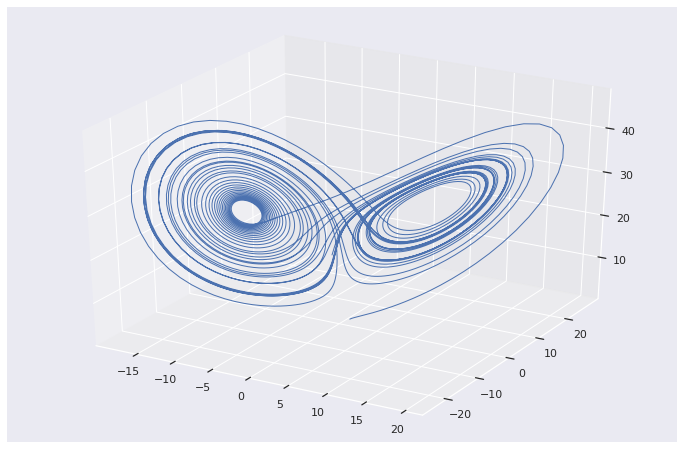

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()
sns.set(rc={'figure.figsize':(10, 8), "lines.linewidth": 1.0})

#### **Chaos Theory**

https://en.m.wikipedia.org/wiki/Chaos_theory

https://en.m.wikipedia.org/wiki/Phase_space

https://en.m.wikipedia.org/wiki/Lorenz_system

https://en.m.wikipedia.org/wiki/Dynamical_system

https://en.m.wikipedia.org/wiki/Deterministic_system

Many phenomena in nature can be described by dynamical systems; chaos theory makes precise the ways in which many of these systems exhibit unpredictable yet still deterministic behavior.

https://en.m.wikipedia.org/wiki/Mathematics#Pure_mathematics

**Complex Systems**

https://en.m.wikipedia.org/wiki/Complex_system#Complexity_and_chaos_theory

https://en.m.wikipedia.org/wiki/Complex_system

#### **Fractal Geometry**

https://www.youtube.com/watch?v=gB9n2gHsHN4

https://www.youtube.com/watch?v=FFftmWSzgmk

https://de.wikipedia.org/wiki/Fraktal

* idealization is everything is smooth (rebellion against calculus, differentiable, where assumption is things look smooth if you zoom in enough)

* Mandelbrot: nature is fractal (capture roughness)

* self-similar shapes give a basis for modeling the regularity in some forms of roughness 

* but that doesn't mean all is only perfectly self-similar either!! (Perfect self similar are: Von Koch snowflake, Sierpensky triangle)

* Fractal dimension: Sierpensky triangle is 1,585 dimensional, Von Koch snowflake is 1,262 dimensional, Britain coast line 1,21 dimensional, Norway: 1,52 dimensional, calm sea 2,05 dimensional, waves 2,3 dimensional

* Fractals are shapes with a non-integer dimension, captures idea of roughness,  but dimension can vary depending on how much you zoom in. Approaches: 

	* Box routing dimension
	* Information dimension
	* Hausdorff dimension
	* Packing dimension

* But a shape is considered a fractal only when the measures dimension stays approximately constant across multiple different scales

* **Is it fractal? Yes - probably from nature, No - probably man-made**

**Self-Similarity**

https://en.m.wikipedia.org/wiki/Self-similarity

**Self-Orgainzation**

https://en.m.wikipedia.org/wiki/Self-organization

**Feedback Loops**

https://en.m.wikipedia.org/wiki/Feedback